# Residual Integration Neural Net

# Problem statement :

Let us consider a dynamical system, whose time-varying state $X_t$ is governed by the following ordinary differential equation (ODE):

\begin{equation}
\frac{dX_t}{dt}= F(t,X_t)
\label{eq:sys dyn}
\end{equation}

where $F$ is the dynamical operator. Most of the time, this ODE cannot be solved analytically and numerical integration techniques using discrete approximations are implemented. 

In this work, we focus on explicit integration schemes. A one-step explicit integration scheme is defined as: 

\begin{equation}
\label{eq:int_gen_schm}
X_{t_{n+1}} = X_{t_{n}} + h\Phi(t_{n},X_{t_{n}},h)
\end{equation}

with $\Phi(t_{n},X_{t_{n}},h)$ a numerical integration operator. Here, we aim to learn a prediction operator based on $\Phi$ and an approximation of the dynamical model $F(t,X_t)$ so that the forecasting error (typically, a one-step-ahead error) is minimized.

In this notebook, will learn an approximation of both $\Phi$ and $F(t,X_t)$ of the lorenz 63 model given a poorly sampled time series.


In [1]:
from generate_data import generate_data
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
#import torch
from torch.autograd import Variable
import RINN_model
import matplotlib as mpl
mpl.rcParams['figure.dpi']=300
plt.rcParams["mathtext.fontset"] = "cm"
plt.rcParams.update({'font.size': 17})
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})
## for Palatino and other serif fonts use:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})
import matplotlib.font_manager

In [2]:
# dataset parameters
k5 = 200000000000
f  = 1.0
class GD:
    model = 'oregonator'
    class parameters:
        q = 7.62*10E-5#2*(1.28*3E3)/(2.4E6*33.6)
        f = 1.0
        eps = 3.9*10E-3
        eps2 = 1.98*10E-5
        X0=np.array([0.01,0.01,0.01]);
    dt_integration = 0.01 # integration time
    dt_states = 1 # number of integeration times between consecutive states (for xt and catalog)
    dt_obs = 8# number of integration times between consecutive observations (for yo)
    var_obs = np.array([0,1]) # indices of the observed variables
    nb_loop_train = 500.01 # size of the catalog
    nb_loop_test = 100 # size of the true state and noisy observations
    sigma2_catalog = 0.0 # variance of the model error to generate the catalog
    sigma2_obs = 2.0 # variance of the observation error to generate observation
    
# run the data generation
catalog, xt, yo = generate_data(GD)
#training data

In [3]:
batch_size      = 250
X_train = np.reshape(catalog.analogs,(int(catalog.analogs.shape[0]/batch_size),batch_size,catalog.analogs.shape[1]))
Grad_t  = np.gradient(X_train)[1]/GD.dt_integration
Y_train = np.reshape(catalog.successors,(int(catalog.analogs.shape[0]/batch_size),batch_size,catalog.analogs.shape[1]))

In [4]:
print(X_train.shape)
print(torch.cuda.get_device_name(0))
print(torch.__version__)

(200, 250, 3)


NameError: name 'torch' is not defined

WARNING - findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


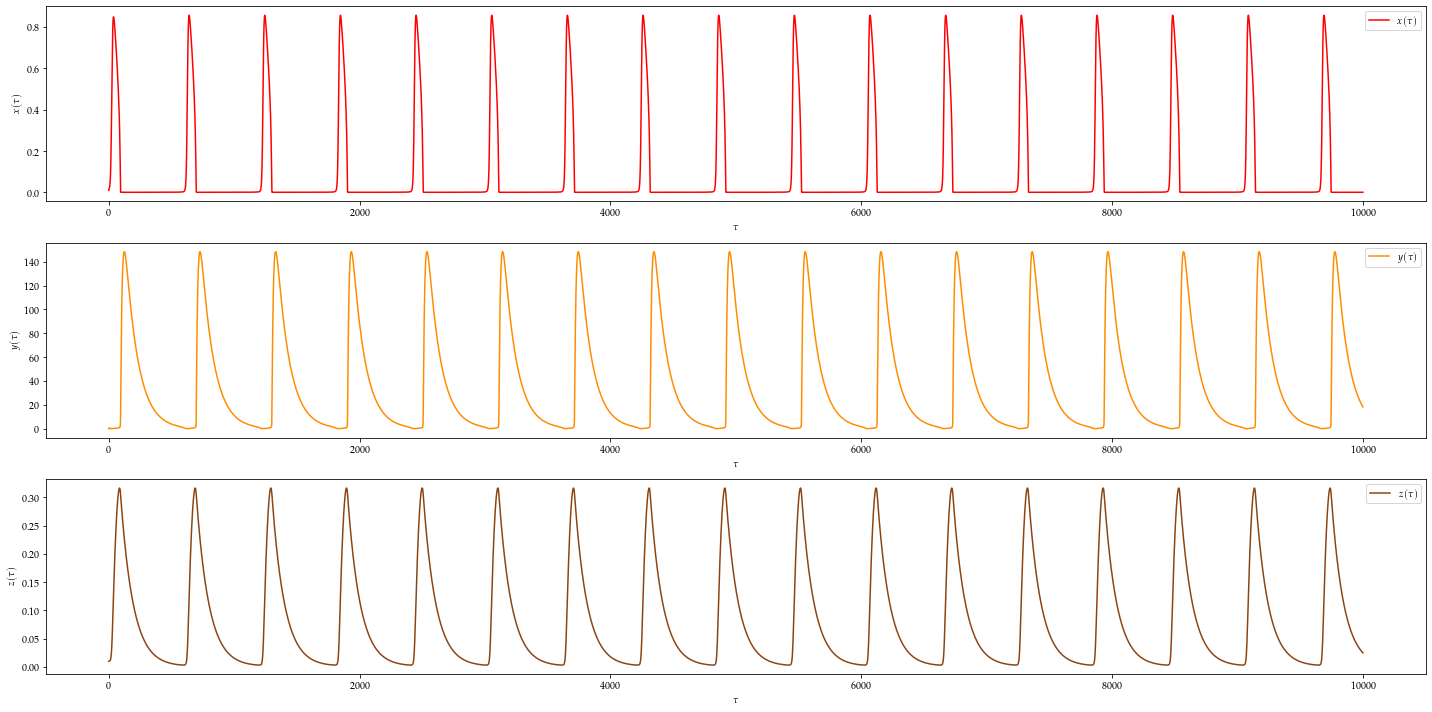

In [5]:
plt.figure(figsize=(20,10))
plt.title("Composantes de l'Oregonator")
plt.subplot(311)
plt.plot(xt.values[:,0],color='red',label=r'$x(\tau)$')
#plt.xscale('log')
plt.xlabel(r'$\tau$')
plt.ylabel(r'$x(\tau)$')
plt.legend(loc='best')
plt.subplot(312)
plt.plot(xt.values[:,1],color='darkorange',label=r'$y(\tau)$')
#plt.xscale('log')
plt.xlabel(r'$\tau$')
plt.ylabel(r'$y(\tau)$')
plt.legend(loc='best')
plt.subplot(313)
plt.plot(xt.values[:,2],color='saddlebrown',label=r'$z(\tau)$')
#plt.xscale('log')
plt.xlabel(r'$\tau$')
plt.ylabel(r'$z(\tau)$')
plt.legend(loc='best')
plt.tight_layout()
plt.savefig('graphes_org/org_odeint_com.png',dpi=300)


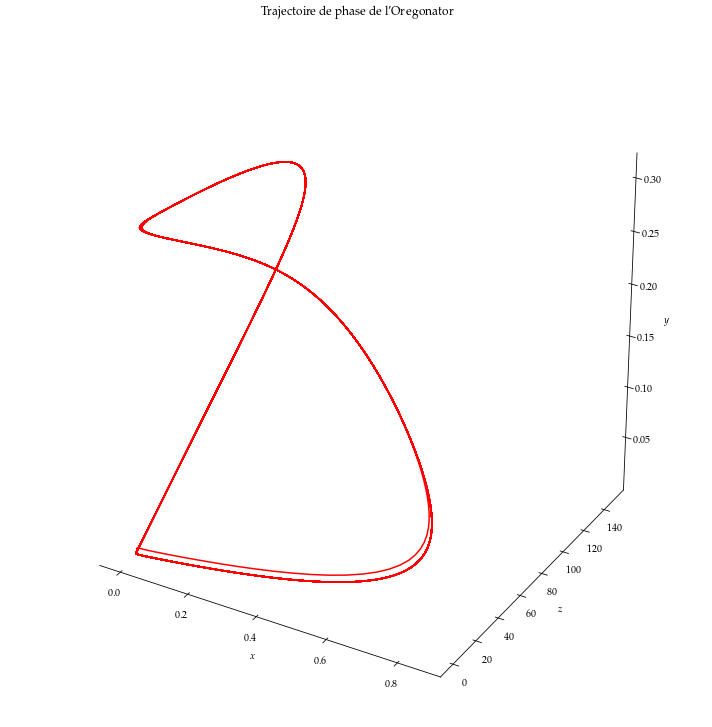

In [6]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111,projection='3d')
ax.grid(False)
ax.w_xaxis.set_pane_color ((0., 0., 0., 0.))
ax.w_yaxis.set_pane_color ((0., 0., 0., 0.))
ax.w_zaxis.set_pane_color ((0., 0., 0., 0.))
ax.plot(xt.values[:,0],xt.values[:,1],xt.values[:,2],color='red')
ax.set_xlabel(r'$x$')
ax.set_zlabel(r'$y$')
ax.set_ylabel(r'$z$')
plt.tight_layout()
plt.title("Trajectoire de phase de l'Oregonator")
plt.savefig('graphes_org/org_odeint_3d.png',dpi=300)

plt.show()

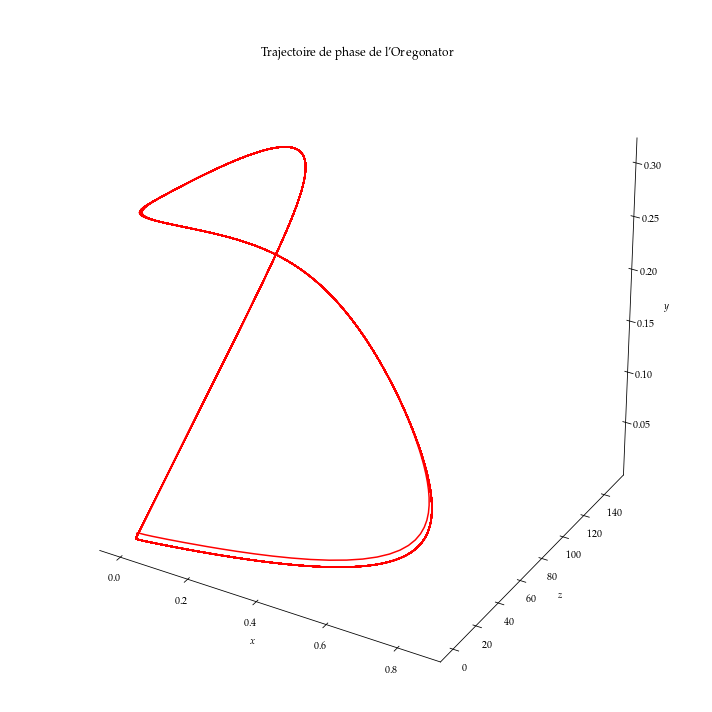

In [7]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111,projection='3d')
ax.grid(False)
ax.w_xaxis.set_pane_color ((0., 0., 0., 0.))
ax.w_yaxis.set_pane_color ((0., 0., 0., 0.))
ax.w_zaxis.set_pane_color ((0., 0., 0., 0.))
ax.plot(xt.values[:,0],xt.values[:,1],xt.values[:,2],color='red')
ax.set_xlabel(r'$x$')
ax.set_zlabel(r'$y$')
ax.set_ylabel(r'$z$')
plt.title("Trajectoire de phase de l'Oregonator")
plt.tight_layout()
plt.savefig('graphes_org/org_odeint_3d_CI.png',dpi=300)
plt.show()

In [8]:
GD.parameters.X0=np.array([0.3,0.1,0.1])
_,xt2,_ = generate_data(GD)
GD.parameters.X0=np.array([0.4,0.1,0.1])
_,xt3,_ = generate_data(GD)
GD.parameters.X0=np.array([0.8,0.1,0.1])
_,xt4,_ = generate_data(GD)

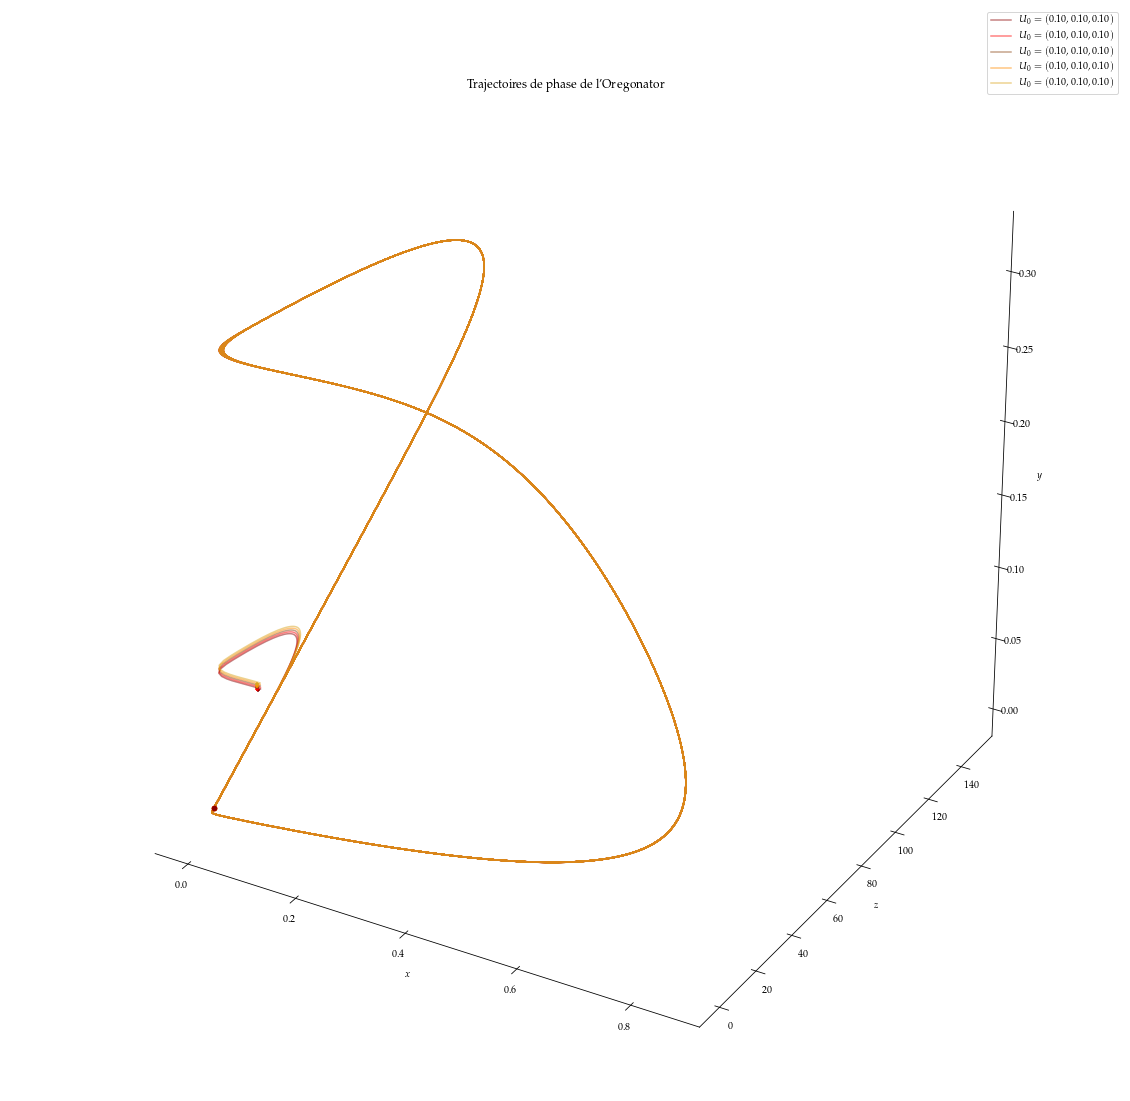

In [9]:
colorList=['darkred','red','saddlebrown','darkorange','goldenrod']
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(111,projection='3d')
ax.grid(False)
ax.w_xaxis.set_pane_color ((0., 0., 0., 0.))
ax.w_yaxis.set_pane_color ((0., 0., 0., 0.))
ax.w_zaxis.set_pane_color ((0., 0., 0., 0.))
a=b=0.1
for k in range(0,5):
    c=0.1+k/1000
    GD.parameters.X0=np.array([a,b,c])
    _,xt1,_ = generate_data(GD)
    ax.plot(xt1.values[:,0],xt1.values[:,1],xt1.values[:,2],label=r'$U_0=({:.2f},{:.2f},{:.2f})$'.format(a,b,c),color=colorList[k],alpha=0.5)
    ax.scatter(xt1.values[-1,0],xt1.values[-1,1],xt1.values[-1,2],color=colorList[k])
    ax.scatter(xt1.values[0,0],xt1.values[0,1],xt1.values[0,2],color=colorList[k],marker='+')
ax.set_xlabel(r'$x$')
ax.set_zlabel(r'$y$')
ax.set_ylabel(r'$z$')
ax.legend(loc='best')
plt.title("Trajectoires de phase de l'Oregonator")
plt.savefig('graphes_org/org_odeint_3d_inf_CI.png',dpi=300)
plt.show()

In [ ]:
plt.figure(figsize=(20,10))
plt.title("Composantes de l'Oregonator")
plt.subplot(2,2,1)
plt.plot(xt.values[:,0],color='red',label=r'$x(t)$')
plt.xscale('log')
plt.xlabel(r'$\tau$')
plt.ylabel(r'$x(t)$')
plt.legend(loc='best')
plt.subplot(2,2,2)
plt.plot(xt.values[:,1],color='darkorange',label=r'$y(t)$')
plt.xscale('log')
plt.xlabel(r'$\tau$')
plt.ylabel(r'$y(t)$')
plt.legend(loc='best')
plt.subplot(2,2,3)
plt.plot(xt.values[:,2],color='saddlebrown',label=r'$z(t)$')
plt.xscale('log')
plt.xlabel(r'$\tau$')
plt.ylabel(r'$z(t)$')
plt.legend(loc='best')
plt.subplot(2,2,4)
plt.fill([0,1,1,0],[0,0,1,1],'blue',alpha=0.5)
plt.tight_layout()

4983
4983
-0.17
5.88235294117647


Text(0.5, 1.0, 'Spectrum of the true solution')

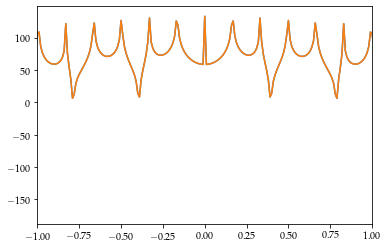

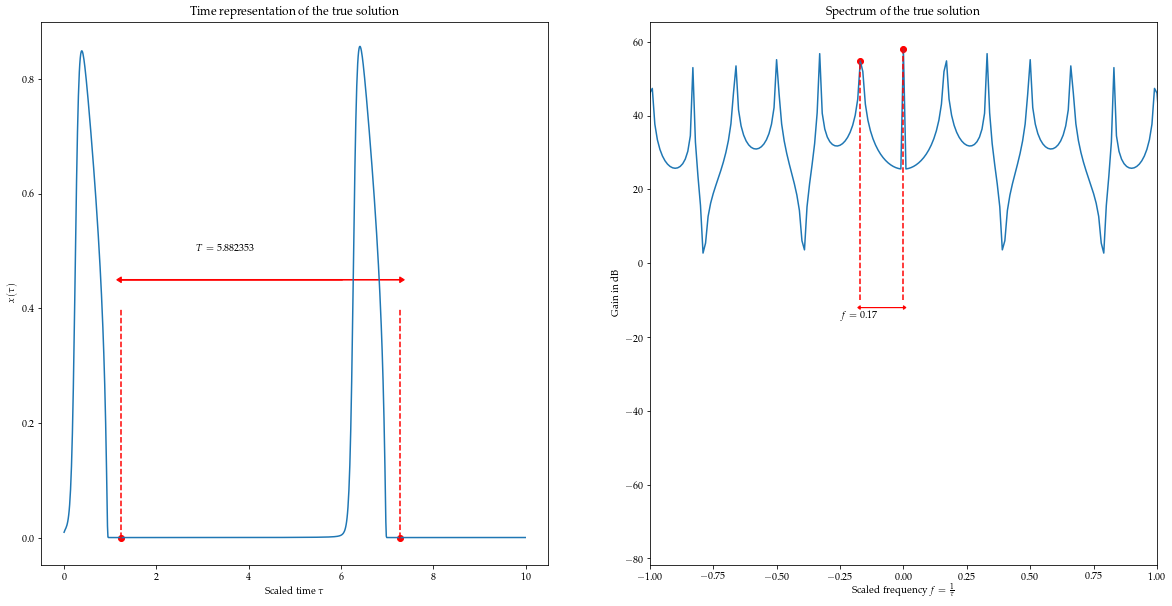

In [10]:
# calcul des frequences avec fftfreq
freq0 = np.fft.fftfreq(xt.values.shape[0], d=GD.dt_integration)
freq0=np.fft.fftshift(freq0)

fft0=np.fft.fftshift(np.fft.fft(xt.values[:,0]))
i_max0=list(np.abs(fft0)).index(np.max(np.abs(fft0[4970:5000])))
print(i_max0)
plt.plot(freq0,20*np.log(np.abs(fft0)))
plt.plot(freq0,20*np.log(np.abs(fft0)))
plt.xlim([-1,1])
print(i_max0)
T0=-1/freq0[i_max0]
print(freq0[i_max0])
print(T0)

i_min1=list(xt.values[:,0]).index(np.min(xt.values[:499,0]))
i_min2=list(xt.values[:,0]).index(np.min(xt.values[500:1000,0]))
t0=xt.time[i_min1]
t1=xt.time[i_min2]

plt.figure(figsize=(20,10))
plt.subplot(121)
plt.plot(xt.time[:1000],xt.values[:1000,0])
plt.xlabel(r'Scaled time $\tau$')
plt.ylabel(r'$x(\tau)$ ')
plt.scatter(t0,xt.values[i_min1,0],color='red')
plt.plot([t0,t0],[xt.values[i_min1,0],0.4],color='red',linestyle='dashed')
plt.plot([t1,t1],[xt.values[i_min2,0],0.4],color='red',linestyle='dashed')
plt.arrow(t0,0.45,t1-t0,0,color='red',head_width=0.01,head_length=0.1)
plt.arrow(t1-t0,0.45,-(t1-2*t0),0,color='red',head_width=0.01,head_length=0.1)
plt.scatter(t1,xt.values[i_min2,0],color='red')
plt.annotate(r'$T={:2f}$'.format(T0),((t1-t0)/2+t0-1.4,0.5))

plt.title('Time representation of the true solution')
#plt.arrow(list(xt.time).index(),0.05,list(xt.time).index(np.min(xt.values[501:,2])-list(xt.values).index(np.min(xt.values[:500,2]))),0)
plt.subplot(122)
plt.plot(freq0,20*np.log10(np.abs(fft0)), label="fft")
plt.xlim([-1,1])
plt.xlabel(r'Scaled frequency $f=\frac{1}{\tau}$')
plt.ylabel(r'Gain in dB')
plt.scatter(freq0[i_max0],20*np.log10(np.abs(fft0))[i_max0],color='red')
plt.plot([freq0[i_max0],freq0[i_max0]],[-10,20*np.log10(np.abs(fft0))[i_max0]],color='red',linestyle='dashed')
plt.scatter(0,20*np.log10(np.max(np.abs(fft0))),color='red')
plt.plot([0,0],[-10,20*np.log10(np.max(np.abs(fft0)))],color='red',linestyle='dashed')
plt.arrow(0,-12,freq0[i_max0],0,color='red',head_width=1,head_length=0.01)
plt.arrow(freq0[i_max0],-12,-freq0[i_max0],0,color='red',head_width=1,head_length=0.01)
plt.annotate(r'$f={}$'.format(-freq0[i_max0]),(-0.25,-15))
plt.title('Spectrum of the true solution')

4983
4983
5.88235294117647


Text(0.5, 1.0, 'Spectrum of the true solution')

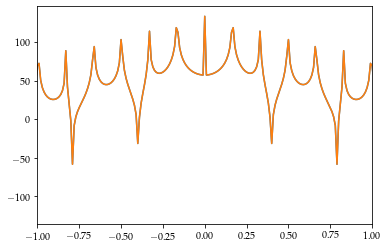

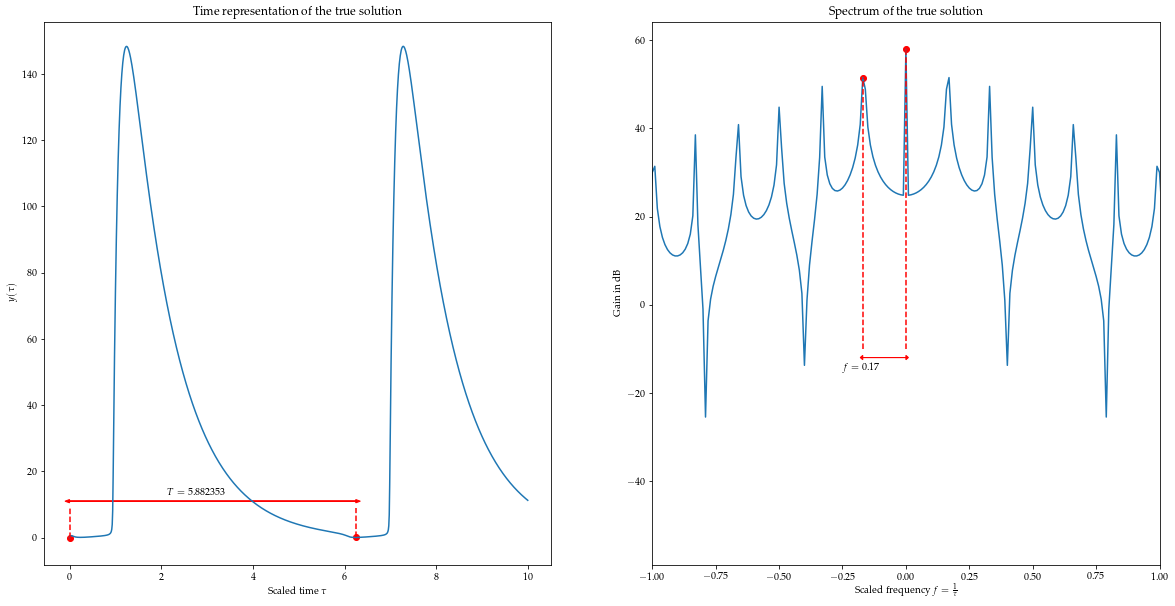

In [11]:
# calcul des frequences avec fftfreq
freq1 = np.fft.fftfreq(xt.values.shape[0], d=GD.dt_integration)
freq1=np.fft.fftshift(freq1)

fft1=np.fft.fftshift(np.fft.fft(xt.values[:,2]))
i_max1=list(np.abs(fft1)).index(np.max(np.abs(fft1[:5000])))
print(i_max1)
plt.plot(freq1,20*np.log(np.abs(fft1)))
plt.plot(freq1,20*np.log(np.abs(np.fft.fftshift(np.fft.fft(xt.values[:,2])))))
plt.xlim([-1,1])
print(i_max1)
T1=-1/freq1[i_max1]
print(T1)

i_min1=list(xt.values[:,1]).index(np.min(xt.values[:499,1]))
i_min2=list(xt.values[:,1]).index(np.min(xt.values[500:1000,1]))
t0=xt.time[i_min1]
t1=xt.time[i_min2]

plt.figure(figsize=(20,10))
plt.subplot(121)
plt.plot(xt.time[:1000],xt.values[:1000,1])
plt.xlabel(r'Scaled time $\tau$')
plt.ylabel(r'$y(\tau)$ ')
plt.scatter(t0,xt.values[i_min1,1],color='red')
plt.plot([t0,t0],[xt.values[i_min1,1],9],color='red',linestyle='dashed')
plt.plot([t1,t1],[xt.values[i_min2,1],9],color='red',linestyle='dashed')
plt.arrow(t0,11,t1-t0,0,color='red',head_width=1,head_length=0.1)
plt.arrow(t1-t0,11,-(t1-2*t0),0,color='red',head_width=1,head_length=0.1)
plt.scatter(t1,xt.values[i_min2,1],color='red')
plt.annotate(r'$T={:2f}$'.format(T1),((t1-t0)/2+t0-1,13))

plt.title('Time representation of the true solution')
#plt.arrow(list(xt.time).index(),0.05,list(xt.time).index(np.min(xt.values[501:,2])-list(xt.values).index(np.min(xt.values[:500,2]))),0)
plt.subplot(122)
plt.plot(freq1,20*np.log10(np.abs(fft1)), label="fft")
plt.xlim([-1,1])
plt.xlabel(r'Scaled frequency $f=\frac{1}{\tau}$')
plt.ylabel(r'Gain in dB')
plt.scatter(freq1[i_max1],20*np.log10(np.abs(fft1))[i_max1],color='red')
plt.plot([freq1[i_max1],freq1[i_max1]],[-10,20*np.log10(np.abs(fft1))[i_max1]],color='red',linestyle='dashed')
plt.scatter(0,20*np.log10(np.max(np.abs(fft1))),color='red')
plt.plot([0,0],[-10,20*np.log10(np.max(np.abs(fft1)))],color='red',linestyle='dashed')
plt.arrow(0,-12,freq1[i_max1],0,color='red',head_width=1,head_length=0.01)
plt.arrow(freq1[i_max1],-12,-freq1[i_max1],0,color='red',head_width=1,head_length=0.01)
plt.annotate(r'$f={}$'.format(-freq1[i_max1]),(-0.25,-15))
plt.title('Spectrum of the true solution')

5.88235294117647


Text(0.5, 1.0, 'Spectrum of the true solution')

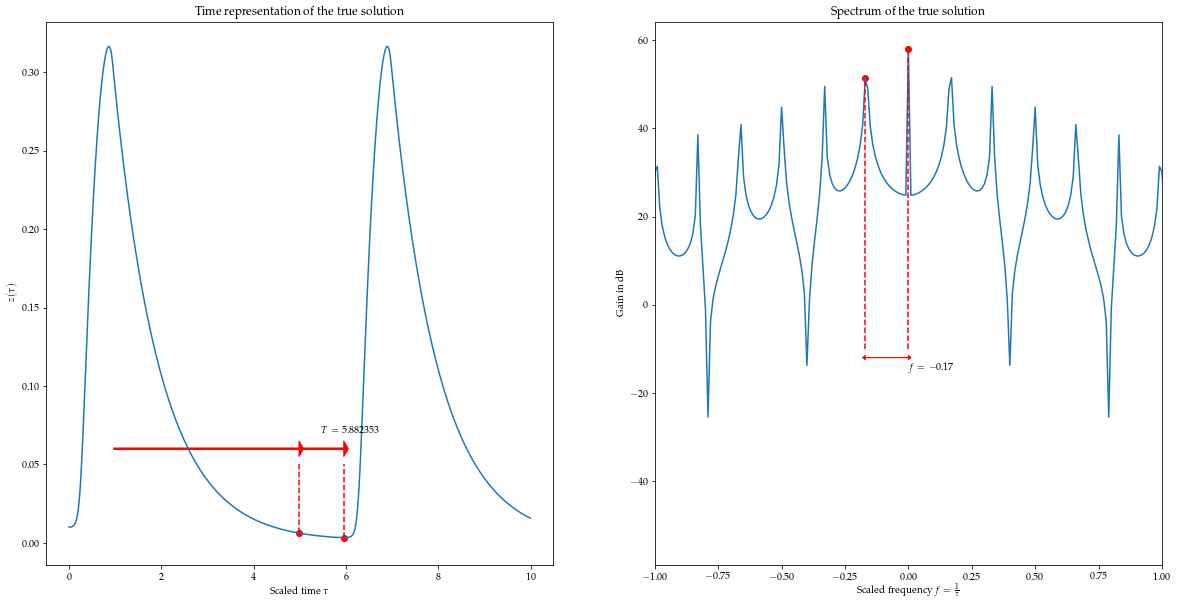

In [16]:
# calcul des frequences avec fftfreq
freq2 = np.fft.fftfreq(xt.values.shape[0], d=GD.dt_integration)
freq2=np.fft.fftshift(freq2)

fft2=np.fft.fftshift(np.fft.fft(xt.values[:,2]))
i_max2=list(np.abs(fft2)).index(np.max(abs(fft2[5001:])))


T2=-1/freq2[i_max2]
print(T2)
i_min1=list(xt.values[:,2]).index(np.min(xt.values[:499,2]))
i_min2=list(xt.values[:,2]).index(np.min(xt.values[500:1000,2]))
t0=xt.time[i_min1]
t1=xt.time[i_min2]

plt.figure(figsize=(20,10))
plt.subplot(121)
plt.plot(xt.time[:1000],xt.values[:1000,2])
plt.xlabel(r'Scaled time $\tau$')
plt.ylabel(r'$z(\tau)$ ')
plt.scatter(t0,xt.values[i_min1,2],color='red')
plt.plot([t0,t0],[xt.values[i_min1,2],0.05],color='red',linestyle='dashed')
plt.plot([t1,t1],[xt.values[i_min2,2],0.05],color='red',linestyle='dashed')
plt.arrow(t0,0.06,t1-t0,0,color='red',head_width=0.01,head_length=0.1)
plt.arrow(t1-t0,0.06,-(t1-2*t0),0,color='red',head_width=0.01,head_length=0.1)
plt.scatter(t1,xt.values[i_min2,2],color='red')
plt.annotate(r'$T={:2f}$'.format(T2),((t1-t0)/2+t0,0.07))

plt.title('Time representation of the true solution')
#plt.arrow(list(xt.time).index(),0.05,list(xt.time).index(np.min(xt.values[501:,2])-list(xt.values).index(np.min(xt.values[:500,2]))),0)
plt.subplot(122)
plt.plot(freq2,20*np.log10(np.abs(fft2)), label="fft")
plt.xlim([-1,1])
plt.xlabel(r'Scaled frequency $f=\frac{1}{\tau}$')
plt.ylabel(r'Gain in dB')
plt.scatter(freq2[i_max2],20*np.log10(np.abs(fft2))[i_max2],color='red')
plt.plot([freq2[i_max2],freq2[i_max2]],[-10,20*np.log10(np.abs(fft2))[i_max2]],color='red',linestyle='dashed')
plt.scatter(0,20*np.log10(np.max(np.abs(fft2))),color='red')
plt.plot([0,0],[-10,20*np.log10(np.max(np.abs(fft2)))],color='red',linestyle='dashed')
plt.arrow(0,-12,freq2[i_max2],0,color='red',head_width=1,head_length=0.01)
plt.arrow(freq2[i_max2],-12,-freq2[i_max2],0,color='red',head_width=1,head_length=0.01)
plt.annotate(r'$f={}$'.format(freq2[i_max2]),(0,-15))
plt.title('Spectrum of the true solution')

In [17]:
tscale=np.array([T0,T1,T2])
ymax1=np.max(xt.values[:,0])
ymin1=np.min(xt.values[:,0])
ymax2=np.max(xt.values[:,1])
ymin2=np.min(xt.values[:,1])
ymax3=np.max(xt.values[:,2])
ymin3=np.min(xt.values[:,2])
yscale=np.array([ymax1-ymin1,ymax2-ymin2,ymax3-ymin3])
print(yscale,tscale)
scale=np.array([yscale[i]/tscale[i] for i in range(3)])

[  0.85601518 148.36157169   0.31316807] [5.88235294 5.88235294 5.88235294]


5.09


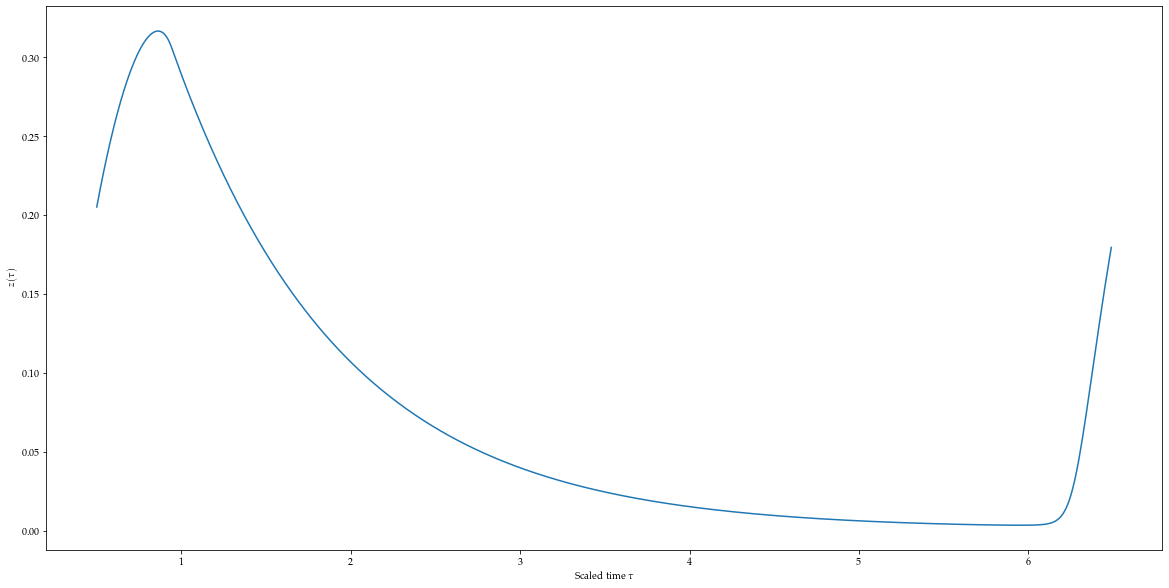

In [47]:
plt.figure(figsize=(20,10))
plt.plot(xt.time[50:650],xt.values[50:650,2])
plt.xlabel(r'Scaled time $\tau$')
plt.ylabel(r'$z(\tau)$ ')




T=xt.time[list(xt.values[:,2]).index(np.max(xt.values[50:650,2]))]-xt.time[list(xt.values[:,2]).index(np.min(xt.values[50:650,2]))]
print(np.abs(T))
scale=np.array([yscale[i]/abs(T) for i in range(3)])

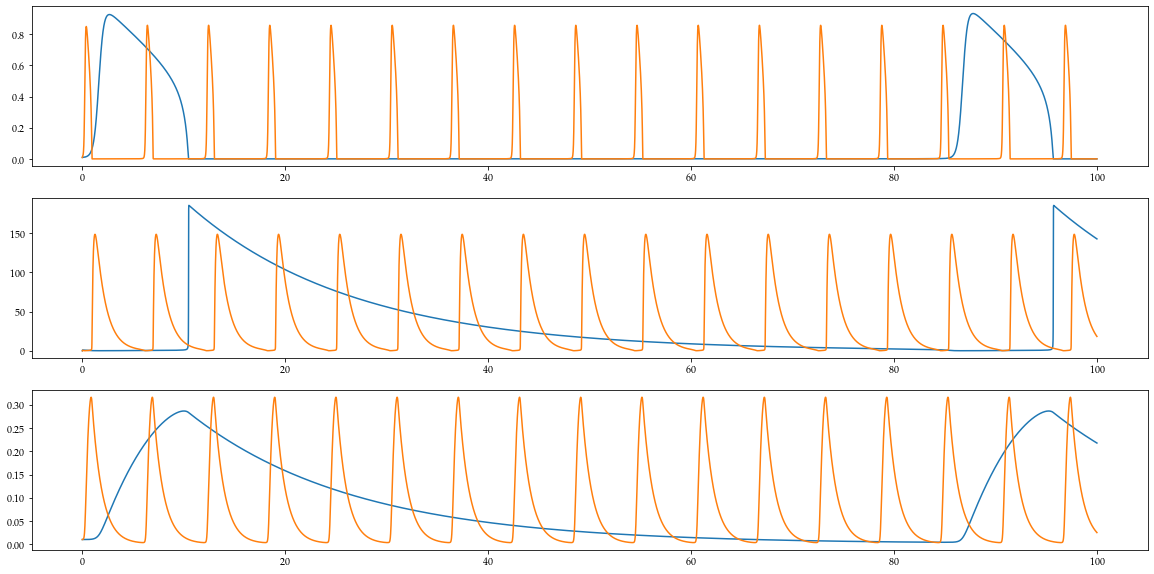

In [49]:
from scipy.integrate import odeint
def scaled_oregonator(S,t,q,f,eps,eps2,scale):
    """ Lorenz-63 dynamical model. """
    x_1 = (1/eps)*(q*S[1]-S[0]*S[1] +S[0]*(1-S[0]));
    x_2 = (1/eps2)*(-q*S[1]-S[1]*S[0]+f*S[2]);
    x_3 = (S[0]-S[2]);
    dS  = np.array([x_1,x_2,x_3]);
    return dS*scale

S=odeint(scaled_oregonator,xt.values[0,:],np.arange(0.01,GD.nb_loop_test+0.000001,GD.dt_integration),args=(GD.parameters.q,GD.parameters.f,GD.parameters.eps,GD.parameters.eps2,scale))

plt.figure(figsize=(20,10))
plt.subplot(311)
plt.plot(xt.time,S[:,0])
plt.plot(xt.time,xt.values[:,0])
plt.subplot(312)
plt.plot(xt.time,S[:,1])
plt.plot(xt.time,xt.values[:,1])
plt.subplot(313)
plt.plot(xt.time,S[:,2])
plt.plot(xt.time,xt.values[:,2])


In [ ]:
import sympy as sp
from sympy import *
from sympy import init_printing
init_printing() 

q=sp.symbols('q')
epsilon=sp.symbols('e')
epsilon_prime=sp.symbols("e_1")
f=sp.symbols('f')
x=sp.symbols('x')
y=sp.symbols('y')
z=sp.symbols('z')

# Opérateur 
F=sp.Matrix([1/epsilon*(q*y-x*y+x*(1-x)),1/epsilon_prime*(-q*y-x*y+f*z),x-z])
U=sp.Matrix([x,y,z])

# Jacobien
J=F.jacobian(U)

# Spectre
Sp=J.eigenvals()

Jacobian=lambdify([x,y,z,epsilon,epsilon_prime,q,f],J)
print(F)
#Point d'équilibre
U_eq=sp.solve(F,[x,y,z],set=True)
print(U_eq[1])


In [ ]:
U_eq1=sp.Matrix([-f/2 - q/2 + sqrt(f**2 + 6*f*q - 2*f + q**2 + 2*q + 1)/2 + 1/2, 3*f/4 + q/4 - sqrt(f**2 + 6*f*q - 2*f + q**2 + 2*q + 1)/4 + 1/4, -f/2 - q/2 + sqrt(f**2 + 6*f*q - 2*f + q**2 + 2*q + 1)/2 + 1/2])
U_eq2=sp.Matrix([-f/2 - q/2 - sqrt(f**2 + 6*f*q - 2*f + q**2 + 2*q + 1)/2 + 1/2, 3*f/4 + q/4 + sqrt(f**2 + 6*f*q - 2*f + q**2 + 2*q + 1)/4 + 1/4, -f/2 - q/2 - sqrt(f**2 + 6*f*q - 2*f + q**2 + 2*q + 1)/2 + 1/2])


In [ ]:
U_eq1.subs([(f,GD.parameters.f),(q,GD.parameters.q),(epsilon,GD.parameters.eps),(epsilon_prime,GD.parameters.eps2)])

In [ ]:
U_eq2.subs([(f,GD.parameters.f),(q,GD.parameters.q),(epsilon,GD.parameters.eps),(epsilon_prime,GD.parameters.eps2)])

In [ ]:
Keys=list(Sp.keys())
Eig1=Keys[0]
Eig2=Keys[1]
Eig3=Keys[2]
print('lambda_21=',latex(Eig1.subs([(x,-0.0394213017534445),(y,1.01971065087672),(z,-0.0394213017534445),(f,GD.parameters.f),(q,GD.parameters.q),(epsilon,GD.parameters.eps),(epsilon_prime,GD.parameters.eps2)]).evalf()))
print('lambda_22=',latex(Eig2.subs([(x,-0.0394213017534445),(y,1.01971065087672),(z,-0.0394213017534445),(f,GD.parameters.f),(q,GD.parameters.q),(epsilon,GD.parameters.eps),(epsilon_prime,GD.parameters.eps2)]).evalf()))
print('lambda_23=',latex(Eig3.subs([(x,-0.0394213017534445),(y,1.01971065087672),(z,-0.0394213017534445),(f,GD.parameters.f),(q,GD.parameters.q),(epsilon,GD.parameters.eps),(epsilon_prime,GD.parameters.eps2)]).evalf()))
print('lambda_11=',latex(Eig1.subs([(x,0.0386593017534445),(y,0.980670349123278),(z,0.0386593017534445),(f,GD.parameters.f),(q,GD.parameters.q),(epsilon,GD.parameters.eps),(epsilon_prime,GD.parameters.eps2)]).evalf()))
print('lambda_12=',latex(Eig2.subs([(x,0.0386593017534445),(y,0.980670349123278),(z,0.0386593017534445),(f,GD.parameters.f),(q,GD.parameters.q),(epsilon,GD.parameters.eps),(epsilon_prime,GD.parameters.eps2)]).evalf()))
print('lambda_13=',latex(Eig3.subs([(x,0.0386593017534445),(y,0.980670349123278),(z,0.0386593017534445),(f,GD.parameters.f),(q,GD.parameters.q),(epsilon,GD.parameters.eps),(epsilon_prime,GD.parameters.eps2)]).evalf()))

In [ ]:
Eig1=[]
Eig2=[]
Eig3=[]

for i in range(xt.values.shape[0]):
    Jac=np.array(Jacobian(xt.values[i,0],xt.values[i,1],xt.values[i,2],GD.parameters.eps,GD.parameters.eps2,GD.parameters.q,GD.parameters.f))
    Eigs=np.linalg.eigvals(Jac)
    AbsEig=np.abs(Eigs)
    Eig1.append(AbsEig[0])
    Eig2.append(AbsEig[1])
    Eig3.append(AbsEig[2])
  

In [ ]:
plt.figure(figsize=(10,10))

plt.subplot(3,1,1)
plt.title('Spectre du jacobien de F en fonction du temps')
plt.plot(Eig1,color='red',label=r'$\lambda_1$')
plt.xscale('log')
plt.xlabel(r'$\tau$')
plt.legend(loc='best')
plt.subplot(3,1,2)
plt.plot(Eig2,color='darkorange',label=r'$\lambda_2$')
plt.xscale('log')
plt.xlabel(r'$\tau$')
plt.legend(loc='best')
plt.subplot(3,1,3)
plt.plot(Eig3,color='saddlebrown',label=r'$\lambda_3$')
plt.xscale('log')
plt.xlabel(r'$\tau$')
plt.legend(loc='best')
plt.savefig('graphes_org/specter_time',dpi=300)
plt.tight_layout()
plt.show()

In [ ]:
Stiffness=[max(Eig1[i],Eig2[i],Eig3[i])/min(Eig1[i],Eig2[i],Eig3[i]) for i in range(len(Eig1))]
plt.figure(figsize=(10,10))
plt.title('Raideur en fonction du temps')
plt.plot(Stiffness,color='red',label=r'$\max Sp(J_F)/\min Sp(J_F)$')
plt.xlabel(r'$\tau$')
plt.xscale('log')
plt.yscale('log')
plt.legend(loc='best')
plt.savefig('graphes_org/stiffness.png',dpi=300)

In [51]:
# generating training data
class GD2:
    model = 'Adv_Dif_1D_Real'
    class parameters:
        w = -0.5
        x0 = 0.5
        t0 = 0
    dt_integration =0.01# integration time
    dt_states = 1 # number of integeration times between consecutive states (for xt and catalog)
    dt_obs = 8# number of integration times between consecutive observations (for yo)
    var_obs = np.array([0]) # indices of the observed variables
    nb_loop_train = 1000.1 # size of the catalog
    nb_loop_test = 100 # size of the true state and noisy observations
    sigma2_catalog = 0.0 # variance of the model error to generate the catalog
    sigma2_obs = 2.0 # variance of the observation error to generate observation
    
# run the data generation
catalog2, xt2, yo2 = generate_data(GD2)
#AnDA_RMSE(catalog.true_solution,catalog.euler_integration)
#AnDA_RMSE(catalog.true_solution,catalog.num_integration)
#training data
batch_size_lin = catalog2.true_solution[:-10-1,:].shape[0]
X_train_lin = np.reshape(catalog2.true_solution[:-10-1,:],(int(catalog2.true_solution[1:-10,:].shape[0]/batch_size_lin),batch_size_lin,catalog2.true_solution[1:-10,:].shape[1]))
Grad_t_lin  = np.reshape(np.gradient(catalog2.true_solution[:-10-1,0])/GD.dt_integration,(X_train_lin.shape))
Y_train_lin = np.reshape(catalog2.true_solution[1:-10,:],(int(catalog2.true_solution[1:-10,:].shape[0]/batch_size_lin),batch_size_lin,catalog2.true_solution[1:-10,:].shape[1]))

In [72]:
import torch
params = {}#NN parameters 
params['order'] = 8
params['transition_layers']=1
params['bi_linear_layers']=3
params['dim_hidden_linear'] = 3
params['dim_input']=3
params['dim_observations'] = 3
params['dim_output']=3
params['dim_hidden']=3
params['dt_integration']=GD.dt_integration
params['ntrain']=[200,1000]
params['lr']=0.0001
pretrained = False
path = 'oreg.pt'

In [73]:
def jacobian_in_batch(y, x):
    '''
    Compute the Jacobian matrix in batch form.
    Return (B, D_y, D_x)
    '''

    batch = y.shape[0]
    single_y_size = np.prod(y.shape[1:])
    y = y.view(batch, -1)
    vector = torch.ones(batch).to(y)

    # Compute Jacobian row by row.
    # dy_i / dx -> dy / dx
    # (B, D) -> (B, 1, D) -> (B, D, D)
    jac = [torch.autograd.grad(y[:, i], x, 
                               grad_outputs=vector, 
                               retain_graph=True,
                               create_graph=True,
                               allow_unused=True)[0].view(batch, -1)
                for i in range(single_y_size)]
    jac = torch.stack(jac, dim=1)
    #print(jac)
    
    return jac
def kron(a, b):
    """
    Kronecker product of matrices a and b with leading batch dimensions.
    Batch dimensions are broadcast. The number of them mush
    :type a: torch.Tensor
    :type b: torch.Tensor
    :rtype: torch.Tensor
    """
    siz1 = torch.Size(torch.tensor(a.shape[-2:]) * torch.tensor(b.shape[-2:]))
    res = a.unsqueeze(-1).unsqueeze(-3) * b.unsqueeze(-2).unsqueeze(-4)
    siz0 = res.shape[:-4]
    return res.reshape(siz0 + siz1)

# Learn dynamical and integration models, stop when loss ~ 0.2

In [74]:
class applyRK_Constraints(object):
        def __init__(self, frequency=1):
            self.frequency = frequency
    
        def __call__(self, module):
            if hasattr(module, 'b'):
                module.b.data = (torch.abs(module.b.data))
                module.b.data  =  ((module.b.data) / (module.b.data).sum(1,keepdim = True).expand_as(module.b.data))
            if hasattr(module, 'c'):
                module.c.data = module.c.data
                module.c.data[:,0] = 0
                module.c.data = module.c.data.sub_(torch.min(module.c.data)).div_(torch.max(module.c.data) - torch.min(module.c.data)).sort()[0]
class FC_net_true(torch.nn.Module):
        def __init__(self, params,scale):
            super(FC_net_true, self).__init__()
            self.q, self.f, self.eps, self.eps2 = [GD.parameters.q,GD.parameters.f,GD.parameters.eps,GD.parameters.eps2]
            self.scale=scale
        
        def forward(self, inp):
            """
            In the forward function we accept a Tensor of input data and we must return
            a Tensor of output data. We can use Modules defined in the constructor as
            well as arbitrary operators on Tensors.
            """
            grad = Variable(torch.zeros((inp.size())))
            grad[:,0] = (1/self.eps)*(self.q*inp[:,1]-inp[:,0]*inp[:,1] +inp[:,0]*(1-inp[:,0]))*self.scale[0]
            grad[:,1] = (1/self.eps2)*(-self.q*inp[:,1]-inp[:,1]*inp[:,0]+self.f*inp[:,2])*self.scale[1]
            grad[:,2] = (inp[:,0]-inp[:,2])*self.scale[2]
 
            return grad

model_true  = FC_net_true(params,scale)


class FC_net(torch.nn.Module):
        def __init__(self, params):
            super(FC_net, self).__init__()
            self.linearCell   = torch.nn.Linear(params['dim_input'], params['dim_hidden_linear']) 
            self.BlinearCell1 = torch.nn.ModuleList([torch.nn.Linear(params['dim_input'], 1) for i in range(params['bi_linear_layers'])])
            self.BlinearCell2 = torch.nn.ModuleList([torch.nn.Linear(params['dim_input'], 1) for i in range(params['bi_linear_layers'])])
            augmented_size    = params['bi_linear_layers'] + params['dim_hidden_linear']
            self.transLayers = torch.nn.ModuleList([torch.nn.Linear(augmented_size, params['dim_output'])])
            self.transLayers.extend([torch.nn.Linear(params['dim_output'], params['dim_output']) for i in range(1, params['transition_layers'])])
            self.outputLayer  = torch.nn.Linear(params['dim_output'], params['dim_output']) 
        def forward(self, inp):
            """
            In the forward function we accept a Tensor of input data and we must return
            a Tensor of output data. We can use Modules defined in the constructor as
            well as arbitrary operators on Tensors.
            """
            BP_outp = Variable(torch.zeros((inp.size()[0],params['bi_linear_layers'])))
            L_outp   = self.linearCell(inp)
            for i in range((params['bi_linear_layers'])):
                BP_outp[:,i]=self.BlinearCell1[i](inp)[:,0]*self.BlinearCell2[i](inp)[:,0]
            aug_vect = torch.cat((L_outp, BP_outp), dim=1)
            for i in range((params['transition_layers'])):
                aug_vect = (self.transLayers[i](aug_vect))
            grad = self.outputLayer(aug_vect)
            return grad
model  = FC_net(params)
class FC_net_lin(torch.nn.Module):
        def __init__(self, params):
            super(FC_net_lin, self).__init__()
            self.coef_mdl =GD2.parameters.w
        def forward(self, inp):
            """
            In the forward function we accept a Tensor of input data and we must return
            a Tensor of output data. We can use Modules defined in the constructor as
            well as arbitrary operators on Tensors.
            """
            grad = self.coef_mdl*inp
            return grad
model_lin  = FC_net_lin(params)
class INT_net(torch.nn.Module):
        def __init__(self, params,order):
            super(INT_net, self).__init__()
            self.Dyn_net = model_true#model
            self.Dyn_net_lin = model_lin
            self.Dyn_net_True = model_true
            a = 0*np.tril(np.random.uniform(size=(1,order,order)),k=-1)
            b = 0.01+0*np.random.uniform(size=(1,order))
            c = 0.01+0*np.random.uniform(size=(1,order))
            self.a = torch.nn.Parameter(torch.from_numpy(a[:,:,:]).float(),requires_grad = True)
            self.b = torch.nn.Parameter(torch.from_numpy(b).float(),requires_grad = True)
            self.c = torch.nn.Parameter(torch.from_numpy(c).float(),requires_grad = True)
        def lin_flow(self, inp, dt, order):
            """
            In the forward function we accept a Tensor of input data and we must return
            a Tensor of output data. We can use Modules defined in the constructor as
            well as arbitrary operators on Tensors.
            """
            k = [(self.Dyn_net_lin(inp))]
            for i in range(1,order):
                coef_sum = torch.autograd.Variable(torch.zeros(k[0].size()))
                for j in range(0,i):
                    if j ==0:
                        if i == 1:
                            coef_sum = coef_sum + k[j]*(self.c[:,i]).expand_as(k[j])
                        else:
                            coef_sum = coef_sum + k[j]*(self.c[:,i]-self.a[:,i,1:i].sum(1)).expand_as(k[j])
                    else :
                        coef_sum = coef_sum + k[j]*self.a[:,i,j].expand_as(k[j])
                rk_inp = inp+dt*coef_sum        
                k.append(self.Dyn_net_lin(rk_inp))
            pred_sum = torch.autograd.Variable(torch.zeros(k[0].size()))
            for i in range(0,order): 
                pred_sum = pred_sum+k[i]*self.b[:,i].expand_as(k[i])
            pred = inp +dt*pred_sum
            gain = pred[0,:]/(inp[0,:])
            return pred ,k[0], gain 
        def flow_True_Model(self, inp, dt, order):
            """
            In the forward function we accept a Tensor of input data and we must return
            a Tensor of output data. We can use Modules defined in the constructor as
            well as arbitrary operators on Tensors.
            """
            k = [(self.Dyn_net_True(inp))]
            for i in range(1,order):
                coef_sum = torch.autograd.Variable(torch.zeros(k[0].size()))
                for j in range(0,i):
                    if j ==0:
                        if i == 1:
                            coef_sum = coef_sum + k[j]*(self.c[:,i]).expand_as(k[j])
                        else:
                            coef_sum = coef_sum + k[j]*(self.c[:,i]-self.a[:,i,1:i].sum(1)).expand_as(k[j])
                    else :
                        coef_sum = coef_sum + k[j]*self.a[:,i,j].expand_as(k[j])
                rk_inp = inp+dt*coef_sum        
                k.append(self.Dyn_net_True(rk_inp))
            pred_sum = torch.autograd.Variable(torch.zeros(k[0].size()))
            for i in range(0,order): 
                pred_sum = pred_sum+k[i]*self.b[:,i].expand_as(k[i])
            pred = inp +dt*pred_sum
            return pred ,k[0], inp
        def flow_RK45_True_Model(self, inp,dt,order = 4):
            k1    = self.Dyn_net_True(inp)
            inp_k2 = inp + 0.5*dt*k1
            k2  = self.Dyn_net_True(inp_k2)
            inp_k3 = inp + 0.5*dt*k2       
            k3   = self.Dyn_net_True(inp_k3)
            inp_k4 = inp + dt*k3          
            k4   = self.Dyn_net_True(inp_k4)            
            pred = inp +dt*(k1+2*k2+2*k3+k4)/6    
            return pred, k1        
        def flow_RK45(self, inp,dt,order = 4):
            k1    = self.Dyn_net(inp)
            inp_k2 = inp + 0.5*dt*k1
            k2  = self.Dyn_net(inp_k2)
            inp_k3 = inp + 0.5*dt*k2       
            k3   = self.Dyn_net(inp_k3)
            inp_k4 = inp + dt*k3          
            k4   = self.Dyn_net(inp_k4)            
            pred = inp +dt*(k1+2*k2+2*k3+k4)/6    
            return pred, k1        
        def opti_gain_lin(self, h_int, inp, order):
            gain = Variable(torch.zeros(h_int.size()).float())
            for i in range(h_int.shape[0]):
                pred ,tmp, tmpp =self.lin_flow(inp, h_int[i], order)
                gain[i] = tmpp[0]
                del pred, tmp, tmpp
            return gain
        def Linear_newton_method_solver(self,function, initial,inp,dt,order, iteration=20, convergence=0.00000001):
            for i in range(iteration): 
                previous_data = initial.clone()
                value = function(initial,inp,dt,order)
                
                jacs = jacobian_in_batch(self.Dyn_net(inp), inp)#, 2, 3, verbose=1)
                inc = torch.bmm(torch.inverse(torch.eye(initial.shape[-1]).unsqueeze(0).repeat(initial.shape[0],1,1)-dt*kron(self.a.repeat(jacs.shape[0],1,1),jacs)),value.unsqueeze(-1)).squeeze(-1) 
                # update 
                initial = initial + inc
                # zero out current gradient to hold new gradients in next iteration 
                #initial.grad.data.zero_() 
                # Check convergence. 
                # When difference current epoch result and previous one is less than 
                # convergence factor, return result.
                if torch.abs(initial - previous_data).sum() < torch.tensor(convergence):
                    return initial
            return initial # return our final after iteration                
        def newton_method_solver(self,function, initial,inp,dt,order, iteration=20, convergence=0.00000001):
            for i in range(iteration): 
                print('iteration ', i)
                previous_data = initial.clone()
                value = function(initial,inp,dt,order)
                jacs = jacobian_in_batch(value, initial)#, 2, 3, verbose=1)
                # update 
                initial = initial - torch.bmm(torch.inverse(jacs),value.unsqueeze(2)).squeeze(-1)#(value / initial.grad).data
                # zero out current gradient to hold new gradients in next iteration 
                #initial.grad.data.zero_() 
                # Check convergence. 
                # When difference current epoch result and previous one is less than 
                # convergence factor, return result.
                if torch.abs(initial - previous_data).sum() < torch.tensor(convergence):
                    return initial
            return initial # return our final after iteration
        def solve_function(self, kin, inp, dt, order):
            zin = inp.unsqueeze(1).repeat(1, order, 1).reshape(inp.shape[0],-1)
            fin = torch.zeros_like(zin)
            for i in range(order):
                fin[:,i*inp.shape[-1]:(i+1)*inp.shape[-1]] = (self.Dyn_net(kin[:,i*inp.shape[-1]:(i+1)*inp.shape[-1]]))
            all_in = zin - kin + torch.bmm(dt*(kron(self.a,torch.eye(inp.shape[-1]).unsqueeze(0))).repeat(fin.shape[0],1,1),fin.unsqueeze(-1)).squeeze(-1)           
            return all_in
        def forward(self, inp, dt, order):
            """
            In the forward function we accept a Tensor of input data and we must return
            a Tensor of output data. We can use Modules defined in the constructor as
            well as arbitrary operators on Tensors.
            """
            k = [(self.Dyn_net(inp))]
            for i in range(1,order):
                coef_sum = torch.zeros(k[0].size())
                for j in range(0,i):
                    if j ==0:
                        if i == 1:
                            coef_sum = coef_sum + k[j]*(self.c[:,i]).expand_as(k[j])
                        else:
                            coef_sum = coef_sum + k[j]*(self.c[:,i]-self.a[:,i,1:i].sum(1)).expand_as(k[j])
                    else :
                        coef_sum = coef_sum + k[j]*self.a[:,i,j].expand_as(k[j])
                rk_inp = inp+dt*coef_sum        
                k.append(self.Dyn_net(rk_inp))
            #self.a.data[0,:,0] = self.c[0,:] - self.a[:,:,1:].sum(dim = 2)
            k_init = torch.ones_like(torch.stack(k).permute(1,0,2).reshape(inp.shape[0],-1))
            k_opti = self.Linear_newton_method_solver(self.solve_function, k_init,inp,dt,order, iteration=5, convergence=0.0000001)
            #print(k_opti[:,:6])
            pred_sum = torch.autograd.Variable(torch.zeros(inp.size()))
            for i in range(0,order):
                pred_sum = pred_sum+self.Dyn_net(k_opti[:,i*inp.shape[-1]:(i+1)*inp.shape[-1]])*self.b[0,i].expand_as(k_opti[:,i*inp.shape[-1]:(i+1)*inp.shape[-1]])
            pred = inp +dt*pred_sum
            gain = pred[0,:]/inp[0,:]
            return pred ,k_opti, gain 
class applyRK_Constraints(object):
        def __init__(self, frequency=1):
            self.frequency = frequency
        def __call__(self, module):
            if hasattr(module, 'b'):
                module.b.data = (torch.abs(module.b.data))
                module.b.data  =  ((module.b.data) / (module.b.data).sum(1,keepdim = True).expand_as(module.b.data))
            if hasattr(module, 'c'):
                module.c.data = module.c.data
                module.c.data[:,0] = 0
                module.c.data = module.c.data.sub_(torch.min(module.c.data)).div_(torch.max(module.c.data) - torch.min(module.c.data)).sort()[0]
            if hasattr(module, 'a'):
                module.a.data[0,:,0] = module.c.data[0,:] - module.a.data[:,:,1:].sum(dim = 2)


In [75]:
x = Variable(torch.from_numpy(X_train).float())
y = Variable(torch.from_numpy(Y_train).float())
z = Variable(torch.from_numpy(Grad_t).float())


x_lin = Variable(torch.from_numpy(X_train_lin).float())
y_lin = Variable(torch.from_numpy(Y_train_lin).float())
z_lin = Variable(torch.from_numpy(Grad_t_lin).float())

hi = np.arange(0,5.0+0.000001,0.01)
h_int = Variable(torch.from_numpy(hi).float())
gain_true = Variable(torch.from_numpy(np.ones_like(h_int)).float())

# Construct our model by instantiating the class defined above
    
modelRINN = INT_net(params,params['order'])

if pretrained :
        modelRINN.load_state_dict(torch.load(path))

criterion = torch.nn.L1Loss()

def customized_loss(x, y):
        gain_to_zero = ((x-y))**2
        return torch.mean(gain_to_zero)

optimizer = torch.optim.Adam(modelRINN.parameters(), lr = 0.0000000001)

clipper = applyRK_Constraints()

def gradClamp(parameters, clip=5):
    for p in parameters:
        if p.grad !=None:
            p.grad.data.clamp_(min = -clip,max=clip)

In [76]:
# On vérifie que pour une expérience d'intégration pure, le modèle utilisé par le RINN est bien celui désiré
from scipy.integrate import odeint

NumSolOdeint=xt.values
print(NumSolOdeint.shape)
# Conversion en tenseur
NumSolOdeintTensor=Variable(torch.from_numpy(xt.values).float(),requires_grad=True)
#print(NumSolOdeintTensor)

NumSolRINNPlot=np.zeros((NumSolOdeint.shape[0],NumSolOdeint.shape[1]))
for i in range(NumSolOdeint.shape[0]):
    NumSolRINNPlot[i,:]=modelRINN(NumSolOdeintTensor[i,:],params['dt_integration'],params['order']).data.numpy()

(10000, 3)


IndexError: too many indices for tensor of dimension 1

In [77]:
            b = 0
            x.requires_grad = True
            # Forward pass: Compute predicted gradients by passing x to the model
            pred ,grad , inp = modelRINN(x[b,:,:],params['dt_integration'],params['order'])
            #pred2 ,grad , inp = modelRINN(pred,params['dt_integration'],params['order'])
            #pred3 ,grad , inp = modelRINN(pred2,params['dt_integration'],params['order'])
            #pred4 ,grad , inp = modelRINN(pred3,params['dt_integration'],params['order'])
            # Compute and print loss
            loss = criterion(pred[np.where(~np.isnan(pred.data.numpy()))], y[b,:,:][np.where(~np.isnan(pred.data.numpy()))])#+criterion(pred2[:-1,:], pred[1:,:])#+criterion(pred3[:-1,:], pred2[1:,:])+criterion(pred4[:-1,:], pred3[1:,:])
            optimizer.zero_grad()
            loss.backward()

In [78]:
modelRINN.a.grad

tensor([[[-0.0173, -0.0173, -0.0173, -0.0173, -0.0173, -0.0173, -0.0173,
          -0.0173],
         [-0.0173, -0.0173, -0.0173, -0.0173, -0.0173, -0.0173, -0.0173,
          -0.0173],
         [-0.0173, -0.0173, -0.0173, -0.0173, -0.0173, -0.0173, -0.0173,
          -0.0173],
         [-0.0173, -0.0173, -0.0173, -0.0173, -0.0173, -0.0173, -0.0173,
          -0.0173],
         [-0.0173, -0.0173, -0.0173, -0.0173, -0.0173, -0.0173, -0.0173,
          -0.0173],
         [-0.0173, -0.0173, -0.0173, -0.0173, -0.0173, -0.0173, -0.0173,
          -0.0173],
         [-0.0173, -0.0173, -0.0173, -0.0173, -0.0173, -0.0173, -0.0173,
          -0.0173],
         [-0.0173, -0.0173, -0.0173, -0.0173, -0.0173, -0.0173, -0.0173,
          -0.0173]]])

In [79]:
for param_group in optimizer.param_groups:
        param_group['lr'] = 1e-7

inv_yscale=torch.from_numpy(np.array([1/yscale[i] for i in range(3)]))
print(inv_yscale)

tensor([1.1682, 0.0067, 3.1932], dtype=torch.float64)


In [80]:
modelRINN.apply(clipper)
from tqdm import tqdm


Means=[]
Max=[]
Batch=x.shape[0]
Index=[i for i in range(Batch)]
SelectedBatchs=[]

print ('Learning dynamical model')
for t in tqdm(range(params['ntrain'][0])):
        maxLoss=0
        m=0
        for b in Index:
            #b = 0
           
            
            # Forward pass: Compute predicted gradients by passing x to the model
            pred ,grad , inp = modelRINN(x[b,:,:],params['dt_integration']*0.168,params['order'])
            pred2 ,grad , inp = modelRINN(pred,params['dt_integration'],params['order'])
            #pred3 ,grad , inp = modelRINN(pred2,params['dt_integration'],params['order'])
            #pred4 ,grad , inp = modelRINN(pred3,params['dt_integration'],params['order'])
            # Compute and print loss
            loss = criterion(pred[np.where(~np.isnan(torch.mul(pred,inv_yscale).data.numpy()))],torch.mul(y[b,:,:],inv_yscale)[np.where(~np.isnan(pred.data.numpy()))])+criterion(pred2[:-1,:], pred[1:,:])#+cr
            print(t,b,loss)
            # Zero gradients, perform a backward pass, and update the weights.
            optimizer.zero_grad()
            loss.backward()
            gradClamp(modelRINN.parameters())
            optimizer.step()
            modelRINN.apply(clipper)
            
            # Saving the model : checkpoint

            torch.save({
            'epoch': t,
            'batch':b,
            'model_state_dict': modelRINN.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            }, 'oregonator_checkpoint')
            if loss.detach().numpy().item()>maxLoss:
                maxLoss=loss.detach().numpy().item()
            m+=loss.detach().numpy().item()
            
            if loss.detach().numpy()<1e-3:
              Index.remove(b)
       
            
            if loss.detach().numpy()>maxLoss:
              maxLoss=loss.detach().numpy()
            
            SelectedBatchs.append(len(Index))
        
        if maxLoss<1e-3:
          break
            
        Means.append(m/x.shape[0])
        Max.append(maxLoss)
        print('mean',m/x.shape[0])
        print('max',maxLoss)






  0%|          | 0/200 [00:00<?, ?it/s]

Learning dynamical model
0 0 tensor(2.7730, dtype=torch.float64, grad_fn=<AddBackward0>)
0 1 tensor(475893.1040, dtype=torch.float64, grad_fn=<AddBackward0>)
0 2 tensor(7.5217, dtype=torch.float64, grad_fn=<AddBackward0>)
0 3 tensor(5.4418e+10, dtype=torch.float64, grad_fn=<AddBackward0>)
0 4 tensor(1.9827e+08, dtype=torch.float64, grad_fn=<AddBackward0>)
0 5 tensor(33676.4545, dtype=torch.float64, grad_fn=<AddBackward0>)
0 6 tensor(5.1197e+08, dtype=torch.float64, grad_fn=<AddBackward0>)
0 7 tensor(4.8900, dtype=torch.float64, grad_fn=<AddBackward0>)
0 8 tensor(30798156.3424, dtype=torch.float64, grad_fn=<AddBackward0>)
0 9 tensor(14.1891, dtype=torch.float64, grad_fn=<AddBackward0>)
0 10 tensor(322270.5166, dtype=torch.float64, grad_fn=<AddBackward0>)
0 11 tensor(131523.4569, dtype=torch.float64, grad_fn=<AddBackward0>)
0 12 tensor(3.1993, dtype=torch.float64, grad_fn=<AddBackward0>)
0 13 tensor(560119.3327, dtype=torch.float64, grad_fn=<AddBackward0>)
0 14 tensor(8.8170, dtype=torch

0 120 tensor(13.2914, dtype=torch.float64, grad_fn=<AddBackward0>)
0 121 tensor(326737.5744, dtype=torch.float64, grad_fn=<AddBackward0>)
0 122 tensor(1851272.0683, dtype=torch.float64, grad_fn=<AddBackward0>)
0 123 tensor(3.1271, dtype=torch.float64, grad_fn=<AddBackward0>)
0 124 tensor(47904976.6482, dtype=torch.float64, grad_fn=<AddBackward0>)
0 125 tensor(8.6101, dtype=torch.float64, grad_fn=<AddBackward0>)
0 126 tensor(28705057.5194, dtype=torch.float64, grad_fn=<AddBackward0>)
0 127 tensor(1011822.5564, dtype=torch.float64, grad_fn=<AddBackward0>)
0 128 tensor(488.3272, dtype=torch.float64, grad_fn=<AddBackward0>)
0 129 tensor(469786.7277, dtype=torch.float64, grad_fn=<AddBackward0>)
0 130 tensor(5.5929, dtype=torch.float64, grad_fn=<AddBackward0>)
0 131 tensor(524834.4686, dtype=torch.float64, grad_fn=<AddBackward0>)
0 132 tensor(15.5724, dtype=torch.float64, grad_fn=<AddBackward0>)
0 133 tensor(302994.4999, dtype=torch.float64, grad_fn=<AddBackward0>)
0 134 tensor(227302.1739, 

  0%|          | 1/200 [01:17<4:16:37, 77.38s/it]

0 199 tensor(453510.0017, dtype=torch.float64, grad_fn=<AddBackward0>)
mean 283353370.28330916
max 54417838090.03489
1 0 tensor(2.7729, dtype=torch.float64, grad_fn=<AddBackward0>)
1 1 tensor(479321.4762, dtype=torch.float64, grad_fn=<AddBackward0>)
1 2 tensor(7.5205, dtype=torch.float64, grad_fn=<AddBackward0>)
1 3 tensor(475624.0824, dtype=torch.float64, grad_fn=<AddBackward0>)
1 4 tensor(32.2617, dtype=torch.float64, grad_fn=<AddBackward0>)
1 5 tensor(52773.4995, dtype=torch.float64, grad_fn=<AddBackward0>)
1 6 tensor(435686.9856, dtype=torch.float64, grad_fn=<AddBackward0>)
1 7 tensor(4.8899, dtype=torch.float64, grad_fn=<AddBackward0>)
1 8 tensor(560396.8462, dtype=torch.float64, grad_fn=<AddBackward0>)
1 9 tensor(13.8367, dtype=torch.float64, grad_fn=<AddBackward0>)
1 10 tensor(298311.8889, dtype=torch.float64, grad_fn=<AddBackward0>)
1 11 tensor(997578.8154, dtype=torch.float64, grad_fn=<AddBackward0>)
1 12 tensor(3.1992, dtype=torch.float64, grad_fn=<AddBackward0>)
1 13 tensor(

1 119 tensor(4141965.3697, dtype=torch.float64, grad_fn=<AddBackward0>)
1 120 tensor(13.7787, dtype=torch.float64, grad_fn=<AddBackward0>)
1 121 tensor(300099.2907, dtype=torch.float64, grad_fn=<AddBackward0>)
1 122 tensor(2005003.4432, dtype=torch.float64, grad_fn=<AddBackward0>)
1 123 tensor(3.1271, dtype=torch.float64, grad_fn=<AddBackward0>)
1 124 tensor(1148151.2771, dtype=torch.float64, grad_fn=<AddBackward0>)
1 125 tensor(8.6086, dtype=torch.float64, grad_fn=<AddBackward0>)
1 126 tensor(469080.8706, dtype=torch.float64, grad_fn=<AddBackward0>)
1 127 tensor(427.1304, dtype=torch.float64, grad_fn=<AddBackward0>)
1 128 tensor(512.3705, dtype=torch.float64, grad_fn=<AddBackward0>)
1 129 tensor(521583.7940, dtype=torch.float64, grad_fn=<AddBackward0>)
1 130 tensor(5.5928, dtype=torch.float64, grad_fn=<AddBackward0>)
1 131 tensor(472887.4027, dtype=torch.float64, grad_fn=<AddBackward0>)
1 132 tensor(17.3221, dtype=torch.float64, grad_fn=<AddBackward0>)
1 133 tensor(210370.1182, dtype=

  1%|          | 2/200 [02:35<4:16:01, 77.58s/it]

1 199 tensor(8.6450e+10, dtype=torch.float64, grad_fn=<AddBackward0>)
mean 29020603984.859013
max 3142990430216.789
2 0 tensor(2.7729, dtype=torch.float64, grad_fn=<AddBackward0>)
2 1 tensor(8.5611e+09, dtype=torch.float64, grad_fn=<AddBackward0>)
2 2 tensor(7.5211, dtype=torch.float64, grad_fn=<AddBackward0>)
2 3 tensor(1.0651e+08, dtype=torch.float64, grad_fn=<AddBackward0>)
2 4 tensor(13394.6789, dtype=torch.float64, grad_fn=<AddBackward0>)
2 5 tensor(50622.9408, dtype=torch.float64, grad_fn=<AddBackward0>)
2 6 tensor(477823.7695, dtype=torch.float64, grad_fn=<AddBackward0>)
2 7 tensor(4.8899, dtype=torch.float64, grad_fn=<AddBackward0>)
2 8 tensor(588811.0430, dtype=torch.float64, grad_fn=<AddBackward0>)
2 9 tensor(13.5883, dtype=torch.float64, grad_fn=<AddBackward0>)
2 10 tensor(416411.6154, dtype=torch.float64, grad_fn=<AddBackward0>)
2 11 tensor(137062.8008, dtype=torch.float64, grad_fn=<AddBackward0>)
2 12 tensor(3.1992, dtype=torch.float64, grad_fn=<AddBackward0>)
2 13 tensor(

2 119 tensor(1314020.7458, dtype=torch.float64, grad_fn=<AddBackward0>)
2 120 tensor(13.5326, dtype=torch.float64, grad_fn=<AddBackward0>)
2 121 tensor(312634.6667, dtype=torch.float64, grad_fn=<AddBackward0>)
2 122 tensor(563955.0057, dtype=torch.float64, grad_fn=<AddBackward0>)
2 123 tensor(3.1271, dtype=torch.float64, grad_fn=<AddBackward0>)
2 124 tensor(600516.4031, dtype=torch.float64, grad_fn=<AddBackward0>)
2 125 tensor(8.6084, dtype=torch.float64, grad_fn=<AddBackward0>)
2 126 tensor(482811.6216, dtype=torch.float64, grad_fn=<AddBackward0>)
2 127 tensor(62.9067, dtype=torch.float64, grad_fn=<AddBackward0>)
2 128 tensor(518.3642, dtype=torch.float64, grad_fn=<AddBackward0>)
2 129 tensor(545350.3887, dtype=torch.float64, grad_fn=<AddBackward0>)
2 130 tensor(5.5927, dtype=torch.float64, grad_fn=<AddBackward0>)
2 131 tensor(487398.4661, dtype=torch.float64, grad_fn=<AddBackward0>)
2 132 tensor(16.5413, dtype=torch.float64, grad_fn=<AddBackward0>)
2 133 tensor(218862.6970, dtype=tor

  2%|▏         | 3/200 [03:53<4:15:06, 77.70s/it]

2 199 tensor(522643.4374, dtype=torch.float64, grad_fn=<AddBackward0>)
mean 46402732.15082324
max 8561136149.557303
3 0 tensor(2.7728, dtype=torch.float64, grad_fn=<AddBackward0>)
3 1 tensor(658767.7562, dtype=torch.float64, grad_fn=<AddBackward0>)
3 2 tensor(7.5204, dtype=torch.float64, grad_fn=<AddBackward0>)
3 3 tensor(469662.1129, dtype=torch.float64, grad_fn=<AddBackward0>)
3 4 tensor(24.2263, dtype=torch.float64, grad_fn=<AddBackward0>)
3 5 tensor(65925.4261, dtype=torch.float64, grad_fn=<AddBackward0>)
3 6 tensor(577735.5856, dtype=torch.float64, grad_fn=<AddBackward0>)
3 7 tensor(4.8898, dtype=torch.float64, grad_fn=<AddBackward0>)
3 8 tensor(660509.4828, dtype=torch.float64, grad_fn=<AddBackward0>)
3 9 tensor(13.5878, dtype=torch.float64, grad_fn=<AddBackward0>)
3 10 tensor(434298.5848, dtype=torch.float64, grad_fn=<AddBackward0>)
3 11 tensor(137331.9414, dtype=torch.float64, grad_fn=<AddBackward0>)
3 12 tensor(3.1991, dtype=torch.float64, grad_fn=<AddBackward0>)
3 13 tensor(6

3 119 tensor(647458.6332, dtype=torch.float64, grad_fn=<AddBackward0>)
3 120 tensor(13.2669, dtype=torch.float64, grad_fn=<AddBackward0>)
3 121 tensor(467498.1444, dtype=torch.float64, grad_fn=<AddBackward0>)
3 122 tensor(120704.8189, dtype=torch.float64, grad_fn=<AddBackward0>)
3 123 tensor(3.1270, dtype=torch.float64, grad_fn=<AddBackward0>)
3 124 tensor(472666.5295, dtype=torch.float64, grad_fn=<AddBackward0>)
3 125 tensor(8.6084, dtype=torch.float64, grad_fn=<AddBackward0>)
3 126 tensor(665980.2733, dtype=torch.float64, grad_fn=<AddBackward0>)
3 127 tensor(17815.2986, dtype=torch.float64, grad_fn=<AddBackward0>)
3 128 tensor(499.6494, dtype=torch.float64, grad_fn=<AddBackward0>)
3 129 tensor(483309.3536, dtype=torch.float64, grad_fn=<AddBackward0>)
3 130 tensor(5.5926, dtype=torch.float64, grad_fn=<AddBackward0>)
3 131 tensor(487564.4940, dtype=torch.float64, grad_fn=<AddBackward0>)
3 132 tensor(16.4747, dtype=torch.float64, grad_fn=<AddBackward0>)
3 133 tensor(242300.4020, dtype=t

  2%|▏         | 4/200 [05:21<4:23:57, 80.80s/it]

mean 24288260.77378661
max 1475416469.134558
4 0 tensor(2.7728, dtype=torch.float64, grad_fn=<AddBackward0>)
4 1 tensor(490344.8503, dtype=torch.float64, grad_fn=<AddBackward0>)
4 2 tensor(7.5202, dtype=torch.float64, grad_fn=<AddBackward0>)
4 3 tensor(533969.0541, dtype=torch.float64, grad_fn=<AddBackward0>)
4 4 tensor(20.9503, dtype=torch.float64, grad_fn=<AddBackward0>)
4 5 tensor(72651.9341, dtype=torch.float64, grad_fn=<AddBackward0>)
4 6 tensor(590248.7728, dtype=torch.float64, grad_fn=<AddBackward0>)
4 7 tensor(4.8897, dtype=torch.float64, grad_fn=<AddBackward0>)
4 8 tensor(609834.9804, dtype=torch.float64, grad_fn=<AddBackward0>)
4 9 tensor(13.5884, dtype=torch.float64, grad_fn=<AddBackward0>)
4 10 tensor(372307.5500, dtype=torch.float64, grad_fn=<AddBackward0>)
4 11 tensor(130544.5891, dtype=torch.float64, grad_fn=<AddBackward0>)
4 12 tensor(3.1991, dtype=torch.float64, grad_fn=<AddBackward0>)
4 13 tensor(606401.0106, dtype=torch.float64, grad_fn=<AddBackward0>)
4 14 tensor(8.

4 120 tensor(13.2895, dtype=torch.float64, grad_fn=<AddBackward0>)
4 121 tensor(325129.9173, dtype=torch.float64, grad_fn=<AddBackward0>)
4 122 tensor(2043434.3179, dtype=torch.float64, grad_fn=<AddBackward0>)
4 123 tensor(3.1270, dtype=torch.float64, grad_fn=<AddBackward0>)
4 124 tensor(59385112.6468, dtype=torch.float64, grad_fn=<AddBackward0>)
4 125 tensor(8.6098, dtype=torch.float64, grad_fn=<AddBackward0>)
4 126 tensor(38510959.5180, dtype=torch.float64, grad_fn=<AddBackward0>)
4 127 tensor(1441521.4314, dtype=torch.float64, grad_fn=<AddBackward0>)
4 128 tensor(485.1628, dtype=torch.float64, grad_fn=<AddBackward0>)
4 129 tensor(471730.3198, dtype=torch.float64, grad_fn=<AddBackward0>)
4 130 tensor(5.5926, dtype=torch.float64, grad_fn=<AddBackward0>)
4 131 tensor(513109.7170, dtype=torch.float64, grad_fn=<AddBackward0>)
4 132 tensor(15.5850, dtype=torch.float64, grad_fn=<AddBackward0>)
4 133 tensor(294324.1864, dtype=torch.float64, grad_fn=<AddBackward0>)
4 134 tensor(222984.5951, 

  2%|▎         | 5/200 [08:02<5:40:47, 104.86s/it]

mean 1401177.7352961705
max 81392732.95862691
5 0 tensor(2.7727, dtype=torch.float64, grad_fn=<AddBackward0>)
5 1 tensor(491000.0691, dtype=torch.float64, grad_fn=<AddBackward0>)
5 2 tensor(7.5202, dtype=torch.float64, grad_fn=<AddBackward0>)
5 3 tensor(498518.5522, dtype=torch.float64, grad_fn=<AddBackward0>)
5 4 tensor(23.2439, dtype=torch.float64, grad_fn=<AddBackward0>)
5 5 tensor(60959.6953, dtype=torch.float64, grad_fn=<AddBackward0>)
5 6 tensor(499026.4259, dtype=torch.float64, grad_fn=<AddBackward0>)
5 7 tensor(4.8897, dtype=torch.float64, grad_fn=<AddBackward0>)
5 8 tensor(505977.6319, dtype=torch.float64, grad_fn=<AddBackward0>)
5 9 tensor(13.6392, dtype=torch.float64, grad_fn=<AddBackward0>)
5 10 tensor(302926.2015, dtype=torch.float64, grad_fn=<AddBackward0>)
5 11 tensor(4022217.0025, dtype=torch.float64, grad_fn=<AddBackward0>)
5 12 tensor(3.1990, dtype=torch.float64, grad_fn=<AddBackward0>)
5 13 tensor(1.1081e+08, dtype=torch.float64, grad_fn=<AddBackward0>)
5 14 tensor(8

5 120 tensor(13.7149, dtype=torch.float64, grad_fn=<AddBackward0>)
5 121 tensor(293211.6022, dtype=torch.float64, grad_fn=<AddBackward0>)
5 122 tensor(9465986.8179, dtype=torch.float64, grad_fn=<AddBackward0>)
5 123 tensor(3.1269, dtype=torch.float64, grad_fn=<AddBackward0>)
5 124 tensor(17046010.6485, dtype=torch.float64, grad_fn=<AddBackward0>)
5 125 tensor(8.6086, dtype=torch.float64, grad_fn=<AddBackward0>)
5 126 tensor(1397495.7720, dtype=torch.float64, grad_fn=<AddBackward0>)
5 127 tensor(6816.5662, dtype=torch.float64, grad_fn=<AddBackward0>)
5 128 tensor(512.3487, dtype=torch.float64, grad_fn=<AddBackward0>)
5 129 tensor(562583.3266, dtype=torch.float64, grad_fn=<AddBackward0>)
5 130 tensor(5.5925, dtype=torch.float64, grad_fn=<AddBackward0>)
5 131 tensor(563992.2823, dtype=torch.float64, grad_fn=<AddBackward0>)
5 132 tensor(15.5668, dtype=torch.float64, grad_fn=<AddBackward0>)
5 133 tensor(284053.9673, dtype=torch.float64, grad_fn=<AddBackward0>)
5 134 tensor(213611.7040, dtyp

  3%|▎         | 6/200 [10:42<6:32:41, 121.45s/it]

mean 7998991.697910103
max 758245651.7320603
6 0 tensor(2.7727, dtype=torch.float64, grad_fn=<AddBackward0>)
6 1 tensor(753292.8179, dtype=torch.float64, grad_fn=<AddBackward0>)
6 2 tensor(7.5201, dtype=torch.float64, grad_fn=<AddBackward0>)
6 3 tensor(559049.2981, dtype=torch.float64, grad_fn=<AddBackward0>)
6 4 tensor(51.4835, dtype=torch.float64, grad_fn=<AddBackward0>)
6 5 tensor(56661.7888, dtype=torch.float64, grad_fn=<AddBackward0>)
6 6 tensor(494296.6134, dtype=torch.float64, grad_fn=<AddBackward0>)
6 7 tensor(4.8896, dtype=torch.float64, grad_fn=<AddBackward0>)
6 8 tensor(543032.8528, dtype=torch.float64, grad_fn=<AddBackward0>)
6 9 tensor(13.5940, dtype=torch.float64, grad_fn=<AddBackward0>)
6 10 tensor(346076.9236, dtype=torch.float64, grad_fn=<AddBackward0>)
6 11 tensor(148520.6437, dtype=torch.float64, grad_fn=<AddBackward0>)
6 12 tensor(3.1990, dtype=torch.float64, grad_fn=<AddBackward0>)
6 13 tensor(815718.3852, dtype=torch.float64, grad_fn=<AddBackward0>)
6 14 tensor(8.

6 120 tensor(13.2941, dtype=torch.float64, grad_fn=<AddBackward0>)
6 121 tensor(363843.0453, dtype=torch.float64, grad_fn=<AddBackward0>)
6 122 tensor(112973.7482, dtype=torch.float64, grad_fn=<AddBackward0>)
6 123 tensor(3.1269, dtype=torch.float64, grad_fn=<AddBackward0>)
6 124 tensor(565143.7778, dtype=torch.float64, grad_fn=<AddBackward0>)
6 125 tensor(8.6081, dtype=torch.float64, grad_fn=<AddBackward0>)
6 126 tensor(535576.5238, dtype=torch.float64, grad_fn=<AddBackward0>)
6 127 tensor(1988.1573, dtype=torch.float64, grad_fn=<AddBackward0>)
6 128 tensor(511.7802, dtype=torch.float64, grad_fn=<AddBackward0>)
6 129 tensor(541370.8255, dtype=torch.float64, grad_fn=<AddBackward0>)
6 130 tensor(5.5925, dtype=torch.float64, grad_fn=<AddBackward0>)
6 131 tensor(513381.7797, dtype=torch.float64, grad_fn=<AddBackward0>)
6 132 tensor(15.7791, dtype=torch.float64, grad_fn=<AddBackward0>)
6 133 tensor(243756.2927, dtype=torch.float64, grad_fn=<AddBackward0>)
6 134 tensor(505941.8434, dtype=to

  4%|▎         | 7/200 [13:27<7:12:35, 134.48s/it]

mean 22038751.049012274
max 2226060820.2934766
7 0 tensor(2.7727, dtype=torch.float64, grad_fn=<AddBackward0>)
7 1 tensor(585525.2649, dtype=torch.float64, grad_fn=<AddBackward0>)
7 2 tensor(7.5200, dtype=torch.float64, grad_fn=<AddBackward0>)
7 3 tensor(472640.9257, dtype=torch.float64, grad_fn=<AddBackward0>)
7 4 tensor(11986.5890, dtype=torch.float64, grad_fn=<AddBackward0>)
7 5 tensor(37934.6074, dtype=torch.float64, grad_fn=<AddBackward0>)
7 6 tensor(6.2055e+08, dtype=torch.float64, grad_fn=<AddBackward0>)
7 7 tensor(4.8896, dtype=torch.float64, grad_fn=<AddBackward0>)
7 8 tensor(1.6789e+10, dtype=torch.float64, grad_fn=<AddBackward0>)
7 9 tensor(337.4854, dtype=torch.float64, grad_fn=<AddBackward0>)
7 10 tensor(211362.9876, dtype=torch.float64, grad_fn=<AddBackward0>)
7 11 tensor(2.4314e+10, dtype=torch.float64, grad_fn=<AddBackward0>)
7 12 tensor(3.1990, dtype=torch.float64, grad_fn=<AddBackward0>)
7 13 tensor(1.9964e+10, dtype=torch.float64, grad_fn=<AddBackward0>)
7 14 tensor(

7 120 tensor(15.0683, dtype=torch.float64, grad_fn=<AddBackward0>)
7 121 tensor(266801.4742, dtype=torch.float64, grad_fn=<AddBackward0>)
7 122 tensor(1.2852e+08, dtype=torch.float64, grad_fn=<AddBackward0>)
7 123 tensor(3.1269, dtype=torch.float64, grad_fn=<AddBackward0>)
7 124 tensor(1.2363e+08, dtype=torch.float64, grad_fn=<AddBackward0>)
7 125 tensor(8.6091, dtype=torch.float64, grad_fn=<AddBackward0>)
7 126 tensor(6017534.5202, dtype=torch.float64, grad_fn=<AddBackward0>)
7 127 tensor(42868.8767, dtype=torch.float64, grad_fn=<AddBackward0>)
7 128 tensor(505.7518, dtype=torch.float64, grad_fn=<AddBackward0>)
7 129 tensor(538529.3253, dtype=torch.float64, grad_fn=<AddBackward0>)
7 130 tensor(5.5924, dtype=torch.float64, grad_fn=<AddBackward0>)
7 131 tensor(546334.5313, dtype=torch.float64, grad_fn=<AddBackward0>)
7 132 tensor(15.5820, dtype=torch.float64, grad_fn=<AddBackward0>)
7 133 tensor(277212.9356, dtype=torch.float64, grad_fn=<AddBackward0>)
7 134 tensor(212556.5319, dtype=to

  4%|▍         | 8/200 [16:12<7:39:14, 143.51s/it]

mean 331929492.24571
max 24314327064.7514
8 0 tensor(2.7727, dtype=torch.float64, grad_fn=<AddBackward0>)
8 1 tensor(629012.5167, dtype=torch.float64, grad_fn=<AddBackward0>)
8 2 tensor(7.5200, dtype=torch.float64, grad_fn=<AddBackward0>)
8 3 tensor(505810.8344, dtype=torch.float64, grad_fn=<AddBackward0>)
8 4 tensor(632.1728, dtype=torch.float64, grad_fn=<AddBackward0>)
8 5 tensor(41417.3266, dtype=torch.float64, grad_fn=<AddBackward0>)
8 6 tensor(51238719.8211, dtype=torch.float64, grad_fn=<AddBackward0>)
8 7 tensor(4.8895, dtype=torch.float64, grad_fn=<AddBackward0>)
8 8 tensor(2.6145e+09, dtype=torch.float64, grad_fn=<AddBackward0>)
8 9 tensor(82.7648, dtype=torch.float64, grad_fn=<AddBackward0>)
8 10 tensor(219716.0516, dtype=torch.float64, grad_fn=<AddBackward0>)
8 11 tensor(1.0804e+10, dtype=torch.float64, grad_fn=<AddBackward0>)
8 12 tensor(3.1989, dtype=torch.float64, grad_fn=<AddBackward0>)
8 13 tensor(1.4683e+10, dtype=torch.float64, grad_fn=<AddBackward0>)
8 14 tensor(8.839

8 120 tensor(13.2669, dtype=torch.float64, grad_fn=<AddBackward0>)
8 121 tensor(389243.3599, dtype=torch.float64, grad_fn=<AddBackward0>)
8 122 tensor(114661.0451, dtype=torch.float64, grad_fn=<AddBackward0>)
8 123 tensor(3.1269, dtype=torch.float64, grad_fn=<AddBackward0>)
8 124 tensor(604498.0908, dtype=torch.float64, grad_fn=<AddBackward0>)
8 125 tensor(8.6079, dtype=torch.float64, grad_fn=<AddBackward0>)
8 126 tensor(497949.5562, dtype=torch.float64, grad_fn=<AddBackward0>)
8 127 tensor(644.2497, dtype=torch.float64, grad_fn=<AddBackward0>)
8 128 tensor(518.0745, dtype=torch.float64, grad_fn=<AddBackward0>)
8 129 tensor(571516.6399, dtype=torch.float64, grad_fn=<AddBackward0>)
8 130 tensor(5.5924, dtype=torch.float64, grad_fn=<AddBackward0>)
8 131 tensor(548127.4069, dtype=torch.float64, grad_fn=<AddBackward0>)
8 132 tensor(15.6051, dtype=torch.float64, grad_fn=<AddBackward0>)
8 133 tensor(264631.5913, dtype=torch.float64, grad_fn=<AddBackward0>)
8 134 tensor(225988.2817, dtype=tor

  4%|▍         | 9/200 [18:45<7:46:02, 146.40s/it]

mean 157171074.0610757
max 14683194388.43639
9 0 tensor(2.7726, dtype=torch.float64, grad_fn=<AddBackward0>)
9 1 tensor(631902.8917, dtype=torch.float64, grad_fn=<AddBackward0>)
9 2 tensor(7.5199, dtype=torch.float64, grad_fn=<AddBackward0>)
9 3 tensor(507524.0219, dtype=torch.float64, grad_fn=<AddBackward0>)
9 4 tensor(551.3710, dtype=torch.float64, grad_fn=<AddBackward0>)
9 5 tensor(41555.6469, dtype=torch.float64, grad_fn=<AddBackward0>)
9 6 tensor(46624671.8211, dtype=torch.float64, grad_fn=<AddBackward0>)
9 7 tensor(4.8895, dtype=torch.float64, grad_fn=<AddBackward0>)
9 8 tensor(2.4339e+09, dtype=torch.float64, grad_fn=<AddBackward0>)
9 9 tensor(77.7887, dtype=torch.float64, grad_fn=<AddBackward0>)
9 10 tensor(220124.9579, dtype=torch.float64, grad_fn=<AddBackward0>)
9 11 tensor(1.0254e+10, dtype=torch.float64, grad_fn=<AddBackward0>)
9 12 tensor(3.1989, dtype=torch.float64, grad_fn=<AddBackward0>)
9 13 tensor(1.4047e+10, dtype=torch.float64, grad_fn=<AddBackward0>)
9 14 tensor(8.

9 120 tensor(13.2667, dtype=torch.float64, grad_fn=<AddBackward0>)
9 121 tensor(390643.9223, dtype=torch.float64, grad_fn=<AddBackward0>)
9 122 tensor(114074.2091, dtype=torch.float64, grad_fn=<AddBackward0>)
9 123 tensor(3.1268, dtype=torch.float64, grad_fn=<AddBackward0>)
9 124 tensor(584750.5281, dtype=torch.float64, grad_fn=<AddBackward0>)
9 125 tensor(8.6078, dtype=torch.float64, grad_fn=<AddBackward0>)
9 126 tensor(492050.5873, dtype=torch.float64, grad_fn=<AddBackward0>)
9 127 tensor(561.2127, dtype=torch.float64, grad_fn=<AddBackward0>)
9 128 tensor(518.1153, dtype=torch.float64, grad_fn=<AddBackward0>)
9 129 tensor(572495.8896, dtype=torch.float64, grad_fn=<AddBackward0>)
9 130 tensor(5.5923, dtype=torch.float64, grad_fn=<AddBackward0>)
9 131 tensor(548878.4067, dtype=torch.float64, grad_fn=<AddBackward0>)
9 132 tensor(15.6014, dtype=torch.float64, grad_fn=<AddBackward0>)
9 133 tensor(265102.0599, dtype=torch.float64, grad_fn=<AddBackward0>)
9 134 tensor(223923.0472, dtype=tor

  5%|▌         | 10/200 [21:19<7:51:04, 148.76s/it]

mean 150022201.88311782
max 14046798868.436382
10 0 tensor(2.7726, dtype=torch.float64, grad_fn=<AddBackward0>)
10 1 tensor(629699.9540, dtype=torch.float64, grad_fn=<AddBackward0>)
10 2 tensor(7.5198, dtype=torch.float64, grad_fn=<AddBackward0>)
10 3 tensor(506220.8655, dtype=torch.float64, grad_fn=<AddBackward0>)
10 4 tensor(598.8007, dtype=torch.float64, grad_fn=<AddBackward0>)
10 5 tensor(41458.8422, dtype=torch.float64, grad_fn=<AddBackward0>)
10 6 tensor(49368223.8210, dtype=torch.float64, grad_fn=<AddBackward0>)
10 7 tensor(4.8894, dtype=torch.float64, grad_fn=<AddBackward0>)
10 8 tensor(2.5413e+09, dtype=torch.float64, grad_fn=<AddBackward0>)
10 9 tensor(80.3496, dtype=torch.float64, grad_fn=<AddBackward0>)
10 10 tensor(219856.8953, dtype=torch.float64, grad_fn=<AddBackward0>)
10 11 tensor(1.0541e+10, dtype=torch.float64, grad_fn=<AddBackward0>)
10 12 tensor(3.1989, dtype=torch.float64, grad_fn=<AddBackward0>)
10 13 tensor(1.4332e+10, dtype=torch.float64, grad_fn=<AddBackward0>

10 118 tensor(4.7748, dtype=torch.float64, grad_fn=<AddBackward0>)
10 119 tensor(1.1538e+09, dtype=torch.float64, grad_fn=<AddBackward0>)
10 120 tensor(20.4829, dtype=torch.float64, grad_fn=<AddBackward0>)
10 121 tensor(243341.2372, dtype=torch.float64, grad_fn=<AddBackward0>)
10 122 tensor(2.1125e+09, dtype=torch.float64, grad_fn=<AddBackward0>)
10 123 tensor(3.1268, dtype=torch.float64, grad_fn=<AddBackward0>)
10 124 tensor(1.8813e+09, dtype=torch.float64, grad_fn=<AddBackward0>)
10 125 tensor(8.6127, dtype=torch.float64, grad_fn=<AddBackward0>)
10 126 tensor(1.1676e+08, dtype=torch.float64, grad_fn=<AddBackward0>)
10 127 tensor(1490267.0564, dtype=torch.float64, grad_fn=<AddBackward0>)
10 128 tensor(491.5529, dtype=torch.float64, grad_fn=<AddBackward0>)
10 129 tensor(483665.4791, dtype=torch.float64, grad_fn=<AddBackward0>)
10 130 tensor(5.5923, dtype=torch.float64, grad_fn=<AddBackward0>)
10 131 tensor(490359.9352, dtype=torch.float64, grad_fn=<AddBackward0>)
10 132 tensor(15.9225,

  6%|▌         | 11/200 [23:37<7:38:41, 145.61s/it]

mean 177535633.86328503
max 14331502612.436281
11 0 tensor(2.7726, dtype=torch.float64, grad_fn=<AddBackward0>)
11 1 tensor(490180.1322, dtype=torch.float64, grad_fn=<AddBackward0>)
11 2 tensor(7.5197, dtype=torch.float64, grad_fn=<AddBackward0>)
11 3 tensor(516547.9599, dtype=torch.float64, grad_fn=<AddBackward0>)
11 4 tensor(21.5837, dtype=torch.float64, grad_fn=<AddBackward0>)
11 5 tensor(66504.1214, dtype=torch.float64, grad_fn=<AddBackward0>)
11 6 tensor(543020.0217, dtype=torch.float64, grad_fn=<AddBackward0>)
11 7 tensor(4.8894, dtype=torch.float64, grad_fn=<AddBackward0>)
11 8 tensor(555748.4161, dtype=torch.float64, grad_fn=<AddBackward0>)
11 9 tensor(13.5942, dtype=torch.float64, grad_fn=<AddBackward0>)
11 10 tensor(336119.2356, dtype=torch.float64, grad_fn=<AddBackward0>)
11 11 tensor(257902.7685, dtype=torch.float64, grad_fn=<AddBackward0>)
11 12 tensor(3.1988, dtype=torch.float64, grad_fn=<AddBackward0>)
11 13 tensor(5301329.4456, dtype=torch.float64, grad_fn=<AddBackward0

11 118 tensor(4.7748, dtype=torch.float64, grad_fn=<AddBackward0>)
11 119 tensor(469696.5304, dtype=torch.float64, grad_fn=<AddBackward0>)
11 120 tensor(13.3220, dtype=torch.float64, grad_fn=<AddBackward0>)
11 121 tensor(334830.9497, dtype=torch.float64, grad_fn=<AddBackward0>)
11 122 tensor(195891.9276, dtype=torch.float64, grad_fn=<AddBackward0>)
11 123 tensor(3.1267, dtype=torch.float64, grad_fn=<AddBackward0>)
11 124 tensor(553831.3407, dtype=torch.float64, grad_fn=<AddBackward0>)
11 125 tensor(8.6076, dtype=torch.float64, grad_fn=<AddBackward0>)
11 126 tensor(474839.2770, dtype=torch.float64, grad_fn=<AddBackward0>)
11 127 tensor(276.5408, dtype=torch.float64, grad_fn=<AddBackward0>)
11 128 tensor(511.4143, dtype=torch.float64, grad_fn=<AddBackward0>)
11 129 tensor(513396.5117, dtype=torch.float64, grad_fn=<AddBackward0>)
11 130 tensor(5.5922, dtype=torch.float64, grad_fn=<AddBackward0>)
11 131 tensor(470240.7136, dtype=torch.float64, grad_fn=<AddBackward0>)
11 132 tensor(16.3041,

  6%|▌         | 12/200 [26:00<7:33:48, 144.83s/it]

mean 57594808.369303636
max 3576830996.954887
12 0 tensor(2.7725, dtype=torch.float64, grad_fn=<AddBackward0>)
12 1 tensor(2601855.5659, dtype=torch.float64, grad_fn=<AddBackward0>)
12 2 tensor(7.5196, dtype=torch.float64, grad_fn=<AddBackward0>)
12 3 tensor(1014184.6090, dtype=torch.float64, grad_fn=<AddBackward0>)
12 4 tensor(221.9633, dtype=torch.float64, grad_fn=<AddBackward0>)
12 5 tensor(54132.6363, dtype=torch.float64, grad_fn=<AddBackward0>)
12 6 tensor(477852.9249, dtype=torch.float64, grad_fn=<AddBackward0>)
12 7 tensor(4.8893, dtype=torch.float64, grad_fn=<AddBackward0>)
12 8 tensor(529882.5395, dtype=torch.float64, grad_fn=<AddBackward0>)
12 9 tensor(13.5966, dtype=torch.float64, grad_fn=<AddBackward0>)
12 10 tensor(340084.9544, dtype=torch.float64, grad_fn=<AddBackward0>)
12 11 tensor(162294.8154, dtype=torch.float64, grad_fn=<AddBackward0>)
12 12 tensor(3.1988, dtype=torch.float64, grad_fn=<AddBackward0>)
12 13 tensor(927096.2597, dtype=torch.float64, grad_fn=<AddBackward

12 118 tensor(4.7747, dtype=torch.float64, grad_fn=<AddBackward0>)
12 119 tensor(473591.8121, dtype=torch.float64, grad_fn=<AddBackward0>)
12 120 tensor(13.4016, dtype=torch.float64, grad_fn=<AddBackward0>)
12 121 tensor(295944.4148, dtype=torch.float64, grad_fn=<AddBackward0>)
12 122 tensor(37105456.8176, dtype=torch.float64, grad_fn=<AddBackward0>)
12 123 tensor(3.1267, dtype=torch.float64, grad_fn=<AddBackward0>)
12 124 tensor(7.9969e+08, dtype=torch.float64, grad_fn=<AddBackward0>)
12 125 tensor(8.6134, dtype=torch.float64, grad_fn=<AddBackward0>)
12 126 tensor(5.6540e+08, dtype=torch.float64, grad_fn=<AddBackward0>)
12 127 tensor(28252011.3063, dtype=torch.float64, grad_fn=<AddBackward0>)
12 128 tensor(471.5730, dtype=torch.float64, grad_fn=<AddBackward0>)
12 129 tensor(1641735.5042, dtype=torch.float64, grad_fn=<AddBackward0>)
12 130 tensor(5.5921, dtype=torch.float64, grad_fn=<AddBackward0>)
12 131 tensor(468616.1825, dtype=torch.float64, grad_fn=<AddBackward0>)
12 132 tensor(16

  6%|▋         | 13/200 [28:25<7:30:51, 144.66s/it]

mean 12476534.0715605
max 799687956.6439382
13 0 tensor(2.7725, dtype=torch.float64, grad_fn=<AddBackward0>)
13 1 tensor(1.7626e+08, dtype=torch.float64, grad_fn=<AddBackward0>)
13 2 tensor(7.5197, dtype=torch.float64, grad_fn=<AddBackward0>)
13 3 tensor(8996165.0438, dtype=torch.float64, grad_fn=<AddBackward0>)
13 4 tensor(1815.4084, dtype=torch.float64, grad_fn=<AddBackward0>)
13 5 tensor(52250.1517, dtype=torch.float64, grad_fn=<AddBackward0>)
13 6 tensor(476246.7997, dtype=torch.float64, grad_fn=<AddBackward0>)
13 7 tensor(4.8892, dtype=torch.float64, grad_fn=<AddBackward0>)
13 8 tensor(554288.1656, dtype=torch.float64, grad_fn=<AddBackward0>)
13 9 tensor(13.5887, dtype=torch.float64, grad_fn=<AddBackward0>)
13 10 tensor(371324.6125, dtype=torch.float64, grad_fn=<AddBackward0>)
13 11 tensor(130060.8469, dtype=torch.float64, grad_fn=<AddBackward0>)
13 12 tensor(3.1988, dtype=torch.float64, grad_fn=<AddBackward0>)
13 13 tensor(4775626.4452, dtype=torch.float64, grad_fn=<AddBackward0>

13 118 tensor(4.7747, dtype=torch.float64, grad_fn=<AddBackward0>)
13 119 tensor(520328.4402, dtype=torch.float64, grad_fn=<AddBackward0>)
13 120 tensor(13.2850, dtype=torch.float64, grad_fn=<AddBackward0>)
13 121 tensor(329480.9492, dtype=torch.float64, grad_fn=<AddBackward0>)
13 122 tensor(1339699.8179, dtype=torch.float64, grad_fn=<AddBackward0>)
13 123 tensor(3.1267, dtype=torch.float64, grad_fn=<AddBackward0>)
13 124 tensor(35182852.6477, dtype=torch.float64, grad_fn=<AddBackward0>)
13 125 tensor(8.6086, dtype=torch.float64, grad_fn=<AddBackward0>)
13 126 tensor(20584985.5191, dtype=torch.float64, grad_fn=<AddBackward0>)
13 127 tensor(685764.8063, dtype=torch.float64, grad_fn=<AddBackward0>)
13 128 tensor(489.3299, dtype=torch.float64, grad_fn=<AddBackward0>)
13 129 tensor(468814.8210, dtype=torch.float64, grad_fn=<AddBackward0>)
13 130 tensor(5.5921, dtype=torch.float64, grad_fn=<AddBackward0>)
13 131 tensor(487380.7441, dtype=torch.float64, grad_fn=<AddBackward0>)
13 132 tensor(

  7%|▋         | 14/200 [30:43<7:22:31, 142.75s/it]

mean 9341522.985930625
max 558220308.2951459
14 0 tensor(2.7724, dtype=torch.float64, grad_fn=<AddBackward0>)
14 1 tensor(1144274.4416, dtype=torch.float64, grad_fn=<AddBackward0>)
14 2 tensor(7.5195, dtype=torch.float64, grad_fn=<AddBackward0>)
14 3 tensor(2346116.7951, dtype=torch.float64, grad_fn=<AddBackward0>)
14 4 tensor(2734.9596, dtype=torch.float64, grad_fn=<AddBackward0>)
14 5 tensor(48223.9678, dtype=torch.float64, grad_fn=<AddBackward0>)
14 6 tensor(424021.8279, dtype=torch.float64, grad_fn=<AddBackward0>)
14 7 tensor(4.8892, dtype=torch.float64, grad_fn=<AddBackward0>)
14 8 tensor(470646.8156, dtype=torch.float64, grad_fn=<AddBackward0>)
14 9 tensor(13.6433, dtype=torch.float64, grad_fn=<AddBackward0>)
14 10 tensor(335029.3913, dtype=torch.float64, grad_fn=<AddBackward0>)
14 11 tensor(131492.9248, dtype=torch.float64, grad_fn=<AddBackward0>)
14 12 tensor(3.1987, dtype=torch.float64, grad_fn=<AddBackward0>)
14 13 tensor(482072.7327, dtype=torch.float64, grad_fn=<AddBackward

14 118 tensor(4.7746, dtype=torch.float64, grad_fn=<AddBackward0>)
14 119 tensor(468820.8115, dtype=torch.float64, grad_fn=<AddBackward0>)
14 120 tensor(13.4676, dtype=torch.float64, grad_fn=<AddBackward0>)
14 121 tensor(289399.6330, dtype=torch.float64, grad_fn=<AddBackward0>)
14 122 tensor(73808904.8175, dtype=torch.float64, grad_fn=<AddBackward0>)
14 123 tensor(3.1266, dtype=torch.float64, grad_fn=<AddBackward0>)
14 124 tensor(1.4962e+09, dtype=torch.float64, grad_fn=<AddBackward0>)
14 125 tensor(8.6154, dtype=torch.float64, grad_fn=<AddBackward0>)
14 126 tensor(1.0895e+09, dtype=torch.float64, grad_fn=<AddBackward0>)
14 127 tensor(58197727.3063, dtype=torch.float64, grad_fn=<AddBackward0>)
14 128 tensor(468.1258, dtype=torch.float64, grad_fn=<AddBackward0>)
14 129 tensor(3566859.5033, dtype=torch.float64, grad_fn=<AddBackward0>)
14 130 tensor(5.5920, dtype=torch.float64, grad_fn=<AddBackward0>)
14 131 tensor(479672.2129, dtype=torch.float64, grad_fn=<AddBackward0>)
14 132 tensor(15

  8%|▊         | 15/200 [33:04<7:19:06, 142.41s/it]

mean 20026288.637403857
max 1496163220.6432018
15 0 tensor(2.7724, dtype=torch.float64, grad_fn=<AddBackward0>)
15 1 tensor(601899.1399, dtype=torch.float64, grad_fn=<AddBackward0>)
15 2 tensor(7.5194, dtype=torch.float64, grad_fn=<AddBackward0>)
15 3 tensor(481115.3634, dtype=torch.float64, grad_fn=<AddBackward0>)
15 4 tensor(4836.5719, dtype=torch.float64, grad_fn=<AddBackward0>)
15 5 tensor(38880.2090, dtype=torch.float64, grad_fn=<AddBackward0>)
15 6 tensor(3.1080e+08, dtype=torch.float64, grad_fn=<AddBackward0>)
15 7 tensor(4.8891, dtype=torch.float64, grad_fn=<AddBackward0>)
15 8 tensor(1.1107e+10, dtype=torch.float64, grad_fn=<AddBackward0>)
15 9 tensor(253.8357, dtype=torch.float64, grad_fn=<AddBackward0>)
15 10 tensor(212055.0812, dtype=torch.float64, grad_fn=<AddBackward0>)
15 11 tensor(2.4795e+10, dtype=torch.float64, grad_fn=<AddBackward0>)
15 12 tensor(3.1987, dtype=torch.float64, grad_fn=<AddBackward0>)
15 13 tensor(2.4948e+10, dtype=torch.float64, grad_fn=<AddBackward0>)

15 118 tensor(4.7745, dtype=torch.float64, grad_fn=<AddBackward0>)
15 119 tensor(2.2742e+09, dtype=torch.float64, grad_fn=<AddBackward0>)
15 120 tensor(29.6587, dtype=torch.float64, grad_fn=<AddBackward0>)
15 121 tensor(235823.8601, dtype=torch.float64, grad_fn=<AddBackward0>)
15 122 tensor(5.6308e+09, dtype=torch.float64, grad_fn=<AddBackward0>)
15 123 tensor(3.1266, dtype=torch.float64, grad_fn=<AddBackward0>)
15 124 tensor(5.7621e+09, dtype=torch.float64, grad_fn=<AddBackward0>)
15 125 tensor(8.6155, dtype=torch.float64, grad_fn=<AddBackward0>)
15 126 tensor(4.1704e+08, dtype=torch.float64, grad_fn=<AddBackward0>)
15 127 tensor(6426255.3063, dtype=torch.float64, grad_fn=<AddBackward0>)
15 128 tensor(482.2519, dtype=torch.float64, grad_fn=<AddBackward0>)
15 129 tensor(466366.5694, dtype=torch.float64, grad_fn=<AddBackward0>)
15 130 tensor(5.5919, dtype=torch.float64, grad_fn=<AddBackward0>)
15 131 tensor(555010.5933, dtype=torch.float64, grad_fn=<AddBackward0>)
15 132 tensor(15.5476,

  8%|▊         | 16/200 [35:21<7:11:38, 140.75s/it]

mean 394255363.0567267
max 24948021268.43477
16 0 tensor(2.7724, dtype=torch.float64, grad_fn=<AddBackward0>)
16 1 tensor(592361.1393, dtype=torch.float64, grad_fn=<AddBackward0>)
16 2 tensor(7.5193, dtype=torch.float64, grad_fn=<AddBackward0>)
16 3 tensor(485145.8009, dtype=torch.float64, grad_fn=<AddBackward0>)
16 4 tensor(2458.7535, dtype=torch.float64, grad_fn=<AddBackward0>)
16 5 tensor(39893.3732, dtype=torch.float64, grad_fn=<AddBackward0>)
16 6 tensor(1.2950e+08, dtype=torch.float64, grad_fn=<AddBackward0>)
16 7 tensor(4.8891, dtype=torch.float64, grad_fn=<AddBackward0>)
16 8 tensor(4.9509e+09, dtype=torch.float64, grad_fn=<AddBackward0>)
16 9 tensor(123.3272, dtype=torch.float64, grad_fn=<AddBackward0>)
16 10 tensor(216868.9256, dtype=torch.float64, grad_fn=<AddBackward0>)
16 11 tensor(1.3679e+10, dtype=torch.float64, grad_fn=<AddBackward0>)
16 12 tensor(3.1986, dtype=torch.float64, grad_fn=<AddBackward0>)
16 13 tensor(1.5171e+10, dtype=torch.float64, grad_fn=<AddBackward0>)
1

16 118 tensor(4.7745, dtype=torch.float64, grad_fn=<AddBackward0>)
16 119 tensor(4162106.3695, dtype=torch.float64, grad_fn=<AddBackward0>)
16 120 tensor(13.7370, dtype=torch.float64, grad_fn=<AddBackward0>)
16 121 tensor(303770.9473, dtype=torch.float64, grad_fn=<AddBackward0>)
16 122 tensor(1226496.8180, dtype=torch.float64, grad_fn=<AddBackward0>)
16 123 tensor(3.1266, dtype=torch.float64, grad_fn=<AddBackward0>)
16 124 tensor(740089.8402, dtype=torch.float64, grad_fn=<AddBackward0>)
16 125 tensor(8.6072, dtype=torch.float64, grad_fn=<AddBackward0>)
16 126 tensor(480256.7465, dtype=torch.float64, grad_fn=<AddBackward0>)
16 127 tensor(82.4799, dtype=torch.float64, grad_fn=<AddBackward0>)
16 128 tensor(518.5792, dtype=torch.float64, grad_fn=<AddBackward0>)
16 129 tensor(547023.1388, dtype=torch.float64, grad_fn=<AddBackward0>)
16 130 tensor(5.5919, dtype=torch.float64, grad_fn=<AddBackward0>)
16 131 tensor(490793.1851, dtype=torch.float64, grad_fn=<AddBackward0>)
16 132 tensor(16.4578

  8%|▊         | 17/200 [37:46<7:12:34, 141.83s/it]

mean 193892805.70476735
max 15171460116.435343
17 0 tensor(2.7723, dtype=torch.float64, grad_fn=<AddBackward0>)
17 1 tensor(4279164.0656, dtype=torch.float64, grad_fn=<AddBackward0>)
17 2 tensor(7.5193, dtype=torch.float64, grad_fn=<AddBackward0>)
17 3 tensor(25916464.0432, dtype=torch.float64, grad_fn=<AddBackward0>)
17 4 tensor(73746.4024, dtype=torch.float64, grad_fn=<AddBackward0>)
17 5 tensor(42623.0454, dtype=torch.float64, grad_fn=<AddBackward0>)
17 6 tensor(568139.0128, dtype=torch.float64, grad_fn=<AddBackward0>)
17 7 tensor(4.8890, dtype=torch.float64, grad_fn=<AddBackward0>)
17 8 tensor(471636.5047, dtype=torch.float64, grad_fn=<AddBackward0>)
17 9 tensor(13.6371, dtype=torch.float64, grad_fn=<AddBackward0>)
17 10 tensor(329258.8913, dtype=torch.float64, grad_fn=<AddBackward0>)
17 11 tensor(150221.2686, dtype=torch.float64, grad_fn=<AddBackward0>)
17 12 tensor(3.1986, dtype=torch.float64, grad_fn=<AddBackward0>)
17 13 tensor(476018.3561, dtype=torch.float64, grad_fn=<AddBack

17 118 tensor(4.7744, dtype=torch.float64, grad_fn=<AddBackward0>)
17 119 tensor(483689.6565, dtype=torch.float64, grad_fn=<AddBackward0>)
17 120 tensor(13.3445, dtype=torch.float64, grad_fn=<AddBackward0>)
17 121 tensor(305575.4157, dtype=torch.float64, grad_fn=<AddBackward0>)
17 122 tensor(12876455.8175, dtype=torch.float64, grad_fn=<AddBackward0>)
17 123 tensor(3.1265, dtype=torch.float64, grad_fn=<AddBackward0>)
17 124 tensor(2.7793e+08, dtype=torch.float64, grad_fn=<AddBackward0>)
17 125 tensor(8.6105, dtype=torch.float64, grad_fn=<AddBackward0>)
17 126 tensor(1.7467e+08, dtype=torch.float64, grad_fn=<AddBackward0>)
17 127 tensor(7505734.8063, dtype=torch.float64, grad_fn=<AddBackward0>)
17 128 tensor(477.8914, dtype=torch.float64, grad_fn=<AddBackward0>)
17 129 tensor(625546.1930, dtype=torch.float64, grad_fn=<AddBackward0>)
17 130 tensor(5.5918, dtype=torch.float64, grad_fn=<AddBackward0>)
17 131 tensor(485458.6215, dtype=torch.float64, grad_fn=<AddBackward0>)
17 132 tensor(15.6

  9%|▉         | 18/200 [40:10<7:12:10, 142.47s/it]

mean 12915706.860913612
max 989027923.1284306
18 0 tensor(2.7723, dtype=torch.float64, grad_fn=<AddBackward0>)
18 1 tensor(501469.6622, dtype=torch.float64, grad_fn=<AddBackward0>)
18 2 tensor(7.5191, dtype=torch.float64, grad_fn=<AddBackward0>)
18 3 tensor(473016.4876, dtype=torch.float64, grad_fn=<AddBackward0>)
18 4 tensor(31.3470, dtype=torch.float64, grad_fn=<AddBackward0>)
18 5 tensor(53110.2143, dtype=torch.float64, grad_fn=<AddBackward0>)
18 6 tensor(439171.8599, dtype=torch.float64, grad_fn=<AddBackward0>)
18 7 tensor(4.8890, dtype=torch.float64, grad_fn=<AddBackward0>)
18 8 tensor(502518.9707, dtype=torch.float64, grad_fn=<AddBackward0>)
18 9 tensor(13.7571, dtype=torch.float64, grad_fn=<AddBackward0>)
18 10 tensor(305189.8264, dtype=torch.float64, grad_fn=<AddBackward0>)
18 11 tensor(467954.3150, dtype=torch.float64, grad_fn=<AddBackward0>)
18 12 tensor(3.1986, dtype=torch.float64, grad_fn=<AddBackward0>)
18 13 tensor(841280.8843, dtype=torch.float64, grad_fn=<AddBackward0>)

18 118 tensor(4.7744, dtype=torch.float64, grad_fn=<AddBackward0>)
18 119 tensor(470016.7794, dtype=torch.float64, grad_fn=<AddBackward0>)
18 120 tensor(13.2849, dtype=torch.float64, grad_fn=<AddBackward0>)
18 121 tensor(376379.9834, dtype=torch.float64, grad_fn=<AddBackward0>)
18 122 tensor(114617.2714, dtype=torch.float64, grad_fn=<AddBackward0>)
18 123 tensor(3.1265, dtype=torch.float64, grad_fn=<AddBackward0>)
18 124 tensor(468477.1230, dtype=torch.float64, grad_fn=<AddBackward0>)
18 125 tensor(8.6069, dtype=torch.float64, grad_fn=<AddBackward0>)
18 126 tensor(468463.5257, dtype=torch.float64, grad_fn=<AddBackward0>)
18 127 tensor(2493.8258, dtype=torch.float64, grad_fn=<AddBackward0>)
18 128 tensor(498.8262, dtype=torch.float64, grad_fn=<AddBackward0>)
18 129 tensor(467424.4764, dtype=torch.float64, grad_fn=<AddBackward0>)
18 130 tensor(5.5917, dtype=torch.float64, grad_fn=<AddBackward0>)
18 131 tensor(3687396.3958, dtype=torch.float64, grad_fn=<AddBackward0>)
18 132 tensor(23.521

 10%|▉         | 19/200 [42:29<7:07:20, 141.66s/it]

mean 2832811.32117738
max 164961876.29600114
19 0 tensor(2.7723, dtype=torch.float64, grad_fn=<AddBackward0>)
19 1 tensor(641481.3800, dtype=torch.float64, grad_fn=<AddBackward0>)
19 2 tensor(7.5191, dtype=torch.float64, grad_fn=<AddBackward0>)
19 3 tensor(967701.7961, dtype=torch.float64, grad_fn=<AddBackward0>)
19 4 tensor(628.4783, dtype=torch.float64, grad_fn=<AddBackward0>)
19 5 tensor(50617.8820, dtype=torch.float64, grad_fn=<AddBackward0>)
19 6 tensor(440669.3913, dtype=torch.float64, grad_fn=<AddBackward0>)
19 7 tensor(4.8889, dtype=torch.float64, grad_fn=<AddBackward0>)
19 8 tensor(473021.0668, dtype=torch.float64, grad_fn=<AddBackward0>)
19 9 tensor(13.7311, dtype=torch.float64, grad_fn=<AddBackward0>)
19 10 tensor(290896.4815, dtype=torch.float64, grad_fn=<AddBackward0>)
19 11 tensor(8652098.7521, dtype=torch.float64, grad_fn=<AddBackward0>)
19 12 tensor(3.1985, dtype=torch.float64, grad_fn=<AddBackward0>)
19 13 tensor(1.1673e+08, dtype=torch.float64, grad_fn=<AddBackward0>)

19 118 tensor(4.7743, dtype=torch.float64, grad_fn=<AddBackward0>)
19 119 tensor(479194.4060, dtype=torch.float64, grad_fn=<AddBackward0>)
19 120 tensor(13.3664, dtype=torch.float64, grad_fn=<AddBackward0>)
19 121 tensor(300350.0401, dtype=torch.float64, grad_fn=<AddBackward0>)
19 122 tensor(23359706.8174, dtype=torch.float64, grad_fn=<AddBackward0>)
19 123 tensor(3.1264, dtype=torch.float64, grad_fn=<AddBackward0>)
19 124 tensor(5.3613e+08, dtype=torch.float64, grad_fn=<AddBackward0>)
19 125 tensor(8.6117, dtype=torch.float64, grad_fn=<AddBackward0>)
19 126 tensor(3.7815e+08, dtype=torch.float64, grad_fn=<AddBackward0>)
19 127 tensor(18252563.3063, dtype=torch.float64, grad_fn=<AddBackward0>)
19 128 tensor(473.3062, dtype=torch.float64, grad_fn=<AddBackward0>)
19 129 tensor(1122574.7542, dtype=torch.float64, grad_fn=<AddBackward0>)
19 130 tensor(5.5917, dtype=torch.float64, grad_fn=<AddBackward0>)
19 131 tensor(470585.9639, dtype=torch.float64, grad_fn=<AddBackward0>)
19 132 tensor(15

 10%|█         | 20/200 [44:48<7:02:23, 140.79s/it]

mean 7478063.301480316
max 536130196.6440292
20 0 tensor(2.7722, dtype=torch.float64, grad_fn=<AddBackward0>)
20 1 tensor(477409.2565, dtype=torch.float64, grad_fn=<AddBackward0>)
20 2 tensor(7.5190, dtype=torch.float64, grad_fn=<AddBackward0>)
20 3 tensor(475131.5191, dtype=torch.float64, grad_fn=<AddBackward0>)
20 4 tensor(31.4512, dtype=torch.float64, grad_fn=<AddBackward0>)
20 5 tensor(52787.1713, dtype=torch.float64, grad_fn=<AddBackward0>)
20 6 tensor(435511.7348, dtype=torch.float64, grad_fn=<AddBackward0>)
20 7 tensor(4.8889, dtype=torch.float64, grad_fn=<AddBackward0>)
20 8 tensor(553272.0954, dtype=torch.float64, grad_fn=<AddBackward0>)
20 9 tensor(13.8274, dtype=torch.float64, grad_fn=<AddBackward0>)
20 10 tensor(298355.9822, dtype=torch.float64, grad_fn=<AddBackward0>)
20 11 tensor(952552.8774, dtype=torch.float64, grad_fn=<AddBackward0>)
20 12 tensor(3.1985, dtype=torch.float64, grad_fn=<AddBackward0>)
20 13 tensor(1571111.4462, dtype=torch.float64, grad_fn=<AddBackward0>)

20 118 tensor(4.7743, dtype=torch.float64, grad_fn=<AddBackward0>)
20 119 tensor(570717.7465, dtype=torch.float64, grad_fn=<AddBackward0>)
20 120 tensor(13.3621, dtype=torch.float64, grad_fn=<AddBackward0>)
20 121 tensor(333600.5742, dtype=torch.float64, grad_fn=<AddBackward0>)
20 122 tensor(141510.8179, dtype=torch.float64, grad_fn=<AddBackward0>)
20 123 tensor(3.1264, dtype=torch.float64, grad_fn=<AddBackward0>)
20 124 tensor(469148.9358, dtype=torch.float64, grad_fn=<AddBackward0>)
20 125 tensor(8.6068, dtype=torch.float64, grad_fn=<AddBackward0>)
20 126 tensor(482576.9617, dtype=torch.float64, grad_fn=<AddBackward0>)
20 127 tensor(1658.8357, dtype=torch.float64, grad_fn=<AddBackward0>)
20 128 tensor(509.3527, dtype=torch.float64, grad_fn=<AddBackward0>)
20 129 tensor(522572.2616, dtype=torch.float64, grad_fn=<AddBackward0>)
20 130 tensor(5.5916, dtype=torch.float64, grad_fn=<AddBackward0>)
20 131 tensor(483416.4337, dtype=torch.float64, grad_fn=<AddBackward0>)
20 132 tensor(16.4409

 10%|█         | 21/200 [47:13<7:03:13, 141.86s/it]

mean 58754629.444615394
max 6108454421.293579
21 0 tensor(2.7722, dtype=torch.float64, grad_fn=<AddBackward0>)
21 1 tensor(469917.3518, dtype=torch.float64, grad_fn=<AddBackward0>)
21 2 tensor(7.5189, dtype=torch.float64, grad_fn=<AddBackward0>)
21 3 tensor(828552.8593, dtype=torch.float64, grad_fn=<AddBackward0>)
21 4 tensor(1676.5091, dtype=torch.float64, grad_fn=<AddBackward0>)
21 5 tensor(47388.5146, dtype=torch.float64, grad_fn=<AddBackward0>)
21 6 tensor(414601.0771, dtype=torch.float64, grad_fn=<AddBackward0>)
21 7 tensor(4.8888, dtype=torch.float64, grad_fn=<AddBackward0>)
21 8 tensor(955503.0321, dtype=torch.float64, grad_fn=<AddBackward0>)
21 9 tensor(13.9739, dtype=torch.float64, grad_fn=<AddBackward0>)
21 10 tensor(293581.7321, dtype=torch.float64, grad_fn=<AddBackward0>)
21 11 tensor(1185795.1275, dtype=torch.float64, grad_fn=<AddBackward0>)
21 12 tensor(3.1985, dtype=torch.float64, grad_fn=<AddBackward0>)
21 13 tensor(1239313.6969, dtype=torch.float64, grad_fn=<AddBackwar

21 118 tensor(4.7742, dtype=torch.float64, grad_fn=<AddBackward0>)
21 119 tensor(532513.5029, dtype=torch.float64, grad_fn=<AddBackward0>)
21 120 tensor(13.2766, dtype=torch.float64, grad_fn=<AddBackward0>)
21 121 tensor(336473.9807, dtype=torch.float64, grad_fn=<AddBackward0>)
21 122 tensor(725381.2552, dtype=torch.float64, grad_fn=<AddBackward0>)
21 123 tensor(3.1264, dtype=torch.float64, grad_fn=<AddBackward0>)
21 124 tensor(20277758.6478, dtype=torch.float64, grad_fn=<AddBackward0>)
21 125 tensor(8.6076, dtype=torch.float64, grad_fn=<AddBackward0>)
21 126 tensor(12037658.5192, dtype=torch.float64, grad_fn=<AddBackward0>)
21 127 tensor(374830.7125, dtype=torch.float64, grad_fn=<AddBackward0>)
21 128 tensor(491.4506, dtype=torch.float64, grad_fn=<AddBackward0>)
21 129 tensor(472288.2585, dtype=torch.float64, grad_fn=<AddBackward0>)
21 130 tensor(5.5916, dtype=torch.float64, grad_fn=<AddBackward0>)
21 131 tensor(471776.7754, dtype=torch.float64, grad_fn=<AddBackward0>)
21 132 tensor(1

 11%|█         | 22/200 [49:34<7:00:31, 141.75s/it]

21 199 tensor(473488.7489, dtype=torch.float64, grad_fn=<AddBackward0>)
mean 897696.864238103
max 30602202.959514905
22 0 tensor(2.7722, dtype=torch.float64, grad_fn=<AddBackward0>)
22 1 tensor(728708.7542, dtype=torch.float64, grad_fn=<AddBackward0>)
22 2 tensor(7.5188, dtype=torch.float64, grad_fn=<AddBackward0>)
22 3 tensor(484024.9228, dtype=torch.float64, grad_fn=<AddBackward0>)
22 4 tensor(25.3324, dtype=torch.float64, grad_fn=<AddBackward0>)
22 5 tensor(60806.9960, dtype=torch.float64, grad_fn=<AddBackward0>)
22 6 tensor(530678.0201, dtype=torch.float64, grad_fn=<AddBackward0>)
22 7 tensor(4.8887, dtype=torch.float64, grad_fn=<AddBackward0>)
22 8 tensor(594696.2290, dtype=torch.float64, grad_fn=<AddBackward0>)
22 9 tensor(13.5857, dtype=torch.float64, grad_fn=<AddBackward0>)
22 10 tensor(385742.3629, dtype=torch.float64, grad_fn=<AddBackward0>)
22 11 tensor(130371.6982, dtype=torch.float64, grad_fn=<AddBackward0>)
22 12 tensor(3.1984, dtype=torch.float64, grad_fn=<AddBackward0>)

22 117 tensor(407830.2694, dtype=torch.float64, grad_fn=<AddBackward0>)
22 118 tensor(4.7742, dtype=torch.float64, grad_fn=<AddBackward0>)
22 119 tensor(668032.9958, dtype=torch.float64, grad_fn=<AddBackward0>)
22 120 tensor(13.4813, dtype=torch.float64, grad_fn=<AddBackward0>)
22 121 tensor(308573.4470, dtype=torch.float64, grad_fn=<AddBackward0>)
22 122 tensor(1420179.3176, dtype=torch.float64, grad_fn=<AddBackward0>)
22 123 tensor(3.1263, dtype=torch.float64, grad_fn=<AddBackward0>)
22 124 tensor(2058742.6499, dtype=torch.float64, grad_fn=<AddBackward0>)
22 125 tensor(8.6067, dtype=torch.float64, grad_fn=<AddBackward0>)
22 126 tensor(486928.6176, dtype=torch.float64, grad_fn=<AddBackward0>)
22 127 tensor(115.7630, dtype=torch.float64, grad_fn=<AddBackward0>)
22 128 tensor(526.9395, dtype=torch.float64, grad_fn=<AddBackward0>)
22 129 tensor(640862.0163, dtype=torch.float64, grad_fn=<AddBackward0>)
22 130 tensor(5.5915, dtype=torch.float64, grad_fn=<AddBackward0>)
22 131 tensor(648377

 12%|█▏        | 23/200 [51:53<6:55:21, 140.80s/it]

mean 15534588.761451166
max 879956178.9536749
23 0 tensor(2.7721, dtype=torch.float64, grad_fn=<AddBackward0>)
23 1 tensor(548741.4502, dtype=torch.float64, grad_fn=<AddBackward0>)
23 2 tensor(7.5187, dtype=torch.float64, grad_fn=<AddBackward0>)
23 3 tensor(473510.6114, dtype=torch.float64, grad_fn=<AddBackward0>)
23 4 tensor(1575.0225, dtype=torch.float64, grad_fn=<AddBackward0>)
23 5 tensor(44061.2994, dtype=torch.float64, grad_fn=<AddBackward0>)
23 6 tensor(1187762.4488, dtype=torch.float64, grad_fn=<AddBackward0>)
23 7 tensor(4.8887, dtype=torch.float64, grad_fn=<AddBackward0>)
23 8 tensor(3070645.8429, dtype=torch.float64, grad_fn=<AddBackward0>)
23 9 tensor(14.0847, dtype=torch.float64, grad_fn=<AddBackward0>)
23 10 tensor(297032.5448, dtype=torch.float64, grad_fn=<AddBackward0>)
23 11 tensor(407388.1900, dtype=torch.float64, grad_fn=<AddBackward0>)
23 12 tensor(3.1984, dtype=torch.float64, grad_fn=<AddBackward0>)
23 13 tensor(484793.3241, dtype=torch.float64, grad_fn=<AddBackwar

23 118 tensor(4.7741, dtype=torch.float64, grad_fn=<AddBackward0>)
23 119 tensor(747850.4482, dtype=torch.float64, grad_fn=<AddBackward0>)
23 120 tensor(13.2641, dtype=torch.float64, grad_fn=<AddBackward0>)
23 121 tensor(528566.1465, dtype=torch.float64, grad_fn=<AddBackward0>)
23 122 tensor(125938.2954, dtype=torch.float64, grad_fn=<AddBackward0>)
23 123 tensor(3.1263, dtype=torch.float64, grad_fn=<AddBackward0>)
23 124 tensor(479263.5935, dtype=torch.float64, grad_fn=<AddBackward0>)
23 125 tensor(8.6066, dtype=torch.float64, grad_fn=<AddBackward0>)
23 126 tensor(14442181.5194, dtype=torch.float64, grad_fn=<AddBackward0>)
23 127 tensor(12671519.3063, dtype=torch.float64, grad_fn=<AddBackward0>)
23 128 tensor(463.5740, dtype=torch.float64, grad_fn=<AddBackward0>)
23 129 tensor(1.2541e+08, dtype=torch.float64, grad_fn=<AddBackward0>)
23 130 tensor(5.5914, dtype=torch.float64, grad_fn=<AddBackward0>)
23 131 tensor(37579762.6440, dtype=torch.float64, grad_fn=<AddBackward0>)
23 132 tensor(

 12%|█▏        | 24/200 [54:14<6:53:25, 140.94s/it]

mean 37332172.016130626
max 4054474001.8355346
24 0 tensor(2.7721, dtype=torch.float64, grad_fn=<AddBackward0>)
24 1 tensor(526963.2619, dtype=torch.float64, grad_fn=<AddBackward0>)
24 2 tensor(7.5187, dtype=torch.float64, grad_fn=<AddBackward0>)
24 3 tensor(470908.5183, dtype=torch.float64, grad_fn=<AddBackward0>)
24 4 tensor(251.0966, dtype=torch.float64, grad_fn=<AddBackward0>)
24 5 tensor(48376.4249, dtype=torch.float64, grad_fn=<AddBackward0>)
24 6 tensor(415589.1081, dtype=torch.float64, grad_fn=<AddBackward0>)
24 7 tensor(4.8887, dtype=torch.float64, grad_fn=<AddBackward0>)
24 8 tensor(470713.6919, dtype=torch.float64, grad_fn=<AddBackward0>)
24 9 tensor(13.6889, dtype=torch.float64, grad_fn=<AddBackward0>)
24 10 tensor(306735.8895, dtype=torch.float64, grad_fn=<AddBackward0>)
24 11 tensor(852000.8150, dtype=torch.float64, grad_fn=<AddBackward0>)
24 12 tensor(3.1984, dtype=torch.float64, grad_fn=<AddBackward0>)
24 13 tensor(3647694.1955, dtype=torch.float64, grad_fn=<AddBackward

24 118 tensor(4.7740, dtype=torch.float64, grad_fn=<AddBackward0>)
24 119 tensor(2.6171e+08, dtype=torch.float64, grad_fn=<AddBackward0>)
24 120 tensor(15.3438, dtype=torch.float64, grad_fn=<AddBackward0>)
24 121 tensor(239218.8296, dtype=torch.float64, grad_fn=<AddBackward0>)
24 122 tensor(1.7807e+10, dtype=torch.float64, grad_fn=<AddBackward0>)
24 123 tensor(3.1262, dtype=torch.float64, grad_fn=<AddBackward0>)
24 124 tensor(2.3584e+11, dtype=torch.float64, grad_fn=<AddBackward0>)
24 125 tensor(8.6934, dtype=torch.float64, grad_fn=<AddBackward0>)
24 126 tensor(1.9375e+11, dtype=torch.float64, grad_fn=<AddBackward0>)
24 127 tensor(1.2605e+10, dtype=torch.float64, grad_fn=<AddBackward0>)
24 128 tensor(439.6715, dtype=torch.float64, grad_fn=<AddBackward0>)
24 129 tensor(2.4484e+09, dtype=torch.float64, grad_fn=<AddBackward0>)
24 130 tensor(5.5914, dtype=torch.float64, grad_fn=<AddBackward0>)
24 131 tensor(8865371.6449, dtype=torch.float64, grad_fn=<AddBackward0>)
24 132 tensor(16.1674, d

 12%|█▎        | 25/200 [56:35<6:51:39, 141.14s/it]

mean 2315922611.345303
max 235835621396.63556
25 0 tensor(2.7721, dtype=torch.float64, grad_fn=<AddBackward0>)
25 1 tensor(680537.6426, dtype=torch.float64, grad_fn=<AddBackward0>)
25 2 tensor(7.5186, dtype=torch.float64, grad_fn=<AddBackward0>)
25 3 tensor(546685.1797, dtype=torch.float64, grad_fn=<AddBackward0>)
25 4 tensor(35.6854, dtype=torch.float64, grad_fn=<AddBackward0>)
25 5 tensor(45237.6551, dtype=torch.float64, grad_fn=<AddBackward0>)
25 6 tensor(4076769.3228, dtype=torch.float64, grad_fn=<AddBackward0>)
25 7 tensor(4.8886, dtype=torch.float64, grad_fn=<AddBackward0>)
25 8 tensor(2.8508e+08, dtype=torch.float64, grad_fn=<AddBackward0>)
25 9 tensor(19.3740, dtype=torch.float64, grad_fn=<AddBackward0>)
25 10 tensor(235140.3193, dtype=torch.float64, grad_fn=<AddBackward0>)
25 11 tensor(1.5673e+09, dtype=torch.float64, grad_fn=<AddBackward0>)
25 12 tensor(3.1983, dtype=torch.float64, grad_fn=<AddBackward0>)
25 13 tensor(2.3687e+09, dtype=torch.float64, grad_fn=<AddBackward0>)
2

25 118 tensor(4.7740, dtype=torch.float64, grad_fn=<AddBackward0>)
25 119 tensor(527133.5028, dtype=torch.float64, grad_fn=<AddBackward0>)
25 120 tensor(13.2793, dtype=torch.float64, grad_fn=<AddBackward0>)
25 121 tensor(333290.0119, dtype=torch.float64, grad_fn=<AddBackward0>)
25 122 tensor(976551.0677, dtype=torch.float64, grad_fn=<AddBackward0>)
25 123 tensor(3.1262, dtype=torch.float64, grad_fn=<AddBackward0>)
25 124 tensor(26517322.6477, dtype=torch.float64, grad_fn=<AddBackward0>)
25 125 tensor(8.6074, dtype=torch.float64, grad_fn=<AddBackward0>)
25 126 tensor(15605586.5192, dtype=torch.float64, grad_fn=<AddBackward0>)
25 127 tensor(501685.0562, dtype=torch.float64, grad_fn=<AddBackward0>)
25 128 tensor(490.6071, dtype=torch.float64, grad_fn=<AddBackward0>)
25 129 tensor(470663.6647, dtype=torch.float64, grad_fn=<AddBackward0>)
25 130 tensor(5.5913, dtype=torch.float64, grad_fn=<AddBackward0>)
25 131 tensor(477588.4629, dtype=torch.float64, grad_fn=<AddBackward0>)
25 132 tensor(1

 13%|█▎        | 26/200 [59:03<6:54:44, 143.02s/it]

mean 69127142.00663626
max 6525511183.785933
26 0 tensor(2.7720, dtype=torch.float64, grad_fn=<AddBackward0>)
26 1 tensor(486759.0406, dtype=torch.float64, grad_fn=<AddBackward0>)
26 2 tensor(7.5185, dtype=torch.float64, grad_fn=<AddBackward0>)
26 3 tensor(502841.4545, dtype=torch.float64, grad_fn=<AddBackward0>)
26 4 tensor(212.8715, dtype=torch.float64, grad_fn=<AddBackward0>)
26 5 tensor(50566.8001, dtype=torch.float64, grad_fn=<AddBackward0>)
26 6 tensor(429775.1722, dtype=torch.float64, grad_fn=<AddBackward0>)
26 7 tensor(4.8886, dtype=torch.float64, grad_fn=<AddBackward0>)
26 8 tensor(508515.1900, dtype=torch.float64, grad_fn=<AddBackward0>)
26 9 tensor(13.7333, dtype=torch.float64, grad_fn=<AddBackward0>)
26 10 tensor(311832.2649, dtype=torch.float64, grad_fn=<AddBackward0>)
26 11 tensor(258083.2526, dtype=torch.float64, grad_fn=<AddBackward0>)
26 12 tensor(3.1983, dtype=torch.float64, grad_fn=<AddBackward0>)
26 13 tensor(533000.1986, dtype=torch.float64, grad_fn=<AddBackward0>)

26 118 tensor(4.7740, dtype=torch.float64, grad_fn=<AddBackward0>)
26 119 tensor(660145.9456, dtype=torch.float64, grad_fn=<AddBackward0>)
26 120 tensor(13.2637, dtype=torch.float64, grad_fn=<AddBackward0>)
26 121 tensor(476822.4572, dtype=torch.float64, grad_fn=<AddBackward0>)
26 122 tensor(121798.4592, dtype=torch.float64, grad_fn=<AddBackward0>)
26 123 tensor(3.1262, dtype=torch.float64, grad_fn=<AddBackward0>)
26 124 tensor(470040.1544, dtype=torch.float64, grad_fn=<AddBackward0>)
26 125 tensor(8.6062, dtype=torch.float64, grad_fn=<AddBackward0>)
26 126 tensor(589162.3358, dtype=torch.float64, grad_fn=<AddBackward0>)
26 127 tensor(11335.6422, dtype=torch.float64, grad_fn=<AddBackward0>)
26 128 tensor(501.4322, dtype=torch.float64, grad_fn=<AddBackward0>)
26 129 tensor(489391.4785, dtype=torch.float64, grad_fn=<AddBackward0>)
26 130 tensor(5.5913, dtype=torch.float64, grad_fn=<AddBackward0>)
26 131 tensor(476150.8377, dtype=torch.float64, grad_fn=<AddBackward0>)
26 132 tensor(16.300

 14%|█▎        | 27/200 [1:01:22<6:49:17, 141.95s/it]

mean 11814406.28027211
max 992000083.1283313
27 0 tensor(2.7720, dtype=torch.float64, grad_fn=<AddBackward0>)
27 1 tensor(474172.0079, dtype=torch.float64, grad_fn=<AddBackward0>)
27 2 tensor(7.5184, dtype=torch.float64, grad_fn=<AddBackward0>)
27 3 tensor(467939.1117, dtype=torch.float64, grad_fn=<AddBackward0>)
27 4 tensor(251.9034, dtype=torch.float64, grad_fn=<AddBackward0>)
27 5 tensor(47105.0497, dtype=torch.float64, grad_fn=<AddBackward0>)
27 6 tensor(443762.2001, dtype=torch.float64, grad_fn=<AddBackward0>)
27 7 tensor(4.8885, dtype=torch.float64, grad_fn=<AddBackward0>)
27 8 tensor(529070.2827, dtype=torch.float64, grad_fn=<AddBackward0>)
27 9 tensor(13.6657, dtype=torch.float64, grad_fn=<AddBackward0>)
27 10 tensor(335603.4537, dtype=torch.float64, grad_fn=<AddBackward0>)
27 11 tensor(129805.8934, dtype=torch.float64, grad_fn=<AddBackward0>)
27 12 tensor(3.1982, dtype=torch.float64, grad_fn=<AddBackward0>)
27 13 tensor(507087.0463, dtype=torch.float64, grad_fn=<AddBackward0>)

27 118 tensor(4.7739, dtype=torch.float64, grad_fn=<AddBackward0>)
27 119 tensor(469458.9347, dtype=torch.float64, grad_fn=<AddBackward0>)
27 120 tensor(13.2825, dtype=torch.float64, grad_fn=<AddBackward0>)
27 121 tensor(378579.3581, dtype=torch.float64, grad_fn=<AddBackward0>)
27 122 tensor(114762.7555, dtype=torch.float64, grad_fn=<AddBackward0>)
27 123 tensor(3.1261, dtype=torch.float64, grad_fn=<AddBackward0>)
27 124 tensor(469074.1539, dtype=torch.float64, grad_fn=<AddBackward0>)
27 125 tensor(8.6061, dtype=torch.float64, grad_fn=<AddBackward0>)
27 126 tensor(1765672.3954, dtype=torch.float64, grad_fn=<AddBackward0>)
27 127 tensor(368561.2437, dtype=torch.float64, grad_fn=<AddBackward0>)
27 128 tensor(481.9531, dtype=torch.float64, grad_fn=<AddBackward0>)
27 129 tensor(785439.5039, dtype=torch.float64, grad_fn=<AddBackward0>)
27 130 tensor(5.5912, dtype=torch.float64, grad_fn=<AddBackward0>)
27 131 tensor(527668.8358, dtype=torch.float64, grad_fn=<AddBackward0>)
27 132 tensor(16.0

 14%|█▍        | 28/200 [1:03:45<6:47:56, 142.30s/it]

mean 4377130.257824223
max 341967283.12872154
28 0 tensor(2.7719, dtype=torch.float64, grad_fn=<AddBackward0>)
28 1 tensor(471750.6638, dtype=torch.float64, grad_fn=<AddBackward0>)
28 2 tensor(7.5183, dtype=torch.float64, grad_fn=<AddBackward0>)
28 3 tensor(2521219.2944, dtype=torch.float64, grad_fn=<AddBackward0>)
28 4 tensor(22966.2422, dtype=torch.float64, grad_fn=<AddBackward0>)
28 5 tensor(42334.7953, dtype=torch.float64, grad_fn=<AddBackward0>)
28 6 tensor(1139563.1982, dtype=torch.float64, grad_fn=<AddBackward0>)
28 7 tensor(4.8884, dtype=torch.float64, grad_fn=<AddBackward0>)
28 8 tensor(713274.4692, dtype=torch.float64, grad_fn=<AddBackward0>)
28 9 tensor(13.6880, dtype=torch.float64, grad_fn=<AddBackward0>)
28 10 tensor(336743.7037, dtype=torch.float64, grad_fn=<AddBackward0>)
28 11 tensor(129780.8465, dtype=torch.float64, grad_fn=<AddBackward0>)
28 12 tensor(3.1982, dtype=torch.float64, grad_fn=<AddBackward0>)
28 13 tensor(481922.5422, dtype=torch.float64, grad_fn=<AddBackwa

28 118 tensor(4.7738, dtype=torch.float64, grad_fn=<AddBackward0>)
28 119 tensor(467402.4042, dtype=torch.float64, grad_fn=<AddBackward0>)
28 120 tensor(13.3836, dtype=torch.float64, grad_fn=<AddBackward0>)
28 121 tensor(305713.9466, dtype=torch.float64, grad_fn=<AddBackward0>)
28 122 tensor(6222595.3173, dtype=torch.float64, grad_fn=<AddBackward0>)
28 123 tensor(3.1261, dtype=torch.float64, grad_fn=<AddBackward0>)
28 124 tensor(52777424.6462, dtype=torch.float64, grad_fn=<AddBackward0>)
28 125 tensor(8.6072, dtype=torch.float64, grad_fn=<AddBackward0>)
28 126 tensor(13744877.5185, dtype=torch.float64, grad_fn=<AddBackward0>)
28 127 tensor(288610.2437, dtype=torch.float64, grad_fn=<AddBackward0>)
28 128 tensor(493.5175, dtype=torch.float64, grad_fn=<AddBackward0>)
28 129 tensor(482918.5400, dtype=torch.float64, grad_fn=<AddBackward0>)
28 130 tensor(5.5911, dtype=torch.float64, grad_fn=<AddBackward0>)
28 131 tensor(473567.7762, dtype=torch.float64, grad_fn=<AddBackward0>)
28 132 tensor(

 14%|█▍        | 29/200 [1:06:11<6:48:17, 143.26s/it]

mean 4759382.723617139
max 350193431.05016595
29 0 tensor(2.7719, dtype=torch.float64, grad_fn=<AddBackward0>)
29 1 tensor(558483.5751, dtype=torch.float64, grad_fn=<AddBackward0>)
29 2 tensor(7.5182, dtype=torch.float64, grad_fn=<AddBackward0>)
29 3 tensor(468388.9237, dtype=torch.float64, grad_fn=<AddBackward0>)
29 4 tensor(1433.6708, dtype=torch.float64, grad_fn=<AddBackward0>)
29 5 tensor(43744.8892, dtype=torch.float64, grad_fn=<AddBackward0>)
29 6 tensor(1603942.6980, dtype=torch.float64, grad_fn=<AddBackward0>)
29 7 tensor(4.8884, dtype=torch.float64, grad_fn=<AddBackward0>)
29 8 tensor(6094803.8416, dtype=torch.float64, grad_fn=<AddBackward0>)
29 9 tensor(14.3434, dtype=torch.float64, grad_fn=<AddBackward0>)
29 10 tensor(286704.9498, dtype=torch.float64, grad_fn=<AddBackward0>)
29 11 tensor(1182611.8772, dtype=torch.float64, grad_fn=<AddBackward0>)
29 12 tensor(3.1982, dtype=torch.float64, grad_fn=<AddBackward0>)
29 13 tensor(650684.3222, dtype=torch.float64, grad_fn=<AddBackwa

29 118 tensor(4.7738, dtype=torch.float64, grad_fn=<AddBackward0>)
29 119 tensor(8776214.6182, dtype=torch.float64, grad_fn=<AddBackward0>)
29 120 tensor(14.0103, dtype=torch.float64, grad_fn=<AddBackward0>)
29 121 tensor(292249.5709, dtype=torch.float64, grad_fn=<AddBackward0>)
29 122 tensor(4893855.3175, dtype=torch.float64, grad_fn=<AddBackward0>)
29 123 tensor(3.1261, dtype=torch.float64, grad_fn=<AddBackward0>)
29 124 tensor(2424826.9005, dtype=torch.float64, grad_fn=<AddBackward0>)
29 125 tensor(8.6060, dtype=torch.float64, grad_fn=<AddBackward0>)
29 126 tensor(470713.9004, dtype=torch.float64, grad_fn=<AddBackward0>)
29 127 tensor(33.8848, dtype=torch.float64, grad_fn=<AddBackward0>)
29 128 tensor(536.1079, dtype=torch.float64, grad_fn=<AddBackward0>)
29 129 tensor(702602.5812, dtype=torch.float64, grad_fn=<AddBackward0>)
29 130 tensor(5.5911, dtype=torch.float64, grad_fn=<AddBackward0>)
29 131 tensor(732482.9127, dtype=torch.float64, grad_fn=<AddBackward0>)
29 132 tensor(15.543

 15%|█▌        | 30/200 [1:08:31<6:43:16, 142.33s/it]

29 199 tensor(679471.6856, dtype=torch.float64, grad_fn=<AddBackward0>)
mean 7439359.55659656
max 412585205.1359448
30 0 tensor(2.7719, dtype=torch.float64, grad_fn=<AddBackward0>)
30 1 tensor(483055.7903, dtype=torch.float64, grad_fn=<AddBackward0>)
30 2 tensor(7.5182, dtype=torch.float64, grad_fn=<AddBackward0>)
30 3 tensor(488203.1764, dtype=torch.float64, grad_fn=<AddBackward0>)
30 4 tensor(31.1726, dtype=torch.float64, grad_fn=<AddBackward0>)
30 5 tensor(51252.6360, dtype=torch.float64, grad_fn=<AddBackward0>)
30 6 tensor(419254.9212, dtype=torch.float64, grad_fn=<AddBackward0>)
30 7 tensor(4.8883, dtype=torch.float64, grad_fn=<AddBackward0>)
30 8 tensor(2667723.8431, dtype=torch.float64, grad_fn=<AddBackward0>)
30 9 tensor(14.6587, dtype=torch.float64, grad_fn=<AddBackward0>)
30 10 tensor(267310.0107, dtype=torch.float64, grad_fn=<AddBackward0>)
30 11 tensor(42587972.7519, dtype=torch.float64, grad_fn=<AddBackward0>)
30 12 tensor(3.1981, dtype=torch.float64, grad_fn=<AddBackward0

30 117 tensor(492858.7421, dtype=torch.float64, grad_fn=<AddBackward0>)
30 118 tensor(4.7737, dtype=torch.float64, grad_fn=<AddBackward0>)
30 119 tensor(555180.9410, dtype=torch.float64, grad_fn=<AddBackward0>)
30 120 tensor(13.2663, dtype=torch.float64, grad_fn=<AddBackward0>)
30 121 tensor(364407.0762, dtype=torch.float64, grad_fn=<AddBackward0>)
30 122 tensor(132015.8958, dtype=torch.float64, grad_fn=<AddBackward0>)
30 123 tensor(3.1260, dtype=torch.float64, grad_fn=<AddBackward0>)
30 124 tensor(997498.8382, dtype=torch.float64, grad_fn=<AddBackward0>)
30 125 tensor(8.6059, dtype=torch.float64, grad_fn=<AddBackward0>)
30 126 tensor(583276.2102, dtype=torch.float64, grad_fn=<AddBackward0>)
30 127 tensor(1852.5624, dtype=torch.float64, grad_fn=<AddBackward0>)
30 128 tensor(513.2294, dtype=torch.float64, grad_fn=<AddBackward0>)
30 129 tensor(556200.8252, dtype=torch.float64, grad_fn=<AddBackward0>)
30 130 tensor(5.5910, dtype=torch.float64, grad_fn=<AddBackward0>)
30 131 tensor(537279.

 16%|█▌        | 31/200 [1:10:45<6:34:05, 139.92s/it]

mean 19627084.035450112
max 2204565522.294255
31 0 tensor(2.7719, dtype=torch.float64, grad_fn=<AddBackward0>)
31 1 tensor(641158.5159, dtype=torch.float64, grad_fn=<AddBackward0>)
31 2 tensor(7.5181, dtype=torch.float64, grad_fn=<AddBackward0>)
31 3 tensor(512763.3025, dtype=torch.float64, grad_fn=<AddBackward0>)
31 4 tensor(341.4925, dtype=torch.float64, grad_fn=<AddBackward0>)
31 5 tensor(41982.1507, dtype=torch.float64, grad_fn=<AddBackward0>)
31 6 tensor(33630603.8204, dtype=torch.float64, grad_fn=<AddBackward0>)
31 7 tensor(4.8883, dtype=torch.float64, grad_fn=<AddBackward0>)
31 8 tensor(1.9285e+09, dtype=torch.float64, grad_fn=<AddBackward0>)
31 9 tensor(63.9579, dtype=torch.float64, grad_fn=<AddBackward0>)
31 10 tensor(221024.0669, dtype=torch.float64, grad_fn=<AddBackward0>)
31 11 tensor(8.9021e+09, dtype=torch.float64, grad_fn=<AddBackward0>)
31 12 tensor(3.1981, dtype=torch.float64, grad_fn=<AddBackward0>)
31 13 tensor(1.2639e+10, dtype=torch.float64, grad_fn=<AddBackward0>)

31 118 tensor(4.7737, dtype=torch.float64, grad_fn=<AddBackward0>)
31 119 tensor(600008.3808, dtype=torch.float64, grad_fn=<AddBackward0>)
31 120 tensor(13.2638, dtype=torch.float64, grad_fn=<AddBackward0>)
31 121 tensor(385904.1091, dtype=torch.float64, grad_fn=<AddBackward0>)
31 122 tensor(114795.3257, dtype=torch.float64, grad_fn=<AddBackward0>)
31 123 tensor(3.1260, dtype=torch.float64, grad_fn=<AddBackward0>)
31 124 tensor(630139.9020, dtype=torch.float64, grad_fn=<AddBackward0>)
31 125 tensor(8.6058, dtype=torch.float64, grad_fn=<AddBackward0>)
31 126 tensor(505053.1488, dtype=torch.float64, grad_fn=<AddBackward0>)
31 127 tensor(783.0041, dtype=torch.float64, grad_fn=<AddBackward0>)
31 128 tensor(516.3413, dtype=torch.float64, grad_fn=<AddBackward0>)
31 129 tensor(566783.6385, dtype=torch.float64, grad_fn=<AddBackward0>)
31 130 tensor(5.5910, dtype=torch.float64, grad_fn=<AddBackward0>)
31 131 tensor(543973.7807, dtype=torch.float64, grad_fn=<AddBackward0>)
31 132 tensor(15.6073,

 16%|█▌        | 32/200 [1:13:07<6:33:20, 140.48s/it]

mean 132309766.53585976
max 12639126548.435368
32 0 tensor(2.7718, dtype=torch.float64, grad_fn=<AddBackward0>)
32 1 tensor(645842.0162, dtype=torch.float64, grad_fn=<AddBackward0>)
32 2 tensor(7.5180, dtype=torch.float64, grad_fn=<AddBackward0>)
32 3 tensor(515576.0528, dtype=torch.float64, grad_fn=<AddBackward0>)
32 4 tensor(291.2420, dtype=torch.float64, grad_fn=<AddBackward0>)
32 5 tensor(42185.4594, dtype=torch.float64, grad_fn=<AddBackward0>)
32 6 tensor(30017301.8206, dtype=torch.float64, grad_fn=<AddBackward0>)
32 7 tensor(4.8882, dtype=torch.float64, grad_fn=<AddBackward0>)
32 8 tensor(1.7650e+09, dtype=torch.float64, grad_fn=<AddBackward0>)
32 9 tensor(60.6641, dtype=torch.float64, grad_fn=<AddBackward0>)
32 10 tensor(221552.5827, dtype=torch.float64, grad_fn=<AddBackward0>)
32 11 tensor(8.4637e+09, dtype=torch.float64, grad_fn=<AddBackward0>)
32 12 tensor(3.1981, dtype=torch.float64, grad_fn=<AddBackward0>)
32 13 tensor(1.2269e+10, dtype=torch.float64, grad_fn=<AddBackward0>

32 118 tensor(4.7736, dtype=torch.float64, grad_fn=<AddBackward0>)
32 119 tensor(2.0164e+09, dtype=torch.float64, grad_fn=<AddBackward0>)
32 120 tensor(29.2416, dtype=torch.float64, grad_fn=<AddBackward0>)
32 121 tensor(236593.6888, dtype=torch.float64, grad_fn=<AddBackward0>)
32 122 tensor(4.9764e+09, dtype=torch.float64, grad_fn=<AddBackward0>)
32 123 tensor(3.1260, dtype=torch.float64, grad_fn=<AddBackward0>)
32 124 tensor(5.2006e+09, dtype=torch.float64, grad_fn=<AddBackward0>)
32 125 tensor(8.6142, dtype=torch.float64, grad_fn=<AddBackward0>)
32 126 tensor(4.1192e+08, dtype=torch.float64, grad_fn=<AddBackward0>)
32 127 tensor(6806421.8062, dtype=torch.float64, grad_fn=<AddBackward0>)
32 128 tensor(482.9092, dtype=torch.float64, grad_fn=<AddBackward0>)
32 129 tensor(468379.9136, dtype=torch.float64, grad_fn=<AddBackward0>)
32 130 tensor(5.5909, dtype=torch.float64, grad_fn=<AddBackward0>)
32 131 tensor(555269.6562, dtype=torch.float64, grad_fn=<AddBackward0>)
32 132 tensor(15.5451,

 16%|█▋        | 33/200 [1:15:26<6:29:33, 139.96s/it]

mean 195697179.7423035
max 12269299732.435577
33 0 tensor(2.7718, dtype=torch.float64, grad_fn=<AddBackward0>)
33 1 tensor(586311.7642, dtype=torch.float64, grad_fn=<AddBackward0>)
33 2 tensor(7.5179, dtype=torch.float64, grad_fn=<AddBackward0>)
33 3 tensor(481891.4884, dtype=torch.float64, grad_fn=<AddBackward0>)
33 4 tensor(3664.1877, dtype=torch.float64, grad_fn=<AddBackward0>)
33 5 tensor(39545.0724, dtype=torch.float64, grad_fn=<AddBackward0>)
33 6 tensor(1.6700e+08, dtype=torch.float64, grad_fn=<AddBackward0>)
33 7 tensor(4.8882, dtype=torch.float64, grad_fn=<AddBackward0>)
33 8 tensor(5.7075e+09, dtype=torch.float64, grad_fn=<AddBackward0>)
33 9 tensor(148.7133, dtype=torch.float64, grad_fn=<AddBackward0>)
33 10 tensor(216149.5508, dtype=torch.float64, grad_fn=<AddBackward0>)
33 11 tensor(1.4668e+10, dtype=torch.float64, grad_fn=<AddBackward0>)
33 12 tensor(3.1980, dtype=torch.float64, grad_fn=<AddBackward0>)
33 13 tensor(1.6001e+10, dtype=torch.float64, grad_fn=<AddBackward0>)


33 118 tensor(4.7736, dtype=torch.float64, grad_fn=<AddBackward0>)
33 119 tensor(12169804.6177, dtype=torch.float64, grad_fn=<AddBackward0>)
33 120 tensor(14.1097, dtype=torch.float64, grad_fn=<AddBackward0>)
33 121 tensor(289972.3831, dtype=torch.float64, grad_fn=<AddBackward0>)
33 122 tensor(6003041.3174, dtype=torch.float64, grad_fn=<AddBackward0>)
33 123 tensor(3.1259, dtype=torch.float64, grad_fn=<AddBackward0>)
33 124 tensor(2728374.4002, dtype=torch.float64, grad_fn=<AddBackward0>)
33 125 tensor(8.6057, dtype=torch.float64, grad_fn=<AddBackward0>)
33 126 tensor(471639.2439, dtype=torch.float64, grad_fn=<AddBackward0>)
33 127 tensor(34.9670, dtype=torch.float64, grad_fn=<AddBackward0>)
33 128 tensor(535.8157, dtype=torch.float64, grad_fn=<AddBackward0>)
33 129 tensor(702185.1435, dtype=torch.float64, grad_fn=<AddBackward0>)
33 130 tensor(5.5909, dtype=torch.float64, grad_fn=<AddBackward0>)
33 131 tensor(733533.9125, dtype=torch.float64, grad_fn=<AddBackward0>)
33 132 tensor(15.54

 17%|█▋        | 34/200 [1:17:47<6:28:09, 140.30s/it]

mean 232652133.79559255
max 16001376276.43541
34 0 tensor(2.7718, dtype=torch.float64, grad_fn=<AddBackward0>)
34 1 tensor(1.1798e+09, dtype=torch.float64, grad_fn=<AddBackward0>)
34 2 tensor(7.5182, dtype=torch.float64, grad_fn=<AddBackward0>)
34 3 tensor(79518562.0416, dtype=torch.float64, grad_fn=<AddBackward0>)
34 4 tensor(27519.2890, dtype=torch.float64, grad_fn=<AddBackward0>)
34 5 tensor(47519.0381, dtype=torch.float64, grad_fn=<AddBackward0>)
34 6 tensor(439071.5477, dtype=torch.float64, grad_fn=<AddBackward0>)
34 7 tensor(4.8881, dtype=torch.float64, grad_fn=<AddBackward0>)
34 8 tensor(507885.8195, dtype=torch.float64, grad_fn=<AddBackward0>)
34 9 tensor(13.6012, dtype=torch.float64, grad_fn=<AddBackward0>)
34 10 tensor(337675.6731, dtype=torch.float64, grad_fn=<AddBackward0>)
34 11 tensor(155556.0964, dtype=torch.float64, grad_fn=<AddBackward0>)
34 12 tensor(3.1980, dtype=torch.float64, grad_fn=<AddBackward0>)
34 13 tensor(608085.4481, dtype=torch.float64, grad_fn=<AddBackwar

34 118 tensor(4.7735, dtype=torch.float64, grad_fn=<AddBackward0>)
34 119 tensor(537905.1900, dtype=torch.float64, grad_fn=<AddBackward0>)
34 120 tensor(13.2720, dtype=torch.float64, grad_fn=<AddBackward0>)
34 121 tensor(340362.8557, dtype=torch.float64, grad_fn=<AddBackward0>)
34 122 tensor(502688.3174, dtype=torch.float64, grad_fn=<AddBackward0>)
34 123 tensor(3.1259, dtype=torch.float64, grad_fn=<AddBackward0>)
34 124 tensor(13652109.6475, dtype=torch.float64, grad_fn=<AddBackward0>)
34 125 tensor(8.6062, dtype=torch.float64, grad_fn=<AddBackward0>)
34 126 tensor(7875673.0190, dtype=torch.float64, grad_fn=<AddBackward0>)
34 127 tensor(225027.7593, dtype=torch.float64, grad_fn=<AddBackward0>)
34 128 tensor(493.0273, dtype=torch.float64, grad_fn=<AddBackward0>)
34 129 tensor(477309.1645, dtype=torch.float64, grad_fn=<AddBackward0>)
34 130 tensor(5.5908, dtype=torch.float64, grad_fn=<AddBackward0>)
34 131 tensor(467596.4940, dtype=torch.float64, grad_fn=<AddBackward0>)
34 132 tensor(17

 18%|█▊        | 35/200 [1:20:08<6:26:23, 140.51s/it]

mean 13892683.002796222
max 1179836693.558844
35 0 tensor(2.7717, dtype=torch.float64, grad_fn=<AddBackward0>)
35 1 tensor(13795141.5630, dtype=torch.float64, grad_fn=<AddBackward0>)
35 2 tensor(7.5179, dtype=torch.float64, grad_fn=<AddBackward0>)
35 3 tensor(1.1187e+08, dtype=torch.float64, grad_fn=<AddBackward0>)
35 4 tensor(400347.2773, dtype=torch.float64, grad_fn=<AddBackward0>)
35 5 tensor(39828.2872, dtype=torch.float64, grad_fn=<AddBackward0>)
35 6 tensor(2308926.8223, dtype=torch.float64, grad_fn=<AddBackward0>)
35 7 tensor(4.8880, dtype=torch.float64, grad_fn=<AddBackward0>)
35 8 tensor(539969.5949, dtype=torch.float64, grad_fn=<AddBackward0>)
35 9 tensor(13.6213, dtype=torch.float64, grad_fn=<AddBackward0>)
35 10 tensor(367555.4869, dtype=torch.float64, grad_fn=<AddBackward0>)
35 11 tensor(135576.0655, dtype=torch.float64, grad_fn=<AddBackward0>)
35 12 tensor(3.1979, dtype=torch.float64, grad_fn=<AddBackward0>)
35 13 tensor(501687.8896, dtype=torch.float64, grad_fn=<AddBackw

35 118 tensor(4.7735, dtype=torch.float64, grad_fn=<AddBackward0>)
35 119 tensor(56664212.6152, dtype=torch.float64, grad_fn=<AddBackward0>)
35 120 tensor(15.1003, dtype=torch.float64, grad_fn=<AddBackward0>)
35 121 tensor(265870.2237, dtype=torch.float64, grad_fn=<AddBackward0>)
35 122 tensor(1.3787e+08, dtype=torch.float64, grad_fn=<AddBackward0>)
35 123 tensor(3.1259, dtype=torch.float64, grad_fn=<AddBackward0>)
35 124 tensor(1.3308e+08, dtype=torch.float64, grad_fn=<AddBackward0>)
35 125 tensor(8.6066, dtype=torch.float64, grad_fn=<AddBackward0>)
35 126 tensor(6560532.0193, dtype=torch.float64, grad_fn=<AddBackward0>)
35 127 tensor(48090.8765, dtype=torch.float64, grad_fn=<AddBackward0>)
35 128 tensor(504.7046, dtype=torch.float64, grad_fn=<AddBackward0>)
35 129 tensor(535899.0117, dtype=torch.float64, grad_fn=<AddBackward0>)
35 130 tensor(5.5907, dtype=torch.float64, grad_fn=<AddBackward0>)
35 131 tensor(543619.2803, dtype=torch.float64, grad_fn=<AddBackward0>)
35 132 tensor(15.58

 18%|█▊        | 36/200 [1:22:34<6:28:38, 142.19s/it]

mean 141225087.55327258
max 14679300104.7959
36 0 tensor(2.7717, dtype=torch.float64, grad_fn=<AddBackward0>)
36 1 tensor(6701408.5644, dtype=torch.float64, grad_fn=<AddBackward0>)
36 2 tensor(7.5177, dtype=torch.float64, grad_fn=<AddBackward0>)
36 3 tensor(469262.5183, dtype=torch.float64, grad_fn=<AddBackward0>)
36 4 tensor(25.0585, dtype=torch.float64, grad_fn=<AddBackward0>)
36 5 tensor(58532.7850, dtype=torch.float64, grad_fn=<AddBackward0>)
36 6 tensor(496365.1753, dtype=torch.float64, grad_fn=<AddBackward0>)
36 7 tensor(4.8880, dtype=torch.float64, grad_fn=<AddBackward0>)
36 8 tensor(524197.7576, dtype=torch.float64, grad_fn=<AddBackward0>)
36 9 tensor(13.6030, dtype=torch.float64, grad_fn=<AddBackward0>)
36 10 tensor(323496.1095, dtype=torch.float64, grad_fn=<AddBackward0>)
36 11 tensor(478524.4711, dtype=torch.float64, grad_fn=<AddBackward0>)
36 12 tensor(3.1979, dtype=torch.float64, grad_fn=<AddBackward0>)
36 13 tensor(8115127.9444, dtype=torch.float64, grad_fn=<AddBackward0>

36 118 tensor(4.7734, dtype=torch.float64, grad_fn=<AddBackward0>)
36 119 tensor(783381.0729, dtype=torch.float64, grad_fn=<AddBackward0>)
36 120 tensor(13.2622, dtype=torch.float64, grad_fn=<AddBackward0>)
36 121 tensor(487025.7071, dtype=torch.float64, grad_fn=<AddBackward0>)
36 122 tensor(117028.4274, dtype=torch.float64, grad_fn=<AddBackward0>)
36 123 tensor(3.1258, dtype=torch.float64, grad_fn=<AddBackward0>)
36 124 tensor(14940989.6476, dtype=torch.float64, grad_fn=<AddBackward0>)
36 125 tensor(8.6084, dtype=torch.float64, grad_fn=<AddBackward0>)
36 126 tensor(1.2514e+09, dtype=torch.float64, grad_fn=<AddBackward0>)
36 127 tensor(4.3279e+08, dtype=torch.float64, grad_fn=<AddBackward0>)
36 128 tensor(449.6550, dtype=torch.float64, grad_fn=<AddBackward0>)
36 129 tensor(1.1591e+09, dtype=torch.float64, grad_fn=<AddBackward0>)
36 130 tensor(5.5906, dtype=torch.float64, grad_fn=<AddBackward0>)
36 131 tensor(68656798.6425, dtype=torch.float64, grad_fn=<AddBackward0>)
36 132 tensor(18.1

 18%|█▊        | 37/200 [1:24:56<6:26:02, 142.10s/it]

mean 36147312.24887211
max 1662007188.9543602
37 0 tensor(2.7717, dtype=torch.float64, grad_fn=<AddBackward0>)
37 1 tensor(587911.3890, dtype=torch.float64, grad_fn=<AddBackward0>)
37 2 tensor(7.5176, dtype=torch.float64, grad_fn=<AddBackward0>)
37 3 tensor(481864.2381, dtype=torch.float64, grad_fn=<AddBackward0>)
37 4 tensor(3627.5065, dtype=torch.float64, grad_fn=<AddBackward0>)
37 5 tensor(39497.3848, dtype=torch.float64, grad_fn=<AddBackward0>)
37 6 tensor(1.7245e+08, dtype=torch.float64, grad_fn=<AddBackward0>)
37 7 tensor(4.8880, dtype=torch.float64, grad_fn=<AddBackward0>)
37 8 tensor(5.9693e+09, dtype=torch.float64, grad_fn=<AddBackward0>)
37 9 tensor(154.0114, dtype=torch.float64, grad_fn=<AddBackward0>)
37 10 tensor(215725.6131, dtype=torch.float64, grad_fn=<AddBackward0>)
37 11 tensor(1.5305e+10, dtype=torch.float64, grad_fn=<AddBackward0>)
37 12 tensor(3.1979, dtype=torch.float64, grad_fn=<AddBackward0>)
37 13 tensor(1.6652e+10, dtype=torch.float64, grad_fn=<AddBackward0>)


37 118 tensor(4.7734, dtype=torch.float64, grad_fn=<AddBackward0>)
37 119 tensor(18165594.6170, dtype=torch.float64, grad_fn=<AddBackward0>)
37 120 tensor(14.2983, dtype=torch.float64, grad_fn=<AddBackward0>)
37 121 tensor(284874.0075, dtype=torch.float64, grad_fn=<AddBackward0>)
37 122 tensor(11061253.8172, dtype=torch.float64, grad_fn=<AddBackward0>)
37 123 tensor(3.1258, dtype=torch.float64, grad_fn=<AddBackward0>)
37 124 tensor(5311987.6493, dtype=torch.float64, grad_fn=<AddBackward0>)
37 125 tensor(8.6054, dtype=torch.float64, grad_fn=<AddBackward0>)
37 126 tensor(501464.9929, dtype=torch.float64, grad_fn=<AddBackward0>)
37 127 tensor(95.4474, dtype=torch.float64, grad_fn=<AddBackward0>)
37 128 tensor(530.4717, dtype=torch.float64, grad_fn=<AddBackward0>)
37 129 tensor(668142.4548, dtype=torch.float64, grad_fn=<AddBackward0>)
37 130 tensor(5.5906, dtype=torch.float64, grad_fn=<AddBackward0>)
37 131 tensor(694068.4113, dtype=torch.float64, grad_fn=<AddBackward0>)
37 132 tensor(15.5

 19%|█▉        | 38/200 [1:27:16<6:21:58, 141.47s/it]

mean 215229123.55239952
max 16652065812.43507
38 0 tensor(2.7716, dtype=torch.float64, grad_fn=<AddBackward0>)
38 1 tensor(615604.0673, dtype=torch.float64, grad_fn=<AddBackward0>)
38 2 tensor(7.5175, dtype=torch.float64, grad_fn=<AddBackward0>)
38 3 tensor(468248.9241, dtype=torch.float64, grad_fn=<AddBackward0>)
38 4 tensor(61.2659, dtype=torch.float64, grad_fn=<AddBackward0>)
38 5 tensor(51608.9329, dtype=torch.float64, grad_fn=<AddBackward0>)
38 6 tensor(430803.7029, dtype=torch.float64, grad_fn=<AddBackward0>)
38 7 tensor(4.8879, dtype=torch.float64, grad_fn=<AddBackward0>)
38 8 tensor(567093.2826, dtype=torch.float64, grad_fn=<AddBackward0>)
38 9 tensor(13.8213, dtype=torch.float64, grad_fn=<AddBackward0>)
38 10 tensor(299959.8261, dtype=torch.float64, grad_fn=<AddBackward0>)
38 11 tensor(756724.0647, dtype=torch.float64, grad_fn=<AddBackward0>)
38 12 tensor(3.1978, dtype=torch.float64, grad_fn=<AddBackward0>)
38 13 tensor(1150548.8212, dtype=torch.float64, grad_fn=<AddBackward0>

38 118 tensor(4.7733, dtype=torch.float64, grad_fn=<AddBackward0>)
38 119 tensor(79693648.6150, dtype=torch.float64, grad_fn=<AddBackward0>)
38 120 tensor(15.2581, dtype=torch.float64, grad_fn=<AddBackward0>)
38 121 tensor(263117.0360, dtype=torch.float64, grad_fn=<AddBackward0>)
38 122 tensor(1.9534e+08, dtype=torch.float64, grad_fn=<AddBackward0>)
38 123 tensor(3.1258, dtype=torch.float64, grad_fn=<AddBackward0>)
38 124 tensor(1.9118e+08, dtype=torch.float64, grad_fn=<AddBackward0>)
38 125 tensor(8.6066, dtype=torch.float64, grad_fn=<AddBackward0>)
38 126 tensor(9909138.5191, dtype=torch.float64, grad_fn=<AddBackward0>)
38 127 tensor(81533.2202, dtype=torch.float64, grad_fn=<AddBackward0>)
38 128 tensor(502.8173, dtype=torch.float64, grad_fn=<AddBackward0>)
38 129 tensor(527505.3864, dtype=torch.float64, grad_fn=<AddBackward0>)
38 130 tensor(5.5905, dtype=torch.float64, grad_fn=<AddBackward0>)
38 131 tensor(534835.8425, dtype=torch.float64, grad_fn=<AddBackward0>)
38 132 tensor(15.59

 20%|█▉        | 39/200 [1:29:34<6:16:32, 140.33s/it]

mean 11309085.727337988
max 765474196.9556489
39 0 tensor(2.7716, dtype=torch.float64, grad_fn=<AddBackward0>)
39 1 tensor(698467.1425, dtype=torch.float64, grad_fn=<AddBackward0>)
39 2 tensor(7.5174, dtype=torch.float64, grad_fn=<AddBackward0>)
39 3 tensor(556099.9921, dtype=torch.float64, grad_fn=<AddBackward0>)
39 4 tensor(27.4753, dtype=torch.float64, grad_fn=<AddBackward0>)
39 5 tensor(45927.0144, dtype=torch.float64, grad_fn=<AddBackward0>)
39 6 tensor(2714779.5725, dtype=torch.float64, grad_fn=<AddBackward0>)
39 7 tensor(4.8878, dtype=torch.float64, grad_fn=<AddBackward0>)
39 8 tensor(2.0131e+08, dtype=torch.float64, grad_fn=<AddBackward0>)
39 9 tensor(17.5962, dtype=torch.float64, grad_fn=<AddBackward0>)
39 10 tensor(237280.6005, dtype=torch.float64, grad_fn=<AddBackward0>)
39 11 tensor(1.1633e+09, dtype=torch.float64, grad_fn=<AddBackward0>)
39 12 tensor(3.1978, dtype=torch.float64, grad_fn=<AddBackward0>)
39 13 tensor(1.7879e+09, dtype=torch.float64, grad_fn=<AddBackward0>)
3

39 118 tensor(4.7733, dtype=torch.float64, grad_fn=<AddBackward0>)
39 119 tensor(760093.4953, dtype=torch.float64, grad_fn=<AddBackward0>)
39 120 tensor(13.3762, dtype=torch.float64, grad_fn=<AddBackward0>)
39 121 tensor(335623.7930, dtype=torch.float64, grad_fn=<AddBackward0>)
39 122 tensor(125107.5051, dtype=torch.float64, grad_fn=<AddBackward0>)
39 123 tensor(3.1257, dtype=torch.float64, grad_fn=<AddBackward0>)
39 124 tensor(481249.1554, dtype=torch.float64, grad_fn=<AddBackward0>)
39 125 tensor(8.6050, dtype=torch.float64, grad_fn=<AddBackward0>)
39 126 tensor(469454.9007, dtype=torch.float64, grad_fn=<AddBackward0>)
39 127 tensor(5518.9277, dtype=torch.float64, grad_fn=<AddBackward0>)
39 128 tensor(493.8223, dtype=torch.float64, grad_fn=<AddBackward0>)
39 129 tensor(502089.9746, dtype=torch.float64, grad_fn=<AddBackward0>)
39 130 tensor(5.5905, dtype=torch.float64, grad_fn=<AddBackward0>)
39 131 tensor(558848.2736, dtype=torch.float64, grad_fn=<AddBackward0>)
39 132 tensor(16.4165

 20%|██        | 40/200 [1:31:52<6:12:57, 139.86s/it]

mean 28570534154.48927
max 3077218762760.787
40 0 tensor(2.7715, dtype=torch.float64, grad_fn=<AddBackward0>)
40 1 tensor(7.9935e+09, dtype=torch.float64, grad_fn=<AddBackward0>)
40 2 tensor(7.5180, dtype=torch.float64, grad_fn=<AddBackward0>)
40 3 tensor(97713794.0407, dtype=torch.float64, grad_fn=<AddBackward0>)
40 4 tensor(12002.8661, dtype=torch.float64, grad_fn=<AddBackward0>)
40 5 tensor(50660.3664, dtype=torch.float64, grad_fn=<AddBackward0>)
40 6 tensor(477698.0804, dtype=torch.float64, grad_fn=<AddBackward0>)
40 7 tensor(4.8878, dtype=torch.float64, grad_fn=<AddBackward0>)
40 8 tensor(588952.5415, dtype=torch.float64, grad_fn=<AddBackward0>)
40 9 tensor(13.5827, dtype=torch.float64, grad_fn=<AddBackward0>)
40 10 tensor(416905.8334, dtype=torch.float64, grad_fn=<AddBackward0>)
40 11 tensor(136733.4093, dtype=torch.float64, grad_fn=<AddBackward0>)
40 12 tensor(3.1978, dtype=torch.float64, grad_fn=<AddBackward0>)
40 13 tensor(495108.1983, dtype=torch.float64, grad_fn=<AddBackward

40 118 tensor(4.7732, dtype=torch.float64, grad_fn=<AddBackward0>)
40 119 tensor(468459.8731, dtype=torch.float64, grad_fn=<AddBackward0>)
40 120 tensor(13.4611, dtype=torch.float64, grad_fn=<AddBackward0>)
40 121 tensor(289346.9139, dtype=torch.float64, grad_fn=<AddBackward0>)
40 122 tensor(71641096.8169, dtype=torch.float64, grad_fn=<AddBackward0>)
40 123 tensor(3.1257, dtype=torch.float64, grad_fn=<AddBackward0>)
40 124 tensor(1.4487e+09, dtype=torch.float64, grad_fn=<AddBackward0>)
40 125 tensor(8.6129, dtype=torch.float64, grad_fn=<AddBackward0>)
40 126 tensor(1.0557e+09, dtype=torch.float64, grad_fn=<AddBackward0>)
40 127 tensor(56641183.3061, dtype=torch.float64, grad_fn=<AddBackward0>)
40 128 tensor(467.7240, dtype=torch.float64, grad_fn=<AddBackward0>)
40 129 tensor(3478263.5024, dtype=torch.float64, grad_fn=<AddBackward0>)
40 130 tensor(5.5904, dtype=torch.float64, grad_fn=<AddBackward0>)
40 131 tensor(478623.7745, dtype=torch.float64, grad_fn=<AddBackward0>)
40 132 tensor(15

 20%|██        | 41/200 [1:34:16<6:13:47, 141.06s/it]

mean 60426708.471799806
max 7993544725.555621
41 0 tensor(2.7715, dtype=torch.float64, grad_fn=<AddBackward0>)
41 1 tensor(541963.1365, dtype=torch.float64, grad_fn=<AddBackward0>)
41 2 tensor(7.5173, dtype=torch.float64, grad_fn=<AddBackward0>)
41 3 tensor(471180.3293, dtype=torch.float64, grad_fn=<AddBackward0>)
41 4 tensor(1042.3305, dtype=torch.float64, grad_fn=<AddBackward0>)
41 5 tensor(44867.9791, dtype=torch.float64, grad_fn=<AddBackward0>)
41 6 tensor(719669.5735, dtype=torch.float64, grad_fn=<AddBackward0>)
41 7 tensor(4.8877, dtype=torch.float64, grad_fn=<AddBackward0>)
41 8 tensor(1225893.5931, dtype=torch.float64, grad_fn=<AddBackward0>)
41 9 tensor(13.8428, dtype=torch.float64, grad_fn=<AddBackward0>)
41 10 tensor(310734.9205, dtype=torch.float64, grad_fn=<AddBackward0>)
41 11 tensor(168973.9241, dtype=torch.float64, grad_fn=<AddBackward0>)
41 12 tensor(3.1977, dtype=torch.float64, grad_fn=<AddBackward0>)
41 13 tensor(471083.6686, dtype=torch.float64, grad_fn=<AddBackward

41 118 tensor(4.7732, dtype=torch.float64, grad_fn=<AddBackward0>)
41 119 tensor(1600873.2437, dtype=torch.float64, grad_fn=<AddBackward0>)
41 120 tensor(13.7462, dtype=torch.float64, grad_fn=<AddBackward0>)
41 121 tensor(291719.4764, dtype=torch.float64, grad_fn=<AddBackward0>)
41 122 tensor(9619982.8170, dtype=torch.float64, grad_fn=<AddBackward0>)
41 123 tensor(3.1256, dtype=torch.float64, grad_fn=<AddBackward0>)
41 124 tensor(15393295.6471, dtype=torch.float64, grad_fn=<AddBackward0>)
41 125 tensor(8.6052, dtype=torch.float64, grad_fn=<AddBackward0>)
41 126 tensor(1196520.8960, dtype=torch.float64, grad_fn=<AddBackward0>)
41 127 tensor(4864.2207, dtype=torch.float64, grad_fn=<AddBackward0>)
41 128 tensor(512.7425, dtype=torch.float64, grad_fn=<AddBackward0>)
41 129 tensor(568589.7004, dtype=torch.float64, grad_fn=<AddBackward0>)
41 130 tensor(5.5903, dtype=torch.float64, grad_fn=<AddBackward0>)
41 131 tensor(571464.2187, dtype=torch.float64, grad_fn=<AddBackward0>)
41 132 tensor(15

 21%|██        | 42/200 [1:36:37<6:11:25, 141.05s/it]

mean 18161554.90000349
max 1458672789.1333747
42 0 tensor(2.7715, dtype=torch.float64, grad_fn=<AddBackward0>)
42 1 tensor(487197.9740, dtype=torch.float64, grad_fn=<AddBackward0>)
42 2 tensor(7.5172, dtype=torch.float64, grad_fn=<AddBackward0>)
42 3 tensor(530735.4904, dtype=torch.float64, grad_fn=<AddBackward0>)
42 4 tensor(21.0331, dtype=torch.float64, grad_fn=<AddBackward0>)
42 5 tensor(70519.5120, dtype=torch.float64, grad_fn=<AddBackward0>)
42 6 tensor(571692.2086, dtype=torch.float64, grad_fn=<AddBackward0>)
42 7 tensor(4.8877, dtype=torch.float64, grad_fn=<AddBackward0>)
42 8 tensor(585938.8534, dtype=torch.float64, grad_fn=<AddBackward0>)
42 9 tensor(13.5843, dtype=torch.float64, grad_fn=<AddBackward0>)
42 10 tensor(355437.7049, dtype=torch.float64, grad_fn=<AddBackward0>)
42 11 tensor(142601.8929, dtype=torch.float64, grad_fn=<AddBackward0>)
42 12 tensor(3.1977, dtype=torch.float64, grad_fn=<AddBackward0>)
42 13 tensor(1240663.3206, dtype=torch.float64, grad_fn=<AddBackward0>

42 118 tensor(4.7731, dtype=torch.float64, grad_fn=<AddBackward0>)
42 119 tensor(16919640.6161, dtype=torch.float64, grad_fn=<AddBackward0>)
42 120 tensor(14.1175, dtype=torch.float64, grad_fn=<AddBackward0>)
42 121 tensor(290730.8200, dtype=torch.float64, grad_fn=<AddBackward0>)
42 122 tensor(3767967.0670, dtype=torch.float64, grad_fn=<AddBackward0>)
42 123 tensor(3.1256, dtype=torch.float64, grad_fn=<AddBackward0>)
42 124 tensor(1298980.0248, dtype=torch.float64, grad_fn=<AddBackward0>)
42 125 tensor(8.6047, dtype=torch.float64, grad_fn=<AddBackward0>)
42 126 tensor(468210.6501, dtype=torch.float64, grad_fn=<AddBackward0>)
42 127 tensor(245.8214, dtype=torch.float64, grad_fn=<AddBackward0>)
42 128 tensor(512.9255, dtype=torch.float64, grad_fn=<AddBackward0>)
42 129 tensor(530646.3861, dtype=torch.float64, grad_fn=<AddBackward0>)
42 130 tensor(5.5903, dtype=torch.float64, grad_fn=<AddBackward0>)
42 131 tensor(479936.0889, dtype=torch.float64, grad_fn=<AddBackward0>)
42 132 tensor(16.6

 22%|██▏       | 43/200 [1:38:52<6:03:42, 138.99s/it]

42 199 tensor(470951.1862, dtype=torch.float64, grad_fn=<AddBackward0>)
mean 4406815.853209284
max 344355507.35147774
43 0 tensor(2.7714, dtype=torch.float64, grad_fn=<AddBackward0>)
43 1 tensor(532295.3800, dtype=torch.float64, grad_fn=<AddBackward0>)
43 2 tensor(7.5171, dtype=torch.float64, grad_fn=<AddBackward0>)
43 3 tensor(470881.4869, dtype=torch.float64, grad_fn=<AddBackward0>)
43 4 tensor(36.2913, dtype=torch.float64, grad_fn=<AddBackward0>)
43 5 tensor(52741.6087, dtype=torch.float64, grad_fn=<AddBackward0>)
43 6 tensor(437724.6718, dtype=torch.float64, grad_fn=<AddBackward0>)
43 7 tensor(4.8876, dtype=torch.float64, grad_fn=<AddBackward0>)
43 8 tensor(509259.8766, dtype=torch.float64, grad_fn=<AddBackward0>)
43 9 tensor(13.7600, dtype=torch.float64, grad_fn=<AddBackward0>)
43 10 tensor(305084.1702, dtype=torch.float64, grad_fn=<AddBackward0>)
43 11 tensor(474367.4708, dtype=torch.float64, grad_fn=<AddBackward0>)
43 12 tensor(3.1977, dtype=torch.float64, grad_fn=<AddBackward0>

43 117 tensor(451727.3027, dtype=torch.float64, grad_fn=<AddBackward0>)
43 118 tensor(4.7731, dtype=torch.float64, grad_fn=<AddBackward0>)
43 119 tensor(485454.6560, dtype=torch.float64, grad_fn=<AddBackward0>)
43 120 tensor(13.3367, dtype=torch.float64, grad_fn=<AddBackward0>)
43 121 tensor(306591.3531, dtype=torch.float64, grad_fn=<AddBackward0>)
43 122 tensor(11709660.8170, dtype=torch.float64, grad_fn=<AddBackward0>)
43 123 tensor(3.1256, dtype=torch.float64, grad_fn=<AddBackward0>)
43 124 tensor(2.5387e+08, dtype=torch.float64, grad_fn=<AddBackward0>)
43 125 tensor(8.6080, dtype=torch.float64, grad_fn=<AddBackward0>)
43 126 tensor(1.6005e+08, dtype=torch.float64, grad_fn=<AddBackward0>)
43 127 tensor(6887636.8061, dtype=torch.float64, grad_fn=<AddBackward0>)
43 128 tensor(478.1916, dtype=torch.float64, grad_fn=<AddBackward0>)
43 129 tensor(606108.7550, dtype=torch.float64, grad_fn=<AddBackward0>)
43 130 tensor(5.5902, dtype=torch.float64, grad_fn=<AddBackward0>)
43 131 tensor(4872

 22%|██▏       | 44/200 [1:41:09<6:00:13, 138.55s/it]

43 199 tensor(454409.3430, dtype=torch.float64, grad_fn=<AddBackward0>)
mean 8855222.77935125
max 393097142.00324184
44 0 tensor(2.7714, dtype=torch.float64, grad_fn=<AddBackward0>)
44 1 tensor(492928.0991, dtype=torch.float64, grad_fn=<AddBackward0>)
44 2 tensor(7.5170, dtype=torch.float64, grad_fn=<AddBackward0>)
44 3 tensor(474793.4559, dtype=torch.float64, grad_fn=<AddBackward0>)
44 4 tensor(28.9315, dtype=torch.float64, grad_fn=<AddBackward0>)
44 5 tensor(53444.3470, dtype=torch.float64, grad_fn=<AddBackward0>)
44 6 tensor(441445.2656, dtype=torch.float64, grad_fn=<AddBackward0>)
44 7 tensor(4.8876, dtype=torch.float64, grad_fn=<AddBackward0>)
44 8 tensor(493509.6265, dtype=torch.float64, grad_fn=<AddBackward0>)
44 9 tensor(13.7393, dtype=torch.float64, grad_fn=<AddBackward0>)
44 10 tensor(306720.4201, dtype=torch.float64, grad_fn=<AddBackward0>)
44 11 tensor(411562.0020, dtype=torch.float64, grad_fn=<AddBackward0>)
44 12 tensor(3.1976, dtype=torch.float64, grad_fn=<AddBackward0>)

44 118 tensor(4.7730, dtype=torch.float64, grad_fn=<AddBackward0>)
44 119 tensor(503927.1255, dtype=torch.float64, grad_fn=<AddBackward0>)
44 120 tensor(13.2971, dtype=torch.float64, grad_fn=<AddBackward0>)
44 121 tensor(317621.8538, dtype=torch.float64, grad_fn=<AddBackward0>)
44 122 tensor(3955976.8170, dtype=torch.float64, grad_fn=<AddBackward0>)
44 123 tensor(3.1255, dtype=torch.float64, grad_fn=<AddBackward0>)
44 124 tensor(1.0359e+08, dtype=torch.float64, grad_fn=<AddBackward0>)
44 125 tensor(8.6067, dtype=torch.float64, grad_fn=<AddBackward0>)
44 126 tensor(66847463.5165, dtype=torch.float64, grad_fn=<AddBackward0>)
44 127 tensor(2660941.3061, dtype=torch.float64, grad_fn=<AddBackward0>)
44 128 tensor(481.8957, dtype=torch.float64, grad_fn=<AddBackward0>)
44 129 tensor(492310.7867, dtype=torch.float64, grad_fn=<AddBackward0>)
44 130 tensor(5.5901, dtype=torch.float64, grad_fn=<AddBackward0>)
44 131 tensor(501877.6215, dtype=torch.float64, grad_fn=<AddBackward0>)
44 132 tensor(15

 22%|██▎       | 45/200 [1:43:33<6:02:14, 140.22s/it]

mean 13034572176.50423
max 1416821342216.4004
45 0 tensor(2.7714, dtype=torch.float64, grad_fn=<AddBackward0>)
45 1 tensor(579740.2007, dtype=torch.float64, grad_fn=<AddBackward0>)
45 2 tensor(7.5170, dtype=torch.float64, grad_fn=<AddBackward0>)
45 3 tensor(477077.7374, dtype=torch.float64, grad_fn=<AddBackward0>)
45 4 tensor(5295.5116, dtype=torch.float64, grad_fn=<AddBackward0>)
45 5 tensor(39048.5449, dtype=torch.float64, grad_fn=<AddBackward0>)
45 6 tensor(2.3051e+08, dtype=torch.float64, grad_fn=<AddBackward0>)
45 7 tensor(4.8875, dtype=torch.float64, grad_fn=<AddBackward0>)
45 8 tensor(7.2921e+09, dtype=torch.float64, grad_fn=<AddBackward0>)
45 9 tensor(176.7617, dtype=torch.float64, grad_fn=<AddBackward0>)
45 10 tensor(214849.3002, dtype=torch.float64, grad_fn=<AddBackward0>)
45 11 tensor(1.6239e+10, dtype=torch.float64, grad_fn=<AddBackward0>)
45 12 tensor(3.1976, dtype=torch.float64, grad_fn=<AddBackward0>)
45 13 tensor(1.6477e+10, dtype=torch.float64, grad_fn=<AddBackward0>)


45 118 tensor(4.7730, dtype=torch.float64, grad_fn=<AddBackward0>)
45 119 tensor(8141444.6179, dtype=torch.float64, grad_fn=<AddBackward0>)
45 120 tensor(13.9515, dtype=torch.float64, grad_fn=<AddBackward0>)
45 121 tensor(294824.4461, dtype=torch.float64, grad_fn=<AddBackward0>)
45 122 tensor(3413821.0672, dtype=torch.float64, grad_fn=<AddBackward0>)
45 123 tensor(3.1255, dtype=torch.float64, grad_fn=<AddBackward0>)
45 124 tensor(1585692.1506, dtype=torch.float64, grad_fn=<AddBackward0>)
45 125 tensor(8.6045, dtype=torch.float64, grad_fn=<AddBackward0>)
45 126 tensor(467975.0570, dtype=torch.float64, grad_fn=<AddBackward0>)
45 127 tensor(684.2364, dtype=torch.float64, grad_fn=<AddBackward0>)
45 128 tensor(510.8126, dtype=torch.float64, grad_fn=<AddBackward0>)
45 129 tensor(517916.0113, dtype=torch.float64, grad_fn=<AddBackward0>)
45 130 tensor(5.5901, dtype=torch.float64, grad_fn=<AddBackward0>)
45 131 tensor(472073.6515, dtype=torch.float64, grad_fn=<AddBackward0>)
45 132 tensor(17.44

 23%|██▎       | 46/200 [1:45:58<6:03:18, 141.55s/it]

mean 262830462.44483644
max 16476604436.434664
46 0 tensor(2.7714, dtype=torch.float64, grad_fn=<AddBackward0>)
46 1 tensor(548904.5748, dtype=torch.float64, grad_fn=<AddBackward0>)
46 2 tensor(7.5169, dtype=torch.float64, grad_fn=<AddBackward0>)
46 3 tensor(475458.4549, dtype=torch.float64, grad_fn=<AddBackward0>)
46 4 tensor(1709.4359, dtype=torch.float64, grad_fn=<AddBackward0>)
46 5 tensor(43991.9947, dtype=torch.float64, grad_fn=<AddBackward0>)
46 6 tensor(1281057.4484, dtype=torch.float64, grad_fn=<AddBackward0>)
46 7 tensor(4.8875, dtype=torch.float64, grad_fn=<AddBackward0>)
46 8 tensor(3432260.0925, dtype=torch.float64, grad_fn=<AddBackward0>)
46 9 tensor(14.1171, dtype=torch.float64, grad_fn=<AddBackward0>)
46 10 tensor(296031.5447, dtype=torch.float64, grad_fn=<AddBackward0>)
46 11 tensor(464315.2834, dtype=torch.float64, grad_fn=<AddBackward0>)
46 12 tensor(3.1976, dtype=torch.float64, grad_fn=<AddBackward0>)
46 13 tensor(493346.8861, dtype=torch.float64, grad_fn=<AddBackwa

46 118 tensor(4.7729, dtype=torch.float64, grad_fn=<AddBackward0>)
46 119 tensor(469879.8732, dtype=torch.float64, grad_fn=<AddBackward0>)
46 120 tensor(13.4296, dtype=torch.float64, grad_fn=<AddBackward0>)
46 121 tensor(292239.5703, dtype=torch.float64, grad_fn=<AddBackward0>)
46 122 tensor(52230872.8168, dtype=torch.float64, grad_fn=<AddBackward0>)
46 123 tensor(3.1255, dtype=torch.float64, grad_fn=<AddBackward0>)
46 124 tensor(1.0675e+09, dtype=torch.float64, grad_fn=<AddBackward0>)
46 125 tensor(8.6112, dtype=torch.float64, grad_fn=<AddBackward0>)
46 126 tensor(7.5557e+08, dtype=torch.float64, grad_fn=<AddBackward0>)
46 127 tensor(38938139.3061, dtype=torch.float64, grad_fn=<AddBackward0>)
46 128 tensor(469.5151, dtype=torch.float64, grad_fn=<AddBackward0>)
46 129 tensor(2249643.2527, dtype=torch.float64, grad_fn=<AddBackward0>)
46 130 tensor(5.5900, dtype=torch.float64, grad_fn=<AddBackward0>)
46 131 tensor(469574.2124, dtype=torch.float64, grad_fn=<AddBackward0>)
46 132 tensor(15

 24%|██▎       | 47/200 [1:48:21<6:02:03, 141.99s/it]

mean 92042324.22623219
max 6817121301.131305
47 0 tensor(2.7713, dtype=torch.float64, grad_fn=<AddBackward0>)
47 1 tensor(539688.7611, dtype=torch.float64, grad_fn=<AddBackward0>)
47 2 tensor(7.5168, dtype=torch.float64, grad_fn=<AddBackward0>)
47 3 tensor(522724.3649, dtype=torch.float64, grad_fn=<AddBackward0>)
47 4 tensor(26.2030, dtype=torch.float64, grad_fn=<AddBackward0>)
47 5 tensor(48967.0420, dtype=torch.float64, grad_fn=<AddBackward0>)
47 6 tensor(453565.6058, dtype=torch.float64, grad_fn=<AddBackward0>)
47 7 tensor(4.8874, dtype=torch.float64, grad_fn=<AddBackward0>)
47 8 tensor(1478304.4678, dtype=torch.float64, grad_fn=<AddBackward0>)
47 9 tensor(14.0072, dtype=torch.float64, grad_fn=<AddBackward0>)
47 10 tensor(294932.4192, dtype=torch.float64, grad_fn=<AddBackward0>)
47 11 tensor(691335.6894, dtype=torch.float64, grad_fn=<AddBackward0>)
47 12 tensor(3.1975, dtype=torch.float64, grad_fn=<AddBackward0>)
47 13 tensor(642729.5093, dtype=torch.float64, grad_fn=<AddBackward0>)

47 118 tensor(4.7729, dtype=torch.float64, grad_fn=<AddBackward0>)
47 119 tensor(468676.4042, dtype=torch.float64, grad_fn=<AddBackward0>)
47 120 tensor(13.2896, dtype=torch.float64, grad_fn=<AddBackward0>)
47 121 tensor(353352.8566, dtype=torch.float64, grad_fn=<AddBackward0>)
47 122 tensor(115374.8175, dtype=torch.float64, grad_fn=<AddBackward0>)
47 123 tensor(3.1254, dtype=torch.float64, grad_fn=<AddBackward0>)
47 124 tensor(475482.9983, dtype=torch.float64, grad_fn=<AddBackward0>)
47 125 tensor(8.6043, dtype=torch.float64, grad_fn=<AddBackward0>)
47 126 tensor(471132.2114, dtype=torch.float64, grad_fn=<AddBackward0>)
47 127 tensor(1215.4648, dtype=torch.float64, grad_fn=<AddBackward0>)
47 128 tensor(509.0629, dtype=torch.float64, grad_fn=<AddBackward0>)
47 129 tensor(520299.5730, dtype=torch.float64, grad_fn=<AddBackward0>)
47 130 tensor(5.5900, dtype=torch.float64, grad_fn=<AddBackward0>)
47 131 tensor(478097.9011, dtype=torch.float64, grad_fn=<AddBackward0>)
47 132 tensor(16.6737

 24%|██▍       | 48/200 [1:50:37<5:55:15, 140.23s/it]

mean 27099406.19211585
max 2478001426.7314434
48 0 tensor(2.7713, dtype=torch.float64, grad_fn=<AddBackward0>)
48 1 tensor(513455.1299, dtype=torch.float64, grad_fn=<AddBackward0>)
48 2 tensor(7.5167, dtype=torch.float64, grad_fn=<AddBackward0>)
48 3 tensor(471403.7992, dtype=torch.float64, grad_fn=<AddBackward0>)
48 4 tensor(34.3124, dtype=torch.float64, grad_fn=<AddBackward0>)
48 5 tensor(52777.9603, dtype=torch.float64, grad_fn=<AddBackward0>)
48 6 tensor(437254.2965, dtype=torch.float64, grad_fn=<AddBackward0>)
48 7 tensor(4.8874, dtype=torch.float64, grad_fn=<AddBackward0>)
48 8 tensor(511312.1261, dtype=torch.float64, grad_fn=<AddBackward0>)
48 9 tensor(13.7648, dtype=torch.float64, grad_fn=<AddBackward0>)
48 10 tensor(303864.2323, dtype=torch.float64, grad_fn=<AddBackward0>)
48 11 tensor(513970.6269, dtype=torch.float64, grad_fn=<AddBackward0>)
48 12 tensor(3.1975, dtype=torch.float64, grad_fn=<AddBackward0>)
48 13 tensor(891018.7583, dtype=torch.float64, grad_fn=<AddBackward0>)

48 118 tensor(4.7728, dtype=torch.float64, grad_fn=<AddBackward0>)
48 119 tensor(2.5997e+09, dtype=torch.float64, grad_fn=<AddBackward0>)
48 120 tensor(32.7884, dtype=torch.float64, grad_fn=<AddBackward0>)
48 121 tensor(234937.1254, dtype=torch.float64, grad_fn=<AddBackward0>)
48 122 tensor(5.6330e+09, dtype=torch.float64, grad_fn=<AddBackward0>)
48 123 tensor(3.1254, dtype=torch.float64, grad_fn=<AddBackward0>)
48 124 tensor(5.4724e+09, dtype=torch.float64, grad_fn=<AddBackward0>)
48 125 tensor(8.6125, dtype=torch.float64, grad_fn=<AddBackward0>)
48 126 tensor(3.9449e+08, dtype=torch.float64, grad_fn=<AddBackward0>)
48 127 tensor(6117683.8061, dtype=torch.float64, grad_fn=<AddBackward0>)
48 128 tensor(482.4055, dtype=torch.float64, grad_fn=<AddBackward0>)
48 129 tensor(466230.4437, dtype=torch.float64, grad_fn=<AddBackward0>)
48 130 tensor(5.5899, dtype=torch.float64, grad_fn=<AddBackward0>)
48 131 tensor(558177.1552, dtype=torch.float64, grad_fn=<AddBackward0>)
48 132 tensor(15.5418,

 24%|██▍       | 49/200 [1:52:51<5:48:29, 138.47s/it]

mean 76932612.61069982
max 5632983576.816078
49 0 tensor(2.7712, dtype=torch.float64, grad_fn=<AddBackward0>)
49 1 tensor(667617.8162, dtype=torch.float64, grad_fn=<AddBackward0>)
49 2 tensor(7.5166, dtype=torch.float64, grad_fn=<AddBackward0>)
49 3 tensor(1029399.8575, dtype=torch.float64, grad_fn=<AddBackward0>)
49 4 tensor(708.9795, dtype=torch.float64, grad_fn=<AddBackward0>)
49 5 tensor(50353.7569, dtype=torch.float64, grad_fn=<AddBackward0>)
49 6 tensor(438704.2339, dtype=torch.float64, grad_fn=<AddBackward0>)
49 7 tensor(4.8873, dtype=torch.float64, grad_fn=<AddBackward0>)
49 8 tensor(471451.2219, dtype=torch.float64, grad_fn=<AddBackward0>)
49 9 tensor(13.7340, dtype=torch.float64, grad_fn=<AddBackward0>)
49 10 tensor(289698.2622, dtype=torch.float64, grad_fn=<AddBackward0>)
49 11 tensor(9338167.7515, dtype=torch.float64, grad_fn=<AddBackward0>)
49 12 tensor(3.1974, dtype=torch.float64, grad_fn=<AddBackward0>)
49 13 tensor(1.2433e+08, dtype=torch.float64, grad_fn=<AddBackward0>

49 118 tensor(4.7728, dtype=torch.float64, grad_fn=<AddBackward0>)
49 119 tensor(484826.8114, dtype=torch.float64, grad_fn=<AddBackward0>)
49 120 tensor(13.3397, dtype=torch.float64, grad_fn=<AddBackward0>)
49 121 tensor(303400.0398, dtype=torch.float64, grad_fn=<AddBackward0>)
49 122 tensor(16878622.8167, dtype=torch.float64, grad_fn=<AddBackward0>)
49 123 tensor(3.1253, dtype=torch.float64, grad_fn=<AddBackward0>)
49 124 tensor(4.2484e+08, dtype=torch.float64, grad_fn=<AddBackward0>)
49 125 tensor(8.6084, dtype=torch.float64, grad_fn=<AddBackward0>)
49 126 tensor(3.1060e+08, dtype=torch.float64, grad_fn=<AddBackward0>)
49 127 tensor(14974970.3061, dtype=torch.float64, grad_fn=<AddBackward0>)
49 128 tensor(473.3233, dtype=torch.float64, grad_fn=<AddBackward0>)
49 129 tensor(986085.0656, dtype=torch.float64, grad_fn=<AddBackward0>)
49 130 tensor(5.5898, dtype=torch.float64, grad_fn=<AddBackward0>)
49 131 tensor(471058.1191, dtype=torch.float64, grad_fn=<AddBackward0>)
49 132 tensor(15.

 25%|██▌       | 50/200 [1:55:04<5:41:59, 136.80s/it]

mean 6479697.204027457
max 424835284.6430787
50 0 tensor(2.7712, dtype=torch.float64, grad_fn=<AddBackward0>)
50 1 tensor(467865.2564, dtype=torch.float64, grad_fn=<AddBackward0>)
50 2 tensor(7.5165, dtype=torch.float64, grad_fn=<AddBackward0>)
50 3 tensor(892864.5453, dtype=torch.float64, grad_fn=<AddBackward0>)
50 4 tensor(1951.1473, dtype=torch.float64, grad_fn=<AddBackward0>)
50 5 tensor(47047.8387, dtype=torch.float64, grad_fn=<AddBackward0>)
50 6 tensor(413187.4819, dtype=torch.float64, grad_fn=<AddBackward0>)
50 7 tensor(4.8873, dtype=torch.float64, grad_fn=<AddBackward0>)
50 8 tensor(490097.2547, dtype=torch.float64, grad_fn=<AddBackward0>)
50 9 tensor(13.6023, dtype=torch.float64, grad_fn=<AddBackward0>)
50 10 tensor(340313.6101, dtype=torch.float64, grad_fn=<AddBackward0>)
50 11 tensor(135282.1584, dtype=torch.float64, grad_fn=<AddBackward0>)
50 12 tensor(3.1974, dtype=torch.float64, grad_fn=<AddBackward0>)
50 13 tensor(469922.0421, dtype=torch.float64, grad_fn=<AddBackward0>

50 118 tensor(4.7727, dtype=torch.float64, grad_fn=<AddBackward0>)
50 119 tensor(517125.2196, dtype=torch.float64, grad_fn=<AddBackward0>)
50 120 tensor(13.2820, dtype=torch.float64, grad_fn=<AddBackward0>)
50 121 tensor(325386.2605, dtype=torch.float64, grad_fn=<AddBackward0>)
50 122 tensor(1893076.9419, dtype=torch.float64, grad_fn=<AddBackward0>)
50 123 tensor(3.1253, dtype=torch.float64, grad_fn=<AddBackward0>)
50 124 tensor(54887988.6454, dtype=torch.float64, grad_fn=<AddBackward0>)
50 125 tensor(8.6055, dtype=torch.float64, grad_fn=<AddBackward0>)
50 126 tensor(35603279.5169, dtype=torch.float64, grad_fn=<AddBackward0>)
50 127 tensor(1328296.0561, dtype=torch.float64, grad_fn=<AddBackward0>)
50 128 tensor(484.6525, dtype=torch.float64, grad_fn=<AddBackward0>)
50 129 tensor(469729.0370, dtype=torch.float64, grad_fn=<AddBackward0>)
50 130 tensor(5.5898, dtype=torch.float64, grad_fn=<AddBackward0>)
50 131 tensor(513596.0280, dtype=torch.float64, grad_fn=<AddBackward0>)
50 132 tensor

 26%|██▌       | 51/200 [1:57:20<5:39:06, 136.56s/it]

mean 17980005.5523408
max 2337298195.1256056
51 0 tensor(2.7712, dtype=torch.float64, grad_fn=<AddBackward0>)
51 1 tensor(553071.0040, dtype=torch.float64, grad_fn=<AddBackward0>)
51 2 tensor(7.5164, dtype=torch.float64, grad_fn=<AddBackward0>)
51 3 tensor(485086.2686, dtype=torch.float64, grad_fn=<AddBackward0>)
51 4 tensor(24.6263, dtype=torch.float64, grad_fn=<AddBackward0>)
51 5 tensor(58540.6442, dtype=torch.float64, grad_fn=<AddBackward0>)
51 6 tensor(482688.3610, dtype=torch.float64, grad_fn=<AddBackward0>)
51 7 tensor(4.8872, dtype=torch.float64, grad_fn=<AddBackward0>)
51 8 tensor(491179.9732, dtype=torch.float64, grad_fn=<AddBackward0>)
51 9 tensor(13.6674, dtype=torch.float64, grad_fn=<AddBackward0>)
51 10 tensor(294112.4500, dtype=torch.float64, grad_fn=<AddBackward0>)
51 11 tensor(8932391.7514, dtype=torch.float64, grad_fn=<AddBackward0>)
51 12 tensor(3.1973, dtype=torch.float64, grad_fn=<AddBackward0>)
51 13 tensor(2.2140e+08, dtype=torch.float64, grad_fn=<AddBackward0>)


51 118 tensor(4.7727, dtype=torch.float64, grad_fn=<AddBackward0>)
51 119 tensor(12680814.6166, dtype=torch.float64, grad_fn=<AddBackward0>)
51 120 tensor(14.1410, dtype=torch.float64, grad_fn=<AddBackward0>)
51 121 tensor(287903.0387, dtype=torch.float64, grad_fn=<AddBackward0>)
51 122 tensor(7317292.8169, dtype=torch.float64, grad_fn=<AddBackward0>)
51 123 tensor(3.1253, dtype=torch.float64, grad_fn=<AddBackward0>)
51 124 tensor(3511121.6489, dtype=torch.float64, grad_fn=<AddBackward0>)
51 125 tensor(8.6040, dtype=torch.float64, grad_fn=<AddBackward0>)
51 126 tensor(478496.8052, dtype=torch.float64, grad_fn=<AddBackward0>)
51 127 tensor(49.8762, dtype=torch.float64, grad_fn=<AddBackward0>)
51 128 tensor(532.3993, dtype=torch.float64, grad_fn=<AddBackward0>)
51 129 tensor(683338.0170, dtype=torch.float64, grad_fn=<AddBackward0>)
51 130 tensor(5.5898, dtype=torch.float64, grad_fn=<AddBackward0>)
51 131 tensor(711193.0985, dtype=torch.float64, grad_fn=<AddBackward0>)
51 132 tensor(15.53

 26%|██▌       | 52/200 [1:59:40<5:39:19, 137.56s/it]

mean 4770761.827540269
max 262432710.41668338
52 0 tensor(2.7711, dtype=torch.float64, grad_fn=<AddBackward0>)
52 1 tensor(540463.6987, dtype=torch.float64, grad_fn=<AddBackward0>)
52 2 tensor(7.5164, dtype=torch.float64, grad_fn=<AddBackward0>)
52 3 tensor(484570.2349, dtype=torch.float64, grad_fn=<AddBackward0>)
52 4 tensor(1145.3348, dtype=torch.float64, grad_fn=<AddBackward0>)
52 5 tensor(45360.9674, dtype=torch.float64, grad_fn=<AddBackward0>)
52 6 tensor(543437.9488, dtype=torch.float64, grad_fn=<AddBackward0>)
52 7 tensor(4.8871, dtype=torch.float64, grad_fn=<AddBackward0>)
52 8 tensor(631253.4066, dtype=torch.float64, grad_fn=<AddBackward0>)
52 9 tensor(13.6943, dtype=torch.float64, grad_fn=<AddBackward0>)
52 10 tensor(329994.6407, dtype=torch.float64, grad_fn=<AddBackward0>)
52 11 tensor(130551.3929, dtype=torch.float64, grad_fn=<AddBackward0>)
52 12 tensor(3.1973, dtype=torch.float64, grad_fn=<AddBackward0>)
52 13 tensor(503110.3267, dtype=torch.float64, grad_fn=<AddBackward0

52 118 tensor(4.7726, dtype=torch.float64, grad_fn=<AddBackward0>)
52 119 tensor(467255.6847, dtype=torch.float64, grad_fn=<AddBackward0>)
52 120 tensor(13.3167, dtype=torch.float64, grad_fn=<AddBackward0>)
52 121 tensor(328302.0418, dtype=torch.float64, grad_fn=<AddBackward0>)
52 122 tensor(326258.4732, dtype=torch.float64, grad_fn=<AddBackward0>)
52 123 tensor(3.1252, dtype=torch.float64, grad_fn=<AddBackward0>)
52 124 tensor(986119.5246, dtype=torch.float64, grad_fn=<AddBackward0>)
52 125 tensor(8.6038, dtype=torch.float64, grad_fn=<AddBackward0>)
52 126 tensor(470370.7733, dtype=torch.float64, grad_fn=<AddBackward0>)
52 127 tensor(77.0296, dtype=torch.float64, grad_fn=<AddBackward0>)
52 128 tensor(526.3372, dtype=torch.float64, grad_fn=<AddBackward0>)
52 129 tensor(636221.5773, dtype=torch.float64, grad_fn=<AddBackward0>)
52 130 tensor(5.5897, dtype=torch.float64, grad_fn=<AddBackward0>)
52 131 tensor(634695.9080, dtype=torch.float64, grad_fn=<AddBackward0>)
52 132 tensor(15.5402, 

 26%|██▋       | 53/200 [2:01:54<5:33:58, 136.31s/it]

mean 6036192.823634745
max 283212339.1282533
53 0 tensor(2.7711, dtype=torch.float64, grad_fn=<AddBackward0>)
53 1 tensor(473538.1323, dtype=torch.float64, grad_fn=<AddBackward0>)
53 2 tensor(7.5163, dtype=torch.float64, grad_fn=<AddBackward0>)
53 3 tensor(713931.2334, dtype=torch.float64, grad_fn=<AddBackward0>)
53 4 tensor(1336.8648, dtype=torch.float64, grad_fn=<AddBackward0>)
53 5 tensor(47441.6708, dtype=torch.float64, grad_fn=<AddBackward0>)
53 6 tensor(413678.8259, dtype=torch.float64, grad_fn=<AddBackward0>)
53 7 tensor(4.8871, dtype=torch.float64, grad_fn=<AddBackward0>)
53 8 tensor(1056488.4682, dtype=torch.float64, grad_fn=<AddBackward0>)
53 9 tensor(14.0155, dtype=torch.float64, grad_fn=<AddBackward0>)
53 10 tensor(290293.8250, dtype=torch.float64, grad_fn=<AddBackward0>)
53 11 tensor(1646120.8767, dtype=torch.float64, grad_fn=<AddBackward0>)
53 12 tensor(3.1973, dtype=torch.float64, grad_fn=<AddBackward0>)
53 13 tensor(1715372.5701, dtype=torch.float64, grad_fn=<AddBackwar

53 118 tensor(4.7725, dtype=torch.float64, grad_fn=<AddBackward0>)
53 119 tensor(470007.2153, dtype=torch.float64, grad_fn=<AddBackward0>)
53 120 tensor(13.3285, dtype=torch.float64, grad_fn=<AddBackward0>)
53 121 tensor(329789.9483, dtype=torch.float64, grad_fn=<AddBackward0>)
53 122 tensor(221433.7858, dtype=torch.float64, grad_fn=<AddBackward0>)
53 123 tensor(3.1252, dtype=torch.float64, grad_fn=<AddBackward0>)
53 124 tensor(567670.2133, dtype=torch.float64, grad_fn=<AddBackward0>)
53 125 tensor(8.6037, dtype=torch.float64, grad_fn=<AddBackward0>)
53 126 tensor(471410.6500, dtype=torch.float64, grad_fn=<AddBackward0>)
53 127 tensor(277.4211, dtype=torch.float64, grad_fn=<AddBackward0>)
53 128 tensor(509.3475, dtype=torch.float64, grad_fn=<AddBackward0>)
53 129 tensor(510846.5093, dtype=torch.float64, grad_fn=<AddBackward0>)
53 130 tensor(5.5896, dtype=torch.float64, grad_fn=<AddBackward0>)
53 131 tensor(466475.6177, dtype=torch.float64, grad_fn=<AddBackward0>)
53 132 tensor(16.2417,

 27%|██▋       | 54/200 [2:04:12<5:32:57, 136.83s/it]

mean 31333520.717421837
max 1934754312.4098768
54 0 tensor(2.7710, dtype=torch.float64, grad_fn=<AddBackward0>)
54 1 tensor(476609.1608, dtype=torch.float64, grad_fn=<AddBackward0>)
54 2 tensor(7.5162, dtype=torch.float64, grad_fn=<AddBackward0>)
54 3 tensor(477839.3615, dtype=torch.float64, grad_fn=<AddBackward0>)
54 4 tensor(25.0682, dtype=torch.float64, grad_fn=<AddBackward0>)
54 5 tensor(54495.6009, dtype=torch.float64, grad_fn=<AddBackward0>)
54 6 tensor(448221.2339, dtype=torch.float64, grad_fn=<AddBackward0>)
54 7 tensor(4.8870, dtype=torch.float64, grad_fn=<AddBackward0>)
54 8 tensor(467490.7512, dtype=torch.float64, grad_fn=<AddBackward0>)
54 9 tensor(13.6827, dtype=torch.float64, grad_fn=<AddBackward0>)
54 10 tensor(313631.7951, dtype=torch.float64, grad_fn=<AddBackward0>)
54 11 tensor(225243.2986, dtype=torch.float64, grad_fn=<AddBackward0>)
54 12 tensor(3.1972, dtype=torch.float64, grad_fn=<AddBackward0>)
54 13 tensor(547655.3210, dtype=torch.float64, grad_fn=<AddBackward0>

54 118 tensor(4.7725, dtype=torch.float64, grad_fn=<AddBackward0>)
54 119 tensor(468874.8073, dtype=torch.float64, grad_fn=<AddBackward0>)
54 120 tensor(13.2767, dtype=torch.float64, grad_fn=<AddBackward0>)
54 121 tensor(377461.2948, dtype=torch.float64, grad_fn=<AddBackward0>)
54 122 tensor(115062.3642, dtype=torch.float64, grad_fn=<AddBackward0>)
54 123 tensor(3.1251, dtype=torch.float64, grad_fn=<AddBackward0>)
54 124 tensor(480454.6538, dtype=torch.float64, grad_fn=<AddBackward0>)
54 125 tensor(8.6035, dtype=torch.float64, grad_fn=<AddBackward0>)
54 126 tensor(508765.4585, dtype=torch.float64, grad_fn=<AddBackward0>)
54 127 tensor(16435.9974, dtype=torch.float64, grad_fn=<AddBackward0>)
54 128 tensor(491.1385, dtype=torch.float64, grad_fn=<AddBackward0>)
54 129 tensor(455801.6612, dtype=torch.float64, grad_fn=<AddBackward0>)
54 130 tensor(5.5895, dtype=torch.float64, grad_fn=<AddBackward0>)
54 131 tensor(1300168.5195, dtype=torch.float64, grad_fn=<AddBackward0>)
54 132 tensor(18.12

 28%|██▊       | 55/200 [2:06:26<5:28:57, 136.12s/it]

mean 14763876423.067062
max 1782977921045.122
55 0 tensor(2.7710, dtype=torch.float64, grad_fn=<AddBackward0>)
55 1 tensor(13944351.5604, dtype=torch.float64, grad_fn=<AddBackward0>)
55 2 tensor(7.5160, dtype=torch.float64, grad_fn=<AddBackward0>)
55 3 tensor(556417.7938, dtype=torch.float64, grad_fn=<AddBackward0>)
55 4 tensor(45.5227, dtype=torch.float64, grad_fn=<AddBackward0>)
55 5 tensor(52477.9992, dtype=torch.float64, grad_fn=<AddBackward0>)
55 6 tensor(461791.4219, dtype=torch.float64, grad_fn=<AddBackward0>)
55 7 tensor(4.8870, dtype=torch.float64, grad_fn=<AddBackward0>)
55 8 tensor(507674.8799, dtype=torch.float64, grad_fn=<AddBackward0>)
55 9 tensor(13.5841, dtype=torch.float64, grad_fn=<AddBackward0>)
55 10 tensor(323432.3271, dtype=torch.float64, grad_fn=<AddBackward0>)
55 11 tensor(142385.4703, dtype=torch.float64, grad_fn=<AddBackward0>)
55 12 tensor(3.1972, dtype=torch.float64, grad_fn=<AddBackward0>)
55 13 tensor(880867.4433, dtype=torch.float64, grad_fn=<AddBackward0

55 118 tensor(4.7724, dtype=torch.float64, grad_fn=<AddBackward0>)
55 119 tensor(1.0382e+09, dtype=torch.float64, grad_fn=<AddBackward0>)
55 120 tensor(20.2849, dtype=torch.float64, grad_fn=<AddBackward0>)
55 121 tensor(224386.9825, dtype=torch.float64, grad_fn=<AddBackward0>)
55 122 tensor(3.3317e+09, dtype=torch.float64, grad_fn=<AddBackward0>)
55 123 tensor(3.1251, dtype=torch.float64, grad_fn=<AddBackward0>)
55 124 tensor(3.8081e+09, dtype=torch.float64, grad_fn=<AddBackward0>)
55 125 tensor(8.6088, dtype=torch.float64, grad_fn=<AddBackward0>)
55 126 tensor(1.9188e+08, dtype=torch.float64, grad_fn=<AddBackward0>)
55 127 tensor(1365030.4310, dtype=torch.float64, grad_fn=<AddBackward0>)
55 128 tensor(472.3136, dtype=torch.float64, grad_fn=<AddBackward0>)
55 129 tensor(424652.8152, dtype=torch.float64, grad_fn=<AddBackward0>)
55 130 tensor(5.5894, dtype=torch.float64, grad_fn=<AddBackward0>)
55 131 tensor(428641.1150, dtype=torch.float64, grad_fn=<AddBackward0>)
55 132 tensor(15.7050,

 28%|██▊       | 56/200 [2:08:49<5:31:25, 138.09s/it]

mean 869243929.1740955
max 65489465365.123924
56 0 tensor(2.7709, dtype=torch.float64, grad_fn=<AddBackward0>)
56 1 tensor(390531.7494, dtype=torch.float64, grad_fn=<AddBackward0>)
56 2 tensor(7.5159, dtype=torch.float64, grad_fn=<AddBackward0>)
56 3 tensor(379361.3529, dtype=torch.float64, grad_fn=<AddBackward0>)
56 4 tensor(783.7830, dtype=torch.float64, grad_fn=<AddBackward0>)
56 5 tensor(34197.3917, dtype=torch.float64, grad_fn=<AddBackward0>)
56 6 tensor(4666487.3145, dtype=torch.float64, grad_fn=<AddBackward0>)
56 7 tensor(4.8869, dtype=torch.float64, grad_fn=<AddBackward0>)
56 8 tensor(56763052.3312, dtype=torch.float64, grad_fn=<AddBackward0>)
56 9 tensor(15.6058, dtype=torch.float64, grad_fn=<AddBackward0>)
56 10 tensor(216556.3155, dtype=torch.float64, grad_fn=<AddBackward0>)
56 11 tensor(18927768.7501, dtype=torch.float64, grad_fn=<AddBackward0>)
56 12 tensor(3.1971, dtype=torch.float64, grad_fn=<AddBackward0>)
56 13 tensor(5626932.9349, dtype=torch.float64, grad_fn=<AddBack

56 118 tensor(4.7723, dtype=torch.float64, grad_fn=<AddBackward0>)
56 119 tensor(1154380.7300, dtype=torch.float64, grad_fn=<AddBackward0>)
56 120 tensor(13.3659, dtype=torch.float64, grad_fn=<AddBackward0>)
56 121 tensor(207893.0890, dtype=torch.float64, grad_fn=<AddBackward0>)
56 122 tensor(22928236.8148, dtype=torch.float64, grad_fn=<AddBackward0>)
56 123 tensor(3.1250, dtype=torch.float64, grad_fn=<AddBackward0>)
56 124 tensor(41127812.6312, dtype=torch.float64, grad_fn=<AddBackward0>)
56 125 tensor(8.6039, dtype=torch.float64, grad_fn=<AddBackward0>)
56 126 tensor(6560895.0039, dtype=torch.float64, grad_fn=<AddBackward0>)
56 127 tensor(133104.8216, dtype=torch.float64, grad_fn=<AddBackward0>)
56 128 tensor(439.5797, dtype=torch.float64, grad_fn=<AddBackward0>)
56 129 tensor(356670.4297, dtype=torch.float64, grad_fn=<AddBackward0>)
56 130 tensor(5.5893, dtype=torch.float64, grad_fn=<AddBackward0>)
56 131 tensor(349803.3258, dtype=torch.float64, grad_fn=<AddBackward0>)
56 132 tensor

 28%|██▊       | 57/200 [2:11:13<5:33:35, 139.97s/it]

mean 566257213068.8628
max 39551343001604.06
57 0 tensor(2.7709, dtype=torch.float64, grad_fn=<AddBackward0>)
57 1 tensor(369022.3090, dtype=torch.float64, grad_fn=<AddBackward0>)
57 2 tensor(7.5158, dtype=torch.float64, grad_fn=<AddBackward0>)
57 3 tensor(362009.7875, dtype=torch.float64, grad_fn=<AddBackward0>)
57 4 tensor(23.4671, dtype=torch.float64, grad_fn=<AddBackward0>)
57 5 tensor(30545.5140, dtype=torch.float64, grad_fn=<AddBackward0>)
57 6 tensor(2.1887e+08, dtype=torch.float64, grad_fn=<AddBackward0>)
57 7 tensor(4.8867, dtype=torch.float64, grad_fn=<AddBackward0>)
57 8 tensor(4.2661e+10, dtype=torch.float64, grad_fn=<AddBackward0>)
57 9 tensor(477.4661, dtype=torch.float64, grad_fn=<AddBackward0>)
57 10 tensor(166357.7268, dtype=torch.float64, grad_fn=<AddBackward0>)
57 11 tensor(9.9692e+10, dtype=torch.float64, grad_fn=<AddBackward0>)
57 12 tensor(3.1970, dtype=torch.float64, grad_fn=<AddBackward0>)
57 13 tensor(9.9477e+10, dtype=torch.float64, grad_fn=<AddBackward0>)
57 

57 118 tensor(4.7722, dtype=torch.float64, grad_fn=<AddBackward0>)
57 119 tensor(388576.7011, dtype=torch.float64, grad_fn=<AddBackward0>)
57 120 tensor(13.3095, dtype=torch.float64, grad_fn=<AddBackward0>)
57 121 tensor(217830.1222, dtype=torch.float64, grad_fn=<AddBackward0>)
57 122 tensor(2450050.3151, dtype=torch.float64, grad_fn=<AddBackward0>)
57 123 tensor(3.1250, dtype=torch.float64, grad_fn=<AddBackward0>)
57 124 tensor(5094367.6332, dtype=torch.float64, grad_fn=<AddBackward0>)
57 125 tensor(8.6033, dtype=torch.float64, grad_fn=<AddBackward0>)
57 126 tensor(1413363.3809, dtype=torch.float64, grad_fn=<AddBackward0>)
57 127 tensor(3237.8341, dtype=torch.float64, grad_fn=<AddBackward0>)
57 128 tensor(446.5745, dtype=torch.float64, grad_fn=<AddBackward0>)
57 129 tensor(364616.3698, dtype=torch.float64, grad_fn=<AddBackward0>)
57 130 tensor(5.5892, dtype=torch.float64, grad_fn=<AddBackward0>)
57 131 tensor(330808.6056, dtype=torch.float64, grad_fn=<AddBackward0>)
57 132 tensor(15.8

 29%|██▉       | 58/200 [2:13:32<5:30:43, 139.75s/it]

mean 15302857655.47649
max 1878569123849.1978
58 0 tensor(2.7708, dtype=torch.float64, grad_fn=<AddBackward0>)
58 1 tensor(2881088.0508, dtype=torch.float64, grad_fn=<AddBackward0>)
58 2 tensor(7.5157, dtype=torch.float64, grad_fn=<AddBackward0>)
58 3 tensor(577466.5934, dtype=torch.float64, grad_fn=<AddBackward0>)
58 4 tensor(808.9338, dtype=torch.float64, grad_fn=<AddBackward0>)
58 5 tensor(32941.5633, dtype=torch.float64, grad_fn=<AddBackward0>)
58 6 tensor(306749.2527, dtype=torch.float64, grad_fn=<AddBackward0>)
58 7 tensor(4.8867, dtype=torch.float64, grad_fn=<AddBackward0>)
58 8 tensor(333395.7698, dtype=torch.float64, grad_fn=<AddBackward0>)
58 9 tensor(13.6270, dtype=torch.float64, grad_fn=<AddBackward0>)
58 10 tensor(205275.0939, dtype=torch.float64, grad_fn=<AddBackward0>)
58 11 tensor(2.2545e+09, dtype=torch.float64, grad_fn=<AddBackward0>)
58 12 tensor(3.1970, dtype=torch.float64, grad_fn=<AddBackward0>)
58 13 tensor(3.5381e+10, dtype=torch.float64, grad_fn=<AddBackward0>)

58 118 tensor(4.7722, dtype=torch.float64, grad_fn=<AddBackward0>)
58 119 tensor(348855.8277, dtype=torch.float64, grad_fn=<AddBackward0>)
58 120 tensor(13.2171, dtype=torch.float64, grad_fn=<AddBackward0>)
58 121 tensor(279423.6297, dtype=torch.float64, grad_fn=<AddBackward0>)
58 122 tensor(77478936.8161, dtype=torch.float64, grad_fn=<AddBackward0>)
58 123 tensor(3.1249, dtype=torch.float64, grad_fn=<AddBackward0>)
58 124 tensor(7.6331e+08, dtype=torch.float64, grad_fn=<AddBackward0>)
58 125 tensor(8.6041, dtype=torch.float64, grad_fn=<AddBackward0>)
58 126 tensor(1.1619e+09, dtype=torch.float64, grad_fn=<AddBackward0>)
58 127 tensor(2.2705e+08, dtype=torch.float64, grad_fn=<AddBackward0>)
58 128 tensor(447.9372, dtype=torch.float64, grad_fn=<AddBackward0>)
58 129 tensor(4.3442e+08, dtype=torch.float64, grad_fn=<AddBackward0>)
58 130 tensor(5.5892, dtype=torch.float64, grad_fn=<AddBackward0>)
58 131 tensor(5.5683e+08, dtype=torch.float64, grad_fn=<AddBackward0>)
58 132 tensor(30.3354,

 30%|██▉       | 59/200 [2:15:54<5:29:43, 140.31s/it]

mean 612348721.12886
max 35380858900.42607
59 0 tensor(2.7708, dtype=torch.float64, grad_fn=<AddBackward0>)
59 1 tensor(618506.4959, dtype=torch.float64, grad_fn=<AddBackward0>)
59 2 tensor(7.5156, dtype=torch.float64, grad_fn=<AddBackward0>)
59 3 tensor(377682.0363, dtype=torch.float64, grad_fn=<AddBackward0>)
59 4 tensor(63.7698, dtype=torch.float64, grad_fn=<AddBackward0>)
59 5 tensor(29620.8321, dtype=torch.float64, grad_fn=<AddBackward0>)
59 6 tensor(1.8034e+08, dtype=torch.float64, grad_fn=<AddBackward0>)
59 7 tensor(4.8866, dtype=torch.float64, grad_fn=<AddBackward0>)
59 8 tensor(1.2868e+11, dtype=torch.float64, grad_fn=<AddBackward0>)
59 9 tensor(902.6620, dtype=torch.float64, grad_fn=<AddBackward0>)
59 10 tensor(158320.4900, dtype=torch.float64, grad_fn=<AddBackward0>)
59 11 tensor(2.1406e+12, dtype=torch.float64, grad_fn=<AddBackward0>)
59 12 tensor(3.1969, dtype=torch.float64, grad_fn=<AddBackward0>)
59 13 tensor(4.2564e+12, dtype=torch.float64, grad_fn=<AddBackward0>)
59 14

59 118 tensor(4.7721, dtype=torch.float64, grad_fn=<AddBackward0>)
59 119 tensor(2.8439e+09, dtype=torch.float64, grad_fn=<AddBackward0>)
59 120 tensor(61.4099, dtype=torch.float64, grad_fn=<AddBackward0>)
59 121 tensor(169448.2519, dtype=torch.float64, grad_fn=<AddBackward0>)
59 122 tensor(1.2374e+12, dtype=torch.float64, grad_fn=<AddBackward0>)
59 123 tensor(3.1249, dtype=torch.float64, grad_fn=<AddBackward0>)
59 124 tensor(1.4771e+13, dtype=torch.float64, grad_fn=<AddBackward0>)
59 125 tensor(8.8698, dtype=torch.float64, grad_fn=<AddBackward0>)
59 126 tensor(6.5908e+12, dtype=torch.float64, grad_fn=<AddBackward0>)
59 127 tensor(4.2279e+10, dtype=torch.float64, grad_fn=<AddBackward0>)
59 128 tensor(398.6752, dtype=torch.float64, grad_fn=<AddBackward0>)
59 129 tensor(1.2077e+09, dtype=torch.float64, grad_fn=<AddBackward0>)
59 130 tensor(5.5891, dtype=torch.float64, grad_fn=<AddBackward0>)
59 131 tensor(3630336.1297, dtype=torch.float64, grad_fn=<AddBackward0>)
59 132 tensor(83.1414, d

 30%|███       | 60/200 [2:18:14<5:26:54, 140.10s/it]

mean 183825276489.94528
max 14770949324820.62
60 0 tensor(2.7707, dtype=torch.float64, grad_fn=<AddBackward0>)
60 1 tensor(1.8415e+09, dtype=torch.float64, grad_fn=<AddBackward0>)
60 2 tensor(7.5156, dtype=torch.float64, grad_fn=<AddBackward0>)
60 3 tensor(3.1340e+08, dtype=torch.float64, grad_fn=<AddBackward0>)
60 4 tensor(412556.5584, dtype=torch.float64, grad_fn=<AddBackward0>)
60 5 tensor(34717.2041, dtype=torch.float64, grad_fn=<AddBackward0>)
60 6 tensor(312943.3761, dtype=torch.float64, grad_fn=<AddBackward0>)
60 7 tensor(4.8866, dtype=torch.float64, grad_fn=<AddBackward0>)
60 8 tensor(8228503.3258, dtype=torch.float64, grad_fn=<AddBackward0>)
60 9 tensor(14.3906, dtype=torch.float64, grad_fn=<AddBackward0>)
60 10 tensor(174898.1512, dtype=torch.float64, grad_fn=<AddBackward0>)
60 11 tensor(3.1570e+08, dtype=torch.float64, grad_fn=<AddBackward0>)
60 12 tensor(3.1969, dtype=torch.float64, grad_fn=<AddBackward0>)
60 13 tensor(1.9322e+09, dtype=torch.float64, grad_fn=<AddBackward0>

60 118 tensor(4.7720, dtype=torch.float64, grad_fn=<AddBackward0>)
60 119 tensor(338274.1689, dtype=torch.float64, grad_fn=<AddBackward0>)
60 120 tensor(13.2615, dtype=torch.float64, grad_fn=<AddBackward0>)
60 121 tensor(223803.5599, dtype=torch.float64, grad_fn=<AddBackward0>)
60 122 tensor(327817.1899, dtype=torch.float64, grad_fn=<AddBackward0>)
60 123 tensor(3.1248, dtype=torch.float64, grad_fn=<AddBackward0>)
60 124 tensor(6273375.6348, dtype=torch.float64, grad_fn=<AddBackward0>)
60 125 tensor(8.6027, dtype=torch.float64, grad_fn=<AddBackward0>)
60 126 tensor(2523932.0062, dtype=torch.float64, grad_fn=<AddBackward0>)
60 127 tensor(1146.5917, dtype=torch.float64, grad_fn=<AddBackward0>)
60 128 tensor(439.6798, dtype=torch.float64, grad_fn=<AddBackward0>)
60 129 tensor(341594.8972, dtype=torch.float64, grad_fn=<AddBackward0>)
60 130 tensor(5.5890, dtype=torch.float64, grad_fn=<AddBackward0>)
60 131 tensor(844745.5695, dtype=torch.float64, grad_fn=<AddBackward0>)
60 132 tensor(16.07

 30%|███       | 61/200 [2:20:38<5:27:28, 141.36s/it]

mean 24346654474.80621
max 2876986884104.78
61 0 tensor(2.7707, dtype=torch.float64, grad_fn=<AddBackward0>)
61 1 tensor(35537785.5470, dtype=torch.float64, grad_fn=<AddBackward0>)
61 2 tensor(7.5154, dtype=torch.float64, grad_fn=<AddBackward0>)
61 3 tensor(1194999.2793, dtype=torch.float64, grad_fn=<AddBackward0>)
61 4 tensor(2084.1885, dtype=torch.float64, grad_fn=<AddBackward0>)
61 5 tensor(31162.2329, dtype=torch.float64, grad_fn=<AddBackward0>)
61 6 tensor(302041.5006, dtype=torch.float64, grad_fn=<AddBackward0>)
61 7 tensor(4.8865, dtype=torch.float64, grad_fn=<AddBackward0>)
61 8 tensor(476635.2051, dtype=torch.float64, grad_fn=<AddBackward0>)
61 9 tensor(13.5818, dtype=torch.float64, grad_fn=<AddBackward0>)
61 10 tensor(208694.5011, dtype=torch.float64, grad_fn=<AddBackward0>)
61 11 tensor(446478.7180, dtype=torch.float64, grad_fn=<AddBackward0>)
61 12 tensor(3.1969, dtype=torch.float64, grad_fn=<AddBackward0>)
61 13 tensor(76076660.4269, dtype=torch.float64, grad_fn=<AddBackwa

61 118 tensor(4.7720, dtype=torch.float64, grad_fn=<AddBackward0>)
61 119 tensor(11747047.6071, dtype=torch.float64, grad_fn=<AddBackward0>)
61 120 tensor(13.3035, dtype=torch.float64, grad_fn=<AddBackward0>)
61 121 tensor(230836.3893, dtype=torch.float64, grad_fn=<AddBackward0>)
61 122 tensor(95243.3932, dtype=torch.float64, grad_fn=<AddBackward0>)
61 123 tensor(3.1248, dtype=torch.float64, grad_fn=<AddBackward0>)
61 124 tensor(1933106.5080, dtype=torch.float64, grad_fn=<AddBackward0>)
61 125 tensor(8.6028, dtype=torch.float64, grad_fn=<AddBackward0>)
61 126 tensor(3658252.2531, dtype=torch.float64, grad_fn=<AddBackward0>)
61 127 tensor(349069.9935, dtype=torch.float64, grad_fn=<AddBackward0>)
61 128 tensor(429.3362, dtype=torch.float64, grad_fn=<AddBackward0>)
61 129 tensor(772344.5507, dtype=torch.float64, grad_fn=<AddBackward0>)
61 130 tensor(5.5889, dtype=torch.float64, grad_fn=<AddBackward0>)
61 131 tensor(1688573.8837, dtype=torch.float64, grad_fn=<AddBackward0>)
61 132 tensor(1

 31%|███       | 62/200 [2:23:01<5:26:16, 141.86s/it]

mean 126146354.24372198
max 8266036245.276587
62 0 tensor(2.7707, dtype=torch.float64, grad_fn=<AddBackward0>)
62 1 tensor(2.5937e+08, dtype=torch.float64, grad_fn=<AddBackward0>)
62 2 tensor(7.5156, dtype=torch.float64, grad_fn=<AddBackward0>)
62 3 tensor(2.8915e+08, dtype=torch.float64, grad_fn=<AddBackward0>)
62 4 tensor(375493.8709, dtype=torch.float64, grad_fn=<AddBackward0>)
62 5 tensor(25388.6399, dtype=torch.float64, grad_fn=<AddBackward0>)
62 6 tensor(86375687.8072, dtype=torch.float64, grad_fn=<AddBackward0>)
62 7 tensor(4.8864, dtype=torch.float64, grad_fn=<AddBackward0>)
62 8 tensor(4.1457e+08, dtype=torch.float64, grad_fn=<AddBackward0>)
62 9 tensor(15.0247, dtype=torch.float64, grad_fn=<AddBackward0>)
62 10 tensor(176127.8079, dtype=torch.float64, grad_fn=<AddBackward0>)
62 11 tensor(1.2254e+08, dtype=torch.float64, grad_fn=<AddBackward0>)
62 12 tensor(3.1968, dtype=torch.float64, grad_fn=<AddBackward0>)
62 13 tensor(48698468.4244, dtype=torch.float64, grad_fn=<AddBackwar

62 118 tensor(4.7719, dtype=torch.float64, grad_fn=<AddBackward0>)
62 119 tensor(4149140.1065, dtype=torch.float64, grad_fn=<AddBackward0>)
62 120 tensor(13.3014, dtype=torch.float64, grad_fn=<AddBackward0>)
62 121 tensor(197945.8525, dtype=torch.float64, grad_fn=<AddBackward0>)
62 122 tensor(1.5349e+09, dtype=torch.float64, grad_fn=<AddBackward0>)
62 123 tensor(3.1248, dtype=torch.float64, grad_fn=<AddBackward0>)
62 124 tensor(2.0496e+11, dtype=torch.float64, grad_fn=<AddBackward0>)
62 125 tensor(8.6933, dtype=torch.float64, grad_fn=<AddBackward0>)
62 126 tensor(3.3647e+11, dtype=torch.float64, grad_fn=<AddBackward0>)
62 127 tensor(1.2739e+10, dtype=torch.float64, grad_fn=<AddBackward0>)
62 128 tensor(396.1609, dtype=torch.float64, grad_fn=<AddBackward0>)
62 129 tensor(4.2033e+08, dtype=torch.float64, grad_fn=<AddBackward0>)
62 130 tensor(5.5889, dtype=torch.float64, grad_fn=<AddBackward0>)
62 131 tensor(3.2641e+08, dtype=torch.float64, grad_fn=<AddBackward0>)
62 132 tensor(272.7513, 

 32%|███▏      | 63/200 [2:25:23<5:24:20, 142.05s/it]

mean 4751415188.48264
max 336467034119.4923
63 0 tensor(2.7706, dtype=torch.float64, grad_fn=<AddBackward0>)
63 1 tensor(1.7077e+12, dtype=torch.float64, grad_fn=<AddBackward0>)
63 2 tensor(7.5258, dtype=torch.float64, grad_fn=<AddBackward0>)
63 3 tensor(8.3344e+11, dtype=torch.float64, grad_fn=<AddBackward0>)
63 4 tensor(5.5889e+08, dtype=torch.float64, grad_fn=<AddBackward0>)
63 5 tensor(21984.8557, dtype=torch.float64, grad_fn=<AddBackward0>)
63 6 tensor(1.3291e+09, dtype=torch.float64, grad_fn=<AddBackward0>)
63 7 tensor(4.8864, dtype=torch.float64, grad_fn=<AddBackward0>)
63 8 tensor(1.9052e+08, dtype=torch.float64, grad_fn=<AddBackward0>)
63 9 tensor(13.5834, dtype=torch.float64, grad_fn=<AddBackward0>)
63 10 tensor(214471.4872, dtype=torch.float64, grad_fn=<AddBackward0>)
63 11 tensor(47918520.7500, dtype=torch.float64, grad_fn=<AddBackward0>)
63 12 tensor(3.1968, dtype=torch.float64, grad_fn=<AddBackward0>)
63 13 tensor(20234894.4375, dtype=torch.float64, grad_fn=<AddBackward0>

63 118 tensor(4.7719, dtype=torch.float64, grad_fn=<AddBackward0>)
63 119 tensor(8.8188e+08, dtype=torch.float64, grad_fn=<AddBackward0>)
63 120 tensor(15.9233, dtype=torch.float64, grad_fn=<AddBackward0>)
63 121 tensor(179107.4113, dtype=torch.float64, grad_fn=<AddBackward0>)
63 122 tensor(3.7913e+08, dtype=torch.float64, grad_fn=<AddBackward0>)
63 123 tensor(3.1247, dtype=torch.float64, grad_fn=<AddBackward0>)
63 124 tensor(1.5604e+08, dtype=torch.float64, grad_fn=<AddBackward0>)
63 125 tensor(8.6027, dtype=torch.float64, grad_fn=<AddBackward0>)
63 126 tensor(649458.2547, dtype=torch.float64, grad_fn=<AddBackward0>)
63 127 tensor(107497.0872, dtype=torch.float64, grad_fn=<AddBackward0>)
63 128 tensor(446.9234, dtype=torch.float64, grad_fn=<AddBackward0>)
63 129 tensor(12801915.2441, dtype=torch.float64, grad_fn=<AddBackward0>)
63 130 tensor(5.5888, dtype=torch.float64, grad_fn=<AddBackward0>)
63 131 tensor(31912362.6382, dtype=torch.float64, grad_fn=<AddBackward0>)
63 132 tensor(61.4

 32%|███▏      | 64/200 [2:27:45<5:21:34, 141.87s/it]

mean 19613203356.222816
max 1707651235861.5364
64 0 tensor(2.7706, dtype=torch.float64, grad_fn=<AddBackward0>)
64 1 tensor(6.6606e+08, dtype=torch.float64, grad_fn=<AddBackward0>)
64 2 tensor(7.5152, dtype=torch.float64, grad_fn=<AddBackward0>)
64 3 tensor(2996552.7774, dtype=torch.float64, grad_fn=<AddBackward0>)
64 4 tensor(24359.1501, dtype=torch.float64, grad_fn=<AddBackward0>)
64 5 tensor(30785.5649, dtype=torch.float64, grad_fn=<AddBackward0>)
64 6 tensor(5569932.3139, dtype=torch.float64, grad_fn=<AddBackward0>)
64 7 tensor(4.8864, dtype=torch.float64, grad_fn=<AddBackward0>)
64 8 tensor(1867558.9565, dtype=torch.float64, grad_fn=<AddBackward0>)
64 9 tensor(13.6744, dtype=torch.float64, grad_fn=<AddBackward0>)
64 10 tensor(199534.5621, dtype=torch.float64, grad_fn=<AddBackward0>)
64 11 tensor(3.1000e+08, dtype=torch.float64, grad_fn=<AddBackward0>)
64 12 tensor(3.1968, dtype=torch.float64, grad_fn=<AddBackward0>)
64 13 tensor(3.6359e+10, dtype=torch.float64, grad_fn=<AddBackwar

64 118 tensor(4.7718, dtype=torch.float64, grad_fn=<AddBackward0>)
64 119 tensor(24928654.6003, dtype=torch.float64, grad_fn=<AddBackward0>)
64 120 tensor(13.2932, dtype=torch.float64, grad_fn=<AddBackward0>)
64 121 tensor(214730.8086, dtype=torch.float64, grad_fn=<AddBackward0>)
64 122 tensor(26665582.8149, dtype=torch.float64, grad_fn=<AddBackward0>)
64 123 tensor(3.1247, dtype=torch.float64, grad_fn=<AddBackward0>)
64 124 tensor(1.9539e+08, dtype=torch.float64, grad_fn=<AddBackward0>)
64 125 tensor(8.6030, dtype=torch.float64, grad_fn=<AddBackward0>)
64 126 tensor(88444215.5050, dtype=torch.float64, grad_fn=<AddBackward0>)
64 127 tensor(707876.1809, dtype=torch.float64, grad_fn=<AddBackward0>)
64 128 tensor(425.9481, dtype=torch.float64, grad_fn=<AddBackward0>)
64 129 tensor(5901512.2352, dtype=torch.float64, grad_fn=<AddBackward0>)
64 130 tensor(5.5887, dtype=torch.float64, grad_fn=<AddBackward0>)
64 131 tensor(45128858.6260, dtype=torch.float64, grad_fn=<AddBackward0>)
64 132 tens

 32%|███▎      | 65/200 [2:30:08<5:19:50, 142.15s/it]

mean 806866833542.9827
max 77874988056597.11
65 0 tensor(2.7706, dtype=torch.float64, grad_fn=<AddBackward0>)
65 1 tensor(2.0784e+11, dtype=torch.float64, grad_fn=<AddBackward0>)
65 2 tensor(7.5167, dtype=torch.float64, grad_fn=<AddBackward0>)
65 3 tensor(5.2029e+10, dtype=torch.float64, grad_fn=<AddBackward0>)
65 4 tensor(1.3948e+08, dtype=torch.float64, grad_fn=<AddBackward0>)
65 5 tensor(37481.6224, dtype=torch.float64, grad_fn=<AddBackward0>)
65 6 tensor(8.3678e+08, dtype=torch.float64, grad_fn=<AddBackward0>)
65 7 tensor(4.8863, dtype=torch.float64, grad_fn=<AddBackward0>)
65 8 tensor(9920222.3323, dtype=torch.float64, grad_fn=<AddBackward0>)
65 9 tensor(13.6558, dtype=torch.float64, grad_fn=<AddBackward0>)
65 10 tensor(197103.2806, dtype=torch.float64, grad_fn=<AddBackward0>)
65 11 tensor(18179552.7488, dtype=torch.float64, grad_fn=<AddBackward0>)
65 12 tensor(3.1967, dtype=torch.float64, grad_fn=<AddBackward0>)
65 13 tensor(4.8423e+08, dtype=torch.float64, grad_fn=<AddBackward0>

65 118 tensor(4.7717, dtype=torch.float64, grad_fn=<AddBackward0>)
65 119 tensor(22799646.5994, dtype=torch.float64, grad_fn=<AddBackward0>)
65 120 tensor(13.6684, dtype=torch.float64, grad_fn=<AddBackward0>)
65 121 tensor(194190.5236, dtype=torch.float64, grad_fn=<AddBackward0>)
65 122 tensor(9636891.8144, dtype=torch.float64, grad_fn=<AddBackward0>)
65 123 tensor(3.1246, dtype=torch.float64, grad_fn=<AddBackward0>)
65 124 tensor(1.9185e+08, dtype=torch.float64, grad_fn=<AddBackward0>)
65 125 tensor(8.6022, dtype=torch.float64, grad_fn=<AddBackward0>)
65 126 tensor(6.1527e+08, dtype=torch.float64, grad_fn=<AddBackward0>)
65 127 tensor(904403.8059, dtype=torch.float64, grad_fn=<AddBackward0>)
65 128 tensor(421.0779, dtype=torch.float64, grad_fn=<AddBackward0>)
65 129 tensor(42210695.2337, dtype=torch.float64, grad_fn=<AddBackward0>)
65 130 tensor(5.5887, dtype=torch.float64, grad_fn=<AddBackward0>)
65 131 tensor(26703176.6262, dtype=torch.float64, grad_fn=<AddBackward0>)
65 132 tensor(

 33%|███▎      | 66/200 [2:32:25<5:14:21, 140.75s/it]

mean 15818070305.045385
max 1522319228948.2725
66 0 tensor(2.7705, dtype=torch.float64, grad_fn=<AddBackward0>)
66 1 tensor(596295.7390, dtype=torch.float64, grad_fn=<AddBackward0>)
66 2 tensor(7.5149, dtype=torch.float64, grad_fn=<AddBackward0>)
66 3 tensor(1493034.2796, dtype=torch.float64, grad_fn=<AddBackward0>)
66 4 tensor(3483.8686, dtype=torch.float64, grad_fn=<AddBackward0>)
66 5 tensor(26781.1049, dtype=torch.float64, grad_fn=<AddBackward0>)
66 6 tensor(1.4086e+08, dtype=torch.float64, grad_fn=<AddBackward0>)
66 7 tensor(4.8862, dtype=torch.float64, grad_fn=<AddBackward0>)
66 8 tensor(5.7872e+09, dtype=torch.float64, grad_fn=<AddBackward0>)
66 9 tensor(52.7421, dtype=torch.float64, grad_fn=<AddBackward0>)
66 10 tensor(158558.8030, dtype=torch.float64, grad_fn=<AddBackward0>)
66 11 tensor(7.6309e+09, dtype=torch.float64, grad_fn=<AddBackward0>)
66 12 tensor(3.1967, dtype=torch.float64, grad_fn=<AddBackward0>)
66 13 tensor(7.0147e+09, dtype=torch.float64, grad_fn=<AddBackward0>)

66 118 tensor(4.7717, dtype=torch.float64, grad_fn=<AddBackward0>)
66 119 tensor(798061.7287, dtype=torch.float64, grad_fn=<AddBackward0>)
66 120 tensor(13.2643, dtype=torch.float64, grad_fn=<AddBackward0>)
66 121 tensor(205991.0413, dtype=torch.float64, grad_fn=<AddBackward0>)
66 122 tensor(16981344.8144, dtype=torch.float64, grad_fn=<AddBackward0>)
66 123 tensor(3.1246, dtype=torch.float64, grad_fn=<AddBackward0>)
66 124 tensor(2.7123e+08, dtype=torch.float64, grad_fn=<AddBackward0>)
66 125 tensor(8.6024, dtype=torch.float64, grad_fn=<AddBackward0>)
66 126 tensor(13970069.5039, dtype=torch.float64, grad_fn=<AddBackward0>)
66 127 tensor(7075.3421, dtype=torch.float64, grad_fn=<AddBackward0>)
66 128 tensor(437.7076, dtype=torch.float64, grad_fn=<AddBackward0>)
66 129 tensor(1058766.6151, dtype=torch.float64, grad_fn=<AddBackward0>)
66 130 tensor(5.5886, dtype=torch.float64, grad_fn=<AddBackward0>)
66 131 tensor(1268534.0091, dtype=torch.float64, grad_fn=<AddBackward0>)
66 132 tensor(15

 34%|███▎      | 67/200 [2:34:45<5:11:44, 140.64s/it]

mean 18312110951.708893
max 1658114670600.396
67 0 tensor(2.7705, dtype=torch.float64, grad_fn=<AddBackward0>)
67 1 tensor(1.3307e+11, dtype=torch.float64, grad_fn=<AddBackward0>)
67 2 tensor(7.5177, dtype=torch.float64, grad_fn=<AddBackward0>)
67 3 tensor(7.2506e+10, dtype=torch.float64, grad_fn=<AddBackward0>)
67 4 tensor(2469356.7146, dtype=torch.float64, grad_fn=<AddBackward0>)
67 5 tensor(25492.0852, dtype=torch.float64, grad_fn=<AddBackward0>)
67 6 tensor(9994655.8077, dtype=torch.float64, grad_fn=<AddBackward0>)
67 7 tensor(4.8862, dtype=torch.float64, grad_fn=<AddBackward0>)
67 8 tensor(1024075.8932, dtype=torch.float64, grad_fn=<AddBackward0>)
67 9 tensor(13.6530, dtype=torch.float64, grad_fn=<AddBackward0>)
67 10 tensor(228230.7234, dtype=torch.float64, grad_fn=<AddBackward0>)
67 11 tensor(12969623.7499, dtype=torch.float64, grad_fn=<AddBackward0>)
67 12 tensor(3.1967, dtype=torch.float64, grad_fn=<AddBackward0>)
67 13 tensor(1170258.9328, dtype=torch.float64, grad_fn=<AddBac

67 118 tensor(4.7716, dtype=torch.float64, grad_fn=<AddBackward0>)
67 119 tensor(3.8459e+09, dtype=torch.float64, grad_fn=<AddBackward0>)
67 120 tensor(14.8426, dtype=torch.float64, grad_fn=<AddBackward0>)
67 121 tensor(165571.5641, dtype=torch.float64, grad_fn=<AddBackward0>)
67 122 tensor(5.5911e+10, dtype=torch.float64, grad_fn=<AddBackward0>)
67 123 tensor(3.1246, dtype=torch.float64, grad_fn=<AddBackward0>)
67 124 tensor(5.3983e+11, dtype=torch.float64, grad_fn=<AddBackward0>)
67 125 tensor(8.7407, dtype=torch.float64, grad_fn=<AddBackward0>)
67 126 tensor(2.4162e+11, dtype=torch.float64, grad_fn=<AddBackward0>)
67 127 tensor(7.7150e+09, dtype=torch.float64, grad_fn=<AddBackward0>)
67 128 tensor(390.0042, dtype=torch.float64, grad_fn=<AddBackward0>)
67 129 tensor(3.1006e+09, dtype=torch.float64, grad_fn=<AddBackward0>)
67 130 tensor(5.5885, dtype=torch.float64, grad_fn=<AddBackward0>)
67 131 tensor(5.0951e+08, dtype=torch.float64, grad_fn=<AddBackward0>)
67 132 tensor(62.5217, dty

 34%|███▍      | 68/200 [2:37:01<5:05:42, 138.96s/it]

mean 29581162934.105766
max 3386283130883.7036
68 0 tensor(2.7704, dtype=torch.float64, grad_fn=<AddBackward0>)
68 1 tensor(4.6294e+10, dtype=torch.float64, grad_fn=<AddBackward0>)
68 2 tensor(7.5164, dtype=torch.float64, grad_fn=<AddBackward0>)
68 3 tensor(4.9252e+09, dtype=torch.float64, grad_fn=<AddBackward0>)
68 4 tensor(3376592.4646, dtype=torch.float64, grad_fn=<AddBackward0>)
68 5 tensor(23658.4989, dtype=torch.float64, grad_fn=<AddBackward0>)
68 6 tensor(81168871.8056, dtype=torch.float64, grad_fn=<AddBackward0>)
68 7 tensor(4.8861, dtype=torch.float64, grad_fn=<AddBackward0>)
68 8 tensor(2.3718e+08, dtype=torch.float64, grad_fn=<AddBackward0>)
68 9 tensor(16.0090, dtype=torch.float64, grad_fn=<AddBackward0>)
68 10 tensor(157048.9914, dtype=torch.float64, grad_fn=<AddBackward0>)
68 11 tensor(1.4273e+09, dtype=torch.float64, grad_fn=<AddBackward0>)
68 12 tensor(3.1966, dtype=torch.float64, grad_fn=<AddBackward0>)
68 13 tensor(2.0052e+11, dtype=torch.float64, grad_fn=<AddBackward

68 118 tensor(4.7716, dtype=torch.float64, grad_fn=<AddBackward0>)
68 119 tensor(4.7400e+08, dtype=torch.float64, grad_fn=<AddBackward0>)
68 120 tensor(13.2737, dtype=torch.float64, grad_fn=<AddBackward0>)
68 121 tensor(179112.8329, dtype=torch.float64, grad_fn=<AddBackward0>)
68 122 tensor(4.6826e+09, dtype=torch.float64, grad_fn=<AddBackward0>)
68 123 tensor(3.1245, dtype=torch.float64, grad_fn=<AddBackward0>)
68 124 tensor(1.2503e+11, dtype=torch.float64, grad_fn=<AddBackward0>)
68 125 tensor(8.6721, dtype=torch.float64, grad_fn=<AddBackward0>)
68 126 tensor(1.0950e+11, dtype=torch.float64, grad_fn=<AddBackward0>)
68 127 tensor(4.2983e+09, dtype=torch.float64, grad_fn=<AddBackward0>)
68 128 tensor(386.8026, dtype=torch.float64, grad_fn=<AddBackward0>)
68 129 tensor(6.6289e+09, dtype=torch.float64, grad_fn=<AddBackward0>)
68 130 tensor(5.5885, dtype=torch.float64, grad_fn=<AddBackward0>)
68 131 tensor(1.3157e+09, dtype=torch.float64, grad_fn=<AddBackward0>)
68 132 tensor(126.1670, dt

 34%|███▍      | 69/200 [2:39:22<5:05:06, 139.75s/it]

68 199 tensor(2.2492e+08, dtype=torch.float64, grad_fn=<AddBackward0>)
mean 13382612151.16565
max 681558081543.0757
69 0 tensor(2.7704, dtype=torch.float64, grad_fn=<AddBackward0>)
69 1 tensor(7027790.5441, dtype=torch.float64, grad_fn=<AddBackward0>)
69 2 tensor(7.5147, dtype=torch.float64, grad_fn=<AddBackward0>)
69 3 tensor(1084860.2762, dtype=torch.float64, grad_fn=<AddBackward0>)
69 4 tensor(40211.0817, dtype=torch.float64, grad_fn=<AddBackward0>)
69 5 tensor(29178.2598, dtype=torch.float64, grad_fn=<AddBackward0>)
69 6 tensor(10367162.8104, dtype=torch.float64, grad_fn=<AddBackward0>)
69 7 tensor(4.8861, dtype=torch.float64, grad_fn=<AddBackward0>)
69 8 tensor(1521051.5756, dtype=torch.float64, grad_fn=<AddBackward0>)
69 9 tensor(13.7607, dtype=torch.float64, grad_fn=<AddBackward0>)
69 10 tensor(179233.9019, dtype=torch.float64, grad_fn=<AddBackward0>)
69 11 tensor(9.3586e+08, dtype=torch.float64, grad_fn=<AddBackward0>)
69 12 tensor(3.1966, dtype=torch.float64, grad_fn=<AddBackw

69 117 tensor(1.4332e+08, dtype=torch.float64, grad_fn=<AddBackward0>)
69 118 tensor(4.7715, dtype=torch.float64, grad_fn=<AddBackward0>)
69 119 tensor(7.9712e+09, dtype=torch.float64, grad_fn=<AddBackward0>)
69 120 tensor(14.5166, dtype=torch.float64, grad_fn=<AddBackward0>)
69 121 tensor(173566.7219, dtype=torch.float64, grad_fn=<AddBackward0>)
69 122 tensor(2.2053e+08, dtype=torch.float64, grad_fn=<AddBackward0>)
69 123 tensor(3.1245, dtype=torch.float64, grad_fn=<AddBackward0>)
69 124 tensor(2.3560e+08, dtype=torch.float64, grad_fn=<AddBackward0>)
69 125 tensor(8.6022, dtype=torch.float64, grad_fn=<AddBackward0>)
69 126 tensor(43503283.5008, dtype=torch.float64, grad_fn=<AddBackward0>)
69 127 tensor(582403.3059, dtype=torch.float64, grad_fn=<AddBackward0>)
69 128 tensor(436.6521, dtype=torch.float64, grad_fn=<AddBackward0>)
69 129 tensor(2.8439e+08, dtype=torch.float64, grad_fn=<AddBackward0>)
69 130 tensor(5.5884, dtype=torch.float64, grad_fn=<AddBackward0>)
69 131 tensor(1.0903e+

 35%|███▌      | 70/200 [2:41:43<5:03:21, 140.01s/it]

mean 3150094568.2584286
max 127340183572.41933
70 0 tensor(2.7704, dtype=torch.float64, grad_fn=<AddBackward0>)
70 1 tensor(1.6730e+08, dtype=torch.float64, grad_fn=<AddBackward0>)
70 2 tensor(7.5146, dtype=torch.float64, grad_fn=<AddBackward0>)
70 3 tensor(52731970.0221, dtype=torch.float64, grad_fn=<AddBackward0>)
70 4 tensor(258036.2145, dtype=torch.float64, grad_fn=<AddBackward0>)
70 5 tensor(22982.9594, dtype=torch.float64, grad_fn=<AddBackward0>)
70 6 tensor(3.9089e+08, dtype=torch.float64, grad_fn=<AddBackward0>)
70 7 tensor(4.8860, dtype=torch.float64, grad_fn=<AddBackward0>)
70 8 tensor(2.2039e+09, dtype=torch.float64, grad_fn=<AddBackward0>)
70 9 tensor(21.0930, dtype=torch.float64, grad_fn=<AddBackward0>)
70 10 tensor(162861.1790, dtype=torch.float64, grad_fn=<AddBackward0>)
70 11 tensor(2.8907e+08, dtype=torch.float64, grad_fn=<AddBackward0>)
70 12 tensor(3.1965, dtype=torch.float64, grad_fn=<AddBackward0>)
70 13 tensor(51457832.4226, dtype=torch.float64, grad_fn=<AddBackwa

70 118 tensor(4.7714, dtype=torch.float64, grad_fn=<AddBackward0>)
70 119 tensor(1.2835e+11, dtype=torch.float64, grad_fn=<AddBackward0>)
70 120 tensor(18.4345, dtype=torch.float64, grad_fn=<AddBackward0>)
70 121 tensor(172736.9870, dtype=torch.float64, grad_fn=<AddBackward0>)
70 122 tensor(1.4410e+08, dtype=torch.float64, grad_fn=<AddBackward0>)
70 123 tensor(3.1244, dtype=torch.float64, grad_fn=<AddBackward0>)
70 124 tensor(5.1048e+08, dtype=torch.float64, grad_fn=<AddBackward0>)
70 125 tensor(8.6014, dtype=torch.float64, grad_fn=<AddBackward0>)
70 126 tensor(2.8245e+08, dtype=torch.float64, grad_fn=<AddBackward0>)
70 127 tensor(1466243.6809, dtype=torch.float64, grad_fn=<AddBackward0>)
70 128 tensor(411.1390, dtype=torch.float64, grad_fn=<AddBackward0>)
70 129 tensor(3118412.7314, dtype=torch.float64, grad_fn=<AddBackward0>)
70 130 tensor(5.5883, dtype=torch.float64, grad_fn=<AddBackward0>)
70 131 tensor(2888484.1262, dtype=torch.float64, grad_fn=<AddBackward0>)
70 132 tensor(15.816

 36%|███▌      | 71/200 [2:44:08<5:04:06, 141.44s/it]

mean 4228675772.008242
max 293112479767.8383
71 0 tensor(2.7703, dtype=torch.float64, grad_fn=<AddBackward0>)
71 1 tensor(57988929.5412, dtype=torch.float64, grad_fn=<AddBackward0>)
71 2 tensor(7.5145, dtype=torch.float64, grad_fn=<AddBackward0>)
71 3 tensor(84678210.0208, dtype=torch.float64, grad_fn=<AddBackward0>)
71 4 tensor(79655.8005, dtype=torch.float64, grad_fn=<AddBackward0>)
71 5 tensor(25363.8567, dtype=torch.float64, grad_fn=<AddBackward0>)
71 6 tensor(9672255.8068, dtype=torch.float64, grad_fn=<AddBackward0>)
71 7 tensor(4.8859, dtype=torch.float64, grad_fn=<AddBackward0>)
71 8 tensor(28932746.3224, dtype=torch.float64, grad_fn=<AddBackward0>)
71 9 tensor(13.6501, dtype=torch.float64, grad_fn=<AddBackward0>)
71 10 tensor(170258.3685, dtype=torch.float64, grad_fn=<AddBackward0>)
71 11 tensor(4.7246e+09, dtype=torch.float64, grad_fn=<AddBackward0>)
71 12 tensor(3.1965, dtype=torch.float64, grad_fn=<AddBackward0>)
71 13 tensor(3.6637e+11, dtype=torch.float64, grad_fn=<AddBack

71 118 tensor(4.7714, dtype=torch.float64, grad_fn=<AddBackward0>)
71 119 tensor(5.1292e+08, dtype=torch.float64, grad_fn=<AddBackward0>)
71 120 tensor(20.0547, dtype=torch.float64, grad_fn=<AddBackward0>)
71 121 tensor(167763.3774, dtype=torch.float64, grad_fn=<AddBackward0>)
71 122 tensor(1.1031e+09, dtype=torch.float64, grad_fn=<AddBackward0>)
71 123 tensor(3.1244, dtype=torch.float64, grad_fn=<AddBackward0>)
71 124 tensor(1.1089e+09, dtype=torch.float64, grad_fn=<AddBackward0>)
71 125 tensor(8.5987, dtype=torch.float64, grad_fn=<AddBackward0>)
71 126 tensor(1.0921e+09, dtype=torch.float64, grad_fn=<AddBackward0>)
71 127 tensor(2.1660e+08, dtype=torch.float64, grad_fn=<AddBackward0>)
71 128 tensor(395.9173, dtype=torch.float64, grad_fn=<AddBackward0>)
71 129 tensor(2.8413e+08, dtype=torch.float64, grad_fn=<AddBackward0>)
71 130 tensor(5.5883, dtype=torch.float64, grad_fn=<AddBackward0>)
71 131 tensor(1.3952e+08, dtype=torch.float64, grad_fn=<AddBackward0>)
71 132 tensor(70.1752, dty

 36%|███▌      | 72/200 [2:46:31<5:03:03, 142.06s/it]

mean 229108192404.96082
max 16329950101524.27
72 0 tensor(2.7703, dtype=torch.float64, grad_fn=<AddBackward0>)
72 1 tensor(17887531.5420, dtype=torch.float64, grad_fn=<AddBackward0>)
72 2 tensor(7.5144, dtype=torch.float64, grad_fn=<AddBackward0>)
72 3 tensor(20229988.0225, dtype=torch.float64, grad_fn=<AddBackward0>)
72 4 tensor(95209.5505, dtype=torch.float64, grad_fn=<AddBackward0>)
72 5 tensor(24760.9718, dtype=torch.float64, grad_fn=<AddBackward0>)
72 6 tensor(1541029.3054, dtype=torch.float64, grad_fn=<AddBackward0>)
72 7 tensor(4.8859, dtype=torch.float64, grad_fn=<AddBackward0>)
72 8 tensor(7294839.3243, dtype=torch.float64, grad_fn=<AddBackward0>)
72 9 tensor(13.3696, dtype=torch.float64, grad_fn=<AddBackward0>)
72 10 tensor(171702.1976, dtype=torch.float64, grad_fn=<AddBackward0>)
72 11 tensor(95649224.7479, dtype=torch.float64, grad_fn=<AddBackward0>)
72 12 tensor(3.1964, dtype=torch.float64, grad_fn=<AddBackward0>)
72 13 tensor(5.0056e+09, dtype=torch.float64, grad_fn=<AddB

72 118 tensor(4.7713, dtype=torch.float64, grad_fn=<AddBackward0>)
72 119 tensor(4833766.0985, dtype=torch.float64, grad_fn=<AddBackward0>)
72 120 tensor(13.0558, dtype=torch.float64, grad_fn=<AddBackward0>)
72 121 tensor(193369.6805, dtype=torch.float64, grad_fn=<AddBackward0>)
72 122 tensor(3056360.5641, dtype=torch.float64, grad_fn=<AddBackward0>)
72 123 tensor(3.1244, dtype=torch.float64, grad_fn=<AddBackward0>)
72 124 tensor(6560974.1297, dtype=torch.float64, grad_fn=<AddBackward0>)
72 125 tensor(8.6012, dtype=torch.float64, grad_fn=<AddBackward0>)
72 126 tensor(7772480.5010, dtype=torch.float64, grad_fn=<AddBackward0>)
72 127 tensor(9246830.3059, dtype=torch.float64, grad_fn=<AddBackward0>)
72 128 tensor(411.8543, dtype=torch.float64, grad_fn=<AddBackward0>)
72 129 tensor(4.2777e+08, dtype=torch.float64, grad_fn=<AddBackward0>)
72 130 tensor(5.5882, dtype=torch.float64, grad_fn=<AddBackward0>)
72 131 tensor(5.4332e+09, dtype=torch.float64, grad_fn=<AddBackward0>)
72 132 tensor(70

 36%|███▋      | 73/200 [2:48:44<4:55:06, 139.43s/it]

mean 1268606203514.8643
max 86911649579031.47
73 0 tensor(2.7702, dtype=torch.float64, grad_fn=<AddBackward0>)
73 1 tensor(6.4839e+08, dtype=torch.float64, grad_fn=<AddBackward0>)
73 2 tensor(7.5143, dtype=torch.float64, grad_fn=<AddBackward0>)
73 3 tensor(8.8463e+08, dtype=torch.float64, grad_fn=<AddBackward0>)
73 4 tensor(22847428.9645, dtype=torch.float64, grad_fn=<AddBackward0>)
73 5 tensor(19549.1614, dtype=torch.float64, grad_fn=<AddBackward0>)
73 6 tensor(1.2950e+11, dtype=torch.float64, grad_fn=<AddBackward0>)
73 7 tensor(4.8858, dtype=torch.float64, grad_fn=<AddBackward0>)
73 8 tensor(9.6060e+11, dtype=torch.float64, grad_fn=<AddBackward0>)
73 9 tensor(6514.1063, dtype=torch.float64, grad_fn=<AddBackward0>)
73 10 tensor(134527.9839, dtype=torch.float64, grad_fn=<AddBackward0>)
73 11 tensor(1.2380e+11, dtype=torch.float64, grad_fn=<AddBackward0>)
73 12 tensor(3.1964, dtype=torch.float64, grad_fn=<AddBackward0>)
73 13 tensor(1.3720e+10, dtype=torch.float64, grad_fn=<AddBackward0

73 118 tensor(4.7712, dtype=torch.float64, grad_fn=<AddBackward0>)
73 119 tensor(2933442.0978, dtype=torch.float64, grad_fn=<AddBackward0>)
73 120 tensor(13.2283, dtype=torch.float64, grad_fn=<AddBackward0>)
73 121 tensor(186393.9915, dtype=torch.float64, grad_fn=<AddBackward0>)
73 122 tensor(2.6057e+08, dtype=torch.float64, grad_fn=<AddBackward0>)
73 123 tensor(3.1243, dtype=torch.float64, grad_fn=<AddBackward0>)
73 124 tensor(3.7361e+09, dtype=torch.float64, grad_fn=<AddBackward0>)
73 125 tensor(8.5971, dtype=torch.float64, grad_fn=<AddBackward0>)
73 126 tensor(4.0093e+10, dtype=torch.float64, grad_fn=<AddBackward0>)
73 127 tensor(1.1189e+09, dtype=torch.float64, grad_fn=<AddBackward0>)
73 128 tensor(383.3675, dtype=torch.float64, grad_fn=<AddBackward0>)
73 129 tensor(5.0373e+09, dtype=torch.float64, grad_fn=<AddBackward0>)
73 130 tensor(5.5881, dtype=torch.float64, grad_fn=<AddBackward0>)
73 131 tensor(1.3545e+09, dtype=torch.float64, grad_fn=<AddBackward0>)
73 132 tensor(290.9645, 

 37%|███▋      | 74/200 [2:51:05<4:53:48, 139.91s/it]

mean 11960990555.858858
max 960601128976.3081
74 0 tensor(2.7702, dtype=torch.float64, grad_fn=<AddBackward0>)
74 1 tensor(4.3836e+09, dtype=torch.float64, grad_fn=<AddBackward0>)
74 2 tensor(7.5142, dtype=torch.float64, grad_fn=<AddBackward0>)
74 3 tensor(1.6518e+09, dtype=torch.float64, grad_fn=<AddBackward0>)
74 4 tensor(1337161.4645, dtype=torch.float64, grad_fn=<AddBackward0>)
74 5 tensor(22936.0046, dtype=torch.float64, grad_fn=<AddBackward0>)
74 6 tensor(15746218.8044, dtype=torch.float64, grad_fn=<AddBackward0>)
74 7 tensor(4.8857, dtype=torch.float64, grad_fn=<AddBackward0>)
74 8 tensor(2490683.8211, dtype=torch.float64, grad_fn=<AddBackward0>)
74 9 tensor(13.5012, dtype=torch.float64, grad_fn=<AddBackward0>)
74 10 tensor(170900.0725, dtype=torch.float64, grad_fn=<AddBackward0>)
74 11 tensor(39493260.7478, dtype=torch.float64, grad_fn=<AddBackward0>)
74 12 tensor(3.1963, dtype=torch.float64, grad_fn=<AddBackward0>)
74 13 tensor(6.0700e+08, dtype=torch.float64, grad_fn=<AddBack

74 118 tensor(4.7712, dtype=torch.float64, grad_fn=<AddBackward0>)
74 119 tensor(7.1115e+11, dtype=torch.float64, grad_fn=<AddBackward0>)
74 120 tensor(958.8471, dtype=torch.float64, grad_fn=<AddBackward0>)
74 121 tensor(165998.2676, dtype=torch.float64, grad_fn=<AddBackward0>)
74 122 tensor(7.3779e+08, dtype=torch.float64, grad_fn=<AddBackward0>)
74 123 tensor(3.1242, dtype=torch.float64, grad_fn=<AddBackward0>)
74 124 tensor(1.5849e+09, dtype=torch.float64, grad_fn=<AddBackward0>)
74 125 tensor(8.5983, dtype=torch.float64, grad_fn=<AddBackward0>)
74 126 tensor(4.1162e+09, dtype=torch.float64, grad_fn=<AddBackward0>)
74 127 tensor(1.5375e+08, dtype=torch.float64, grad_fn=<AddBackward0>)
74 128 tensor(393.1958, dtype=torch.float64, grad_fn=<AddBackward0>)
74 129 tensor(4.2645e+10, dtype=torch.float64, grad_fn=<AddBackward0>)
74 130 tensor(5.5880, dtype=torch.float64, grad_fn=<AddBackward0>)
74 131 tensor(2.7912e+10, dtype=torch.float64, grad_fn=<AddBackward0>)
74 132 tensor(21878.8939,

 38%|███▊      | 75/200 [2:53:27<4:52:34, 140.43s/it]

mean 202867725733.07092
max 17101378027528.379
75 0 tensor(2.7701, dtype=torch.float64, grad_fn=<AddBackward0>)
75 1 tensor(7.7350e+11, dtype=torch.float64, grad_fn=<AddBackward0>)
75 2 tensor(7.5447, dtype=torch.float64, grad_fn=<AddBackward0>)
75 3 tensor(7.8516e+12, dtype=torch.float64, grad_fn=<AddBackward0>)
75 4 tensor(1.8847e+10, dtype=torch.float64, grad_fn=<AddBackward0>)
75 5 tensor(16997.2327, dtype=torch.float64, grad_fn=<AddBackward0>)
75 6 tensor(2.5208e+11, dtype=torch.float64, grad_fn=<AddBackward0>)
75 7 tensor(4.8856, dtype=torch.float64, grad_fn=<AddBackward0>)
75 8 tensor(6.5075e+10, dtype=torch.float64, grad_fn=<AddBackward0>)
75 9 tensor(112.6469, dtype=torch.float64, grad_fn=<AddBackward0>)
75 10 tensor(155031.3036, dtype=torch.float64, grad_fn=<AddBackward0>)
75 11 tensor(33167168.7479, dtype=torch.float64, grad_fn=<AddBackward0>)
75 12 tensor(3.1963, dtype=torch.float64, grad_fn=<AddBackward0>)
75 13 tensor(4.1600e+08, dtype=torch.float64, grad_fn=<AddBackward0

75 118 tensor(4.7711, dtype=torch.float64, grad_fn=<AddBackward0>)
75 119 tensor(7.1939e+09, dtype=torch.float64, grad_fn=<AddBackward0>)
75 120 tensor(33.1690, dtype=torch.float64, grad_fn=<AddBackward0>)
75 121 tensor(164096.2831, dtype=torch.float64, grad_fn=<AddBackward0>)
75 122 tensor(38914972.8133, dtype=torch.float64, grad_fn=<AddBackward0>)
75 123 tensor(3.1242, dtype=torch.float64, grad_fn=<AddBackward0>)
75 124 tensor(4.6633e+08, dtype=torch.float64, grad_fn=<AddBackward0>)
75 125 tensor(8.6008, dtype=torch.float64, grad_fn=<AddBackward0>)
75 126 tensor(3.4664e+08, dtype=torch.float64, grad_fn=<AddBackward0>)
75 127 tensor(16013421.3058, dtype=torch.float64, grad_fn=<AddBackward0>)
75 128 tensor(405.7881, dtype=torch.float64, grad_fn=<AddBackward0>)
75 129 tensor(3.2404e+08, dtype=torch.float64, grad_fn=<AddBackward0>)
75 130 tensor(5.5879, dtype=torch.float64, grad_fn=<AddBackward0>)
75 131 tensor(2.2693e+09, dtype=torch.float64, grad_fn=<AddBackward0>)
75 132 tensor(3267.3

 38%|███▊      | 76/200 [2:55:50<4:52:02, 141.31s/it]

mean 1273073705280.0823
max 166650351452175.75
76 0 tensor(2.7701, dtype=torch.float64, grad_fn=<AddBackward0>)
76 1 tensor(4.1802e+11, dtype=torch.float64, grad_fn=<AddBackward0>)
76 2 tensor(7.5161, dtype=torch.float64, grad_fn=<AddBackward0>)
76 3 tensor(6.7740e+10, dtype=torch.float64, grad_fn=<AddBackward0>)
76 4 tensor(1.3079e+08, dtype=torch.float64, grad_fn=<AddBackward0>)
76 5 tensor(19464.6595, dtype=torch.float64, grad_fn=<AddBackward0>)
76 6 tensor(1.6287e+10, dtype=torch.float64, grad_fn=<AddBackward0>)
76 7 tensor(4.8855, dtype=torch.float64, grad_fn=<AddBackward0>)
76 8 tensor(6.9981e+10, dtype=torch.float64, grad_fn=<AddBackward0>)
76 9 tensor(433.4262, dtype=torch.float64, grad_fn=<AddBackward0>)
76 10 tensor(133698.6569, dtype=torch.float64, grad_fn=<AddBackward0>)
76 11 tensor(2.7773e+10, dtype=torch.float64, grad_fn=<AddBackward0>)
76 12 tensor(3.1962, dtype=torch.float64, grad_fn=<AddBackward0>)
76 13 tensor(3.6224e+11, dtype=torch.float64, grad_fn=<AddBackward0>)


76 118 tensor(4.7710, dtype=torch.float64, grad_fn=<AddBackward0>)
76 119 tensor(1.2731e+10, dtype=torch.float64, grad_fn=<AddBackward0>)
76 120 tensor(59.6424, dtype=torch.float64, grad_fn=<AddBackward0>)
76 121 tensor(154575.1550, dtype=torch.float64, grad_fn=<AddBackward0>)
76 122 tensor(3.4260e+09, dtype=torch.float64, grad_fn=<AddBackward0>)
76 123 tensor(3.1241, dtype=torch.float64, grad_fn=<AddBackward0>)
76 124 tensor(1.8928e+09, dtype=torch.float64, grad_fn=<AddBackward0>)
76 125 tensor(8.6032, dtype=torch.float64, grad_fn=<AddBackward0>)
76 126 tensor(4.4941e+08, dtype=torch.float64, grad_fn=<AddBackward0>)
76 127 tensor(3753466.0558, dtype=torch.float64, grad_fn=<AddBackward0>)
76 128 tensor(403.6173, dtype=torch.float64, grad_fn=<AddBackward0>)
76 129 tensor(1.3507e+10, dtype=torch.float64, grad_fn=<AddBackward0>)
76 130 tensor(5.5878, dtype=torch.float64, grad_fn=<AddBackward0>)
76 131 tensor(1.5277e+09, dtype=torch.float64, grad_fn=<AddBackward0>)
76 132 tensor(918.5991, 

 38%|███▊      | 77/200 [2:58:03<4:44:32, 138.80s/it]

mean 18773744712.764854
max 1496586649619.3176
77 0 tensor(2.7700, dtype=torch.float64, grad_fn=<AddBackward0>)
77 1 tensor(1.9440e+09, dtype=torch.float64, grad_fn=<AddBackward0>)
77 2 tensor(7.5138, dtype=torch.float64, grad_fn=<AddBackward0>)
77 3 tensor(4.0121e+09, dtype=torch.float64, grad_fn=<AddBackward0>)
77 4 tensor(86863.9879, dtype=torch.float64, grad_fn=<AddBackward0>)
77 5 tensor(23203.4128, dtype=torch.float64, grad_fn=<AddBackward0>)
77 6 tensor(28448695.8019, dtype=torch.float64, grad_fn=<AddBackward0>)
77 7 tensor(4.8854, dtype=torch.float64, grad_fn=<AddBackward0>)
77 8 tensor(5.0708e+08, dtype=torch.float64, grad_fn=<AddBackward0>)
77 9 tensor(99.1572, dtype=torch.float64, grad_fn=<AddBackward0>)
77 10 tensor(145669.3465, dtype=torch.float64, grad_fn=<AddBackward0>)
77 11 tensor(9.1691e+10, dtype=torch.float64, grad_fn=<AddBackward0>)
77 12 tensor(3.1961, dtype=torch.float64, grad_fn=<AddBackward0>)
77 13 tensor(4.6765e+11, dtype=torch.float64, grad_fn=<AddBackward0>

77 119 tensor(7.3848e+11, dtype=torch.float64, grad_fn=<AddBackward0>)
77 120 tensor(500.2161, dtype=torch.float64, grad_fn=<AddBackward0>)
77 121 tensor(149045.7006, dtype=torch.float64, grad_fn=<AddBackward0>)
77 122 tensor(3.5371e+09, dtype=torch.float64, grad_fn=<AddBackward0>)
77 123 tensor(3.1241, dtype=torch.float64, grad_fn=<AddBackward0>)
77 124 tensor(2.5694e+09, dtype=torch.float64, grad_fn=<AddBackward0>)
77 125 tensor(8.6045, dtype=torch.float64, grad_fn=<AddBackward0>)
77 126 tensor(1.2108e+08, dtype=torch.float64, grad_fn=<AddBackward0>)
77 127 tensor(434528.4621, dtype=torch.float64, grad_fn=<AddBackward0>)
77 128 tensor(407.9443, dtype=torch.float64, grad_fn=<AddBackward0>)
77 129 tensor(2.6519e+10, dtype=torch.float64, grad_fn=<AddBackward0>)
77 130 tensor(5.5877, dtype=torch.float64, grad_fn=<AddBackward0>)
77 131 tensor(1.2942e+10, dtype=torch.float64, grad_fn=<AddBackward0>)
77 132 tensor(41208.3665, dtype=torch.float64, grad_fn=<AddBackward0>)
77 133 tensor(106127

 39%|███▉      | 78/200 [3:00:28<4:45:38, 140.48s/it]

mean 11714337668218.42
max 1281147673772047.2
78 0 tensor(2.7700, dtype=torch.float64, grad_fn=<AddBackward0>)
78 1 tensor(4.4244e+11, dtype=torch.float64, grad_fn=<AddBackward0>)
78 2 tensor(7.5057, dtype=torch.float64, grad_fn=<AddBackward0>)
78 3 tensor(7.9208e+11, dtype=torch.float64, grad_fn=<AddBackward0>)
78 4 tensor(7.2237e+09, dtype=torch.float64, grad_fn=<AddBackward0>)
78 5 tensor(17016.8128, dtype=torch.float64, grad_fn=<AddBackward0>)
78 6 tensor(5.2804e+11, dtype=torch.float64, grad_fn=<AddBackward0>)
78 7 tensor(4.8854, dtype=torch.float64, grad_fn=<AddBackward0>)
78 8 tensor(1.5355e+11, dtype=torch.float64, grad_fn=<AddBackward0>)
78 9 tensor(505.3248, dtype=torch.float64, grad_fn=<AddBackward0>)
78 10 tensor(135189.0480, dtype=torch.float64, grad_fn=<AddBackward0>)
78 11 tensor(1.0184e+09, dtype=torch.float64, grad_fn=<AddBackward0>)
78 12 tensor(3.1961, dtype=torch.float64, grad_fn=<AddBackward0>)
78 13 tensor(3.0381e+09, dtype=torch.float64, grad_fn=<AddBackward0>)
7

78 119 tensor(1.3801e+11, dtype=torch.float64, grad_fn=<AddBackward0>)
78 120 tensor(321.5848, dtype=torch.float64, grad_fn=<AddBackward0>)
78 121 tensor(143662.1062, dtype=torch.float64, grad_fn=<AddBackward0>)
78 122 tensor(6.0896e+08, dtype=torch.float64, grad_fn=<AddBackward0>)
78 123 tensor(3.1240, dtype=torch.float64, grad_fn=<AddBackward0>)
78 124 tensor(8.6143e+08, dtype=torch.float64, grad_fn=<AddBackward0>)
78 125 tensor(8.6064, dtype=torch.float64, grad_fn=<AddBackward0>)
78 126 tensor(1.6297e+09, dtype=torch.float64, grad_fn=<AddBackward0>)
78 127 tensor(2.1688e+08, dtype=torch.float64, grad_fn=<AddBackward0>)
78 128 tensor(383.8957, dtype=torch.float64, grad_fn=<AddBackward0>)
78 129 tensor(8.2862e+09, dtype=torch.float64, grad_fn=<AddBackward0>)
78 130 tensor(5.5876, dtype=torch.float64, grad_fn=<AddBackward0>)
78 131 tensor(5.1650e+09, dtype=torch.float64, grad_fn=<AddBackward0>)
78 132 tensor(5550.2293, dtype=torch.float64, grad_fn=<AddBackward0>)
78 133 tensor(94171.53

 40%|███▉      | 79/200 [3:02:47<4:42:21, 140.01s/it]

mean 103364748955.38638
max 3904245334037.4126
79 0 tensor(2.7699, dtype=torch.float64, grad_fn=<AddBackward0>)
79 1 tensor(1.3964e+11, dtype=torch.float64, grad_fn=<AddBackward0>)
79 2 tensor(7.5153, dtype=torch.float64, grad_fn=<AddBackward0>)
79 3 tensor(2.4149e+10, dtype=torch.float64, grad_fn=<AddBackward0>)
79 4 tensor(15447079.9645, dtype=torch.float64, grad_fn=<AddBackward0>)
79 5 tensor(19715.2692, dtype=torch.float64, grad_fn=<AddBackward0>)
79 6 tensor(7.9797e+11, dtype=torch.float64, grad_fn=<AddBackward0>)
79 7 tensor(4.8853, dtype=torch.float64, grad_fn=<AddBackward0>)
79 8 tensor(2.6762e+11, dtype=torch.float64, grad_fn=<AddBackward0>)
79 9 tensor(14.9134, dtype=torch.float64, grad_fn=<AddBackward0>)
79 10 tensor(140425.2367, dtype=torch.float64, grad_fn=<AddBackward0>)
79 11 tensor(4.9289e+09, dtype=torch.float64, grad_fn=<AddBackward0>)
79 12 tensor(3.1960, dtype=torch.float64, grad_fn=<AddBackward0>)
79 13 tensor(5.6786e+10, dtype=torch.float64, grad_fn=<AddBackward0>

79 119 tensor(2.4282e+10, dtype=torch.float64, grad_fn=<AddBackward0>)
79 120 tensor(206.5712, dtype=torch.float64, grad_fn=<AddBackward0>)
79 121 tensor(152353.2017, dtype=torch.float64, grad_fn=<AddBackward0>)
79 122 tensor(1.8439e+10, dtype=torch.float64, grad_fn=<AddBackward0>)
79 123 tensor(3.1239, dtype=torch.float64, grad_fn=<AddBackward0>)
79 124 tensor(1.3658e+10, dtype=torch.float64, grad_fn=<AddBackward0>)
79 125 tensor(8.6292, dtype=torch.float64, grad_fn=<AddBackward0>)
79 126 tensor(5.2944e+10, dtype=torch.float64, grad_fn=<AddBackward0>)
79 127 tensor(3.0694e+09, dtype=torch.float64, grad_fn=<AddBackward0>)
79 128 tensor(382.4303, dtype=torch.float64, grad_fn=<AddBackward0>)
79 129 tensor(1.8299e+10, dtype=torch.float64, grad_fn=<AddBackward0>)
79 130 tensor(5.5875, dtype=torch.float64, grad_fn=<AddBackward0>)
79 131 tensor(1.4573e+11, dtype=torch.float64, grad_fn=<AddBackward0>)
79 132 tensor(215287.4837, dtype=torch.float64, grad_fn=<AddBackward0>)
79 133 tensor(88709.

 40%|████      | 80/200 [3:05:12<4:43:20, 141.67s/it]

mean 84632658251.58585
max 1994834968595.6948
80 0 tensor(2.7698, dtype=torch.float64, grad_fn=<AddBackward0>)
80 1 tensor(2.7034e+10, dtype=torch.float64, grad_fn=<AddBackward0>)
80 2 tensor(7.5157, dtype=torch.float64, grad_fn=<AddBackward0>)
80 3 tensor(2.9929e+10, dtype=torch.float64, grad_fn=<AddBackward0>)
80 4 tensor(1.3701e+08, dtype=torch.float64, grad_fn=<AddBackward0>)
80 5 tensor(18928.1380, dtype=torch.float64, grad_fn=<AddBackward0>)
80 6 tensor(1.3841e+10, dtype=torch.float64, grad_fn=<AddBackward0>)
80 7 tensor(4.8852, dtype=torch.float64, grad_fn=<AddBackward0>)
80 8 tensor(3.9041e+09, dtype=torch.float64, grad_fn=<AddBackward0>)
80 9 tensor(23.0847, dtype=torch.float64, grad_fn=<AddBackward0>)
80 10 tensor(146876.5045, dtype=torch.float64, grad_fn=<AddBackward0>)
80 11 tensor(1.3981e+09, dtype=torch.float64, grad_fn=<AddBackward0>)
80 12 tensor(3.1960, dtype=torch.float64, grad_fn=<AddBackward0>)
80 13 tensor(1.0211e+09, dtype=torch.float64, grad_fn=<AddBackward0>)
80

80 119 tensor(1.0977e+10, dtype=torch.float64, grad_fn=<AddBackward0>)
80 120 tensor(65.8696, dtype=torch.float64, grad_fn=<AddBackward0>)
80 121 tensor(199707.6501, dtype=torch.float64, grad_fn=<AddBackward0>)
80 122 tensor(3.8438e+10, dtype=torch.float64, grad_fn=<AddBackward0>)
80 123 tensor(3.1239, dtype=torch.float64, grad_fn=<AddBackward0>)
80 124 tensor(2.9129e+11, dtype=torch.float64, grad_fn=<AddBackward0>)
80 125 tensor(8.6928, dtype=torch.float64, grad_fn=<AddBackward0>)
80 126 tensor(1.8071e+11, dtype=torch.float64, grad_fn=<AddBackward0>)
80 127 tensor(3.8703e+10, dtype=torch.float64, grad_fn=<AddBackward0>)
80 128 tensor(401.6414, dtype=torch.float64, grad_fn=<AddBackward0>)
80 129 tensor(8.7895e+10, dtype=torch.float64, grad_fn=<AddBackward0>)
80 130 tensor(5.5875, dtype=torch.float64, grad_fn=<AddBackward0>)
80 131 tensor(1.0275e+10, dtype=torch.float64, grad_fn=<AddBackward0>)
80 132 tensor(377.4668, dtype=torch.float64, grad_fn=<AddBackward0>)
80 133 tensor(143936.920

 40%|████      | 81/200 [3:07:31<4:39:24, 140.88s/it]

mean 1140036886471.3792
max 109995051974674.27
81 0 tensor(2.7698, dtype=torch.float64, grad_fn=<AddBackward0>)
81 1 tensor(4.4361e+10, dtype=torch.float64, grad_fn=<AddBackward0>)
81 2 tensor(7.5152, dtype=torch.float64, grad_fn=<AddBackward0>)
81 3 tensor(4.8222e+10, dtype=torch.float64, grad_fn=<AddBackward0>)
81 4 tensor(13237604.9645, dtype=torch.float64, grad_fn=<AddBackward0>)
81 5 tensor(23876.0982, dtype=torch.float64, grad_fn=<AddBackward0>)
81 6 tensor(1.5627e+09, dtype=torch.float64, grad_fn=<AddBackward0>)
81 7 tensor(4.8851, dtype=torch.float64, grad_fn=<AddBackward0>)
81 8 tensor(1.1139e+08, dtype=torch.float64, grad_fn=<AddBackward0>)
81 9 tensor(25.6645, dtype=torch.float64, grad_fn=<AddBackward0>)
81 10 tensor(161155.4741, dtype=torch.float64, grad_fn=<AddBackward0>)
81 11 tensor(2.1858e+10, dtype=torch.float64, grad_fn=<AddBackward0>)
81 12 tensor(3.1959, dtype=torch.float64, grad_fn=<AddBackward0>)
81 13 tensor(1.2585e+11, dtype=torch.float64, grad_fn=<AddBackward0>

81 119 tensor(1.4899e+09, dtype=torch.float64, grad_fn=<AddBackward0>)
81 120 tensor(18.8624, dtype=torch.float64, grad_fn=<AddBackward0>)
81 121 tensor(244930.7007, dtype=torch.float64, grad_fn=<AddBackward0>)
81 122 tensor(6.5423e+09, dtype=torch.float64, grad_fn=<AddBackward0>)
81 123 tensor(3.1239, dtype=torch.float64, grad_fn=<AddBackward0>)
81 124 tensor(3.0262e+11, dtype=torch.float64, grad_fn=<AddBackward0>)
81 125 tensor(8.6329, dtype=torch.float64, grad_fn=<AddBackward0>)
81 126 tensor(2.6205e+12, dtype=torch.float64, grad_fn=<AddBackward0>)
81 127 tensor(2.3267e+10, dtype=torch.float64, grad_fn=<AddBackward0>)
81 128 tensor(391.2902, dtype=torch.float64, grad_fn=<AddBackward0>)
81 129 tensor(1.9972e+11, dtype=torch.float64, grad_fn=<AddBackward0>)
81 130 tensor(5.5874, dtype=torch.float64, grad_fn=<AddBackward0>)
81 131 tensor(2.0070e+11, dtype=torch.float64, grad_fn=<AddBackward0>)
81 132 tensor(188981.4524, dtype=torch.float64, grad_fn=<AddBackward0>)
81 133 tensor(106959.

 41%|████      | 82/200 [3:09:50<4:35:34, 140.12s/it]

mean 240137404668.6803
max 16367306670092.977
82 0 tensor(2.7698, dtype=torch.float64, grad_fn=<AddBackward0>)
82 1 tensor(4.9503e+08, dtype=torch.float64, grad_fn=<AddBackward0>)
82 2 tensor(7.5132, dtype=torch.float64, grad_fn=<AddBackward0>)
82 3 tensor(6.0819e+08, dtype=torch.float64, grad_fn=<AddBackward0>)
82 4 tensor(5225675.9644, dtype=torch.float64, grad_fn=<AddBackward0>)
82 5 tensor(34707.6957, dtype=torch.float64, grad_fn=<AddBackward0>)
82 6 tensor(5.3459e+08, dtype=torch.float64, grad_fn=<AddBackward0>)
82 7 tensor(4.8851, dtype=torch.float64, grad_fn=<AddBackward0>)
82 8 tensor(1.4315e+09, dtype=torch.float64, grad_fn=<AddBackward0>)
82 9 tensor(20.7097, dtype=torch.float64, grad_fn=<AddBackward0>)
82 10 tensor(240314.2983, dtype=torch.float64, grad_fn=<AddBackward0>)
82 11 tensor(1.5935e+09, dtype=torch.float64, grad_fn=<AddBackward0>)
82 12 tensor(3.1959, dtype=torch.float64, grad_fn=<AddBackward0>)
82 13 tensor(3.3087e+09, dtype=torch.float64, grad_fn=<AddBackward0>)


82 119 tensor(4.4897e+09, dtype=torch.float64, grad_fn=<AddBackward0>)
82 120 tensor(41.0009, dtype=torch.float64, grad_fn=<AddBackward0>)
82 121 tensor(286390.5919, dtype=torch.float64, grad_fn=<AddBackward0>)
82 122 tensor(4.0880e+11, dtype=torch.float64, grad_fn=<AddBackward0>)
82 123 tensor(3.1238, dtype=torch.float64, grad_fn=<AddBackward0>)
82 124 tensor(1.8041e+13, dtype=torch.float64, grad_fn=<AddBackward0>)
82 125 tensor(8.6689, dtype=torch.float64, grad_fn=<AddBackward0>)
82 126 tensor(1.4568e+13, dtype=torch.float64, grad_fn=<AddBackward0>)
82 127 tensor(8.4768e+10, dtype=torch.float64, grad_fn=<AddBackward0>)
82 128 tensor(430.8493, dtype=torch.float64, grad_fn=<AddBackward0>)
82 129 tensor(6.7396e+10, dtype=torch.float64, grad_fn=<AddBackward0>)
82 130 tensor(5.5873, dtype=torch.float64, grad_fn=<AddBackward0>)
82 131 tensor(1.0884e+10, dtype=torch.float64, grad_fn=<AddBackward0>)
82 132 tensor(11969.6634, dtype=torch.float64, grad_fn=<AddBackward0>)
82 133 tensor(248674.5

 42%|████▏     | 83/200 [3:12:11<4:33:54, 140.47s/it]

82 199 tensor(1.4877e+10, dtype=torch.float64, grad_fn=<AddBackward0>)
mean 195397253399.10223
max 18040898977812.625
83 0 tensor(2.7697, dtype=torch.float64, grad_fn=<AddBackward0>)
83 1 tensor(9.8386e+09, dtype=torch.float64, grad_fn=<AddBackward0>)
83 2 tensor(7.5142, dtype=torch.float64, grad_fn=<AddBackward0>)
83 3 tensor(3.2947e+09, dtype=torch.float64, grad_fn=<AddBackward0>)
83 4 tensor(27302260.9644, dtype=torch.float64, grad_fn=<AddBackward0>)
83 5 tensor(46219.2906, dtype=torch.float64, grad_fn=<AddBackward0>)
83 6 tensor(3.9762e+09, dtype=torch.float64, grad_fn=<AddBackward0>)
83 7 tensor(4.8850, dtype=torch.float64, grad_fn=<AddBackward0>)
83 8 tensor(3.1573e+09, dtype=torch.float64, grad_fn=<AddBackward0>)
83 9 tensor(61.4331, dtype=torch.float64, grad_fn=<AddBackward0>)
83 10 tensor(255536.8151, dtype=torch.float64, grad_fn=<AddBackward0>)
83 11 tensor(1.0085e+10, dtype=torch.float64, grad_fn=<AddBackward0>)
83 12 tensor(3.1959, dtype=torch.float64, grad_fn=<AddBackward0

83 119 tensor(nan, dtype=torch.float64, grad_fn=<AddBackward0>)
83 120 tensor(nan, dtype=torch.float64, grad_fn=<AddBackward0>)
83 121 tensor(nan, dtype=torch.float64, grad_fn=<AddBackward0>)
83 122 tensor(nan, dtype=torch.float64, grad_fn=<AddBackward0>)
83 123 tensor(nan, dtype=torch.float64, grad_fn=<AddBackward0>)
83 124 tensor(nan, dtype=torch.float64, grad_fn=<AddBackward0>)
83 125 tensor(nan, dtype=torch.float64, grad_fn=<AddBackward0>)
83 126 tensor(nan, dtype=torch.float64, grad_fn=<AddBackward0>)
83 127 tensor(nan, dtype=torch.float64, grad_fn=<AddBackward0>)
83 128 tensor(nan, dtype=torch.float64, grad_fn=<AddBackward0>)
83 129 tensor(nan, dtype=torch.float64, grad_fn=<AddBackward0>)
83 130 tensor(nan, dtype=torch.float64, grad_fn=<AddBackward0>)
83 131 tensor(nan, dtype=torch.float64, grad_fn=<AddBackward0>)
83 132 tensor(nan, dtype=torch.float64, grad_fn=<AddBackward0>)
83 133 tensor(nan, dtype=torch.float64, grad_fn=<AddBackward0>)
83 134 tensor(nan, dtype=torch.float64, 

 42%|████▏     | 84/200 [3:14:29<4:30:13, 139.77s/it]

mean nan
max 3.247418189477086e+28
84 0 tensor(nan, dtype=torch.float64, grad_fn=<AddBackward0>)
84 1 tensor(nan, dtype=torch.float64, grad_fn=<AddBackward0>)
84 2 tensor(nan, dtype=torch.float64, grad_fn=<AddBackward0>)
84 3 tensor(nan, dtype=torch.float64, grad_fn=<AddBackward0>)
84 4 tensor(nan, dtype=torch.float64, grad_fn=<AddBackward0>)
84 5 tensor(nan, dtype=torch.float64, grad_fn=<AddBackward0>)
84 6 tensor(nan, dtype=torch.float64, grad_fn=<AddBackward0>)
84 7 tensor(nan, dtype=torch.float64, grad_fn=<AddBackward0>)
84 8 tensor(nan, dtype=torch.float64, grad_fn=<AddBackward0>)
84 9 tensor(nan, dtype=torch.float64, grad_fn=<AddBackward0>)
84 10 tensor(nan, dtype=torch.float64, grad_fn=<AddBackward0>)
84 11 tensor(nan, dtype=torch.float64, grad_fn=<AddBackward0>)
84 12 tensor(nan, dtype=torch.float64, grad_fn=<AddBackward0>)
84 13 tensor(nan, dtype=torch.float64, grad_fn=<AddBackward0>)
84 14 tensor(nan, dtype=torch.float64, grad_fn=<AddBackward0>)
84 15 tensor(nan, dtype=torch.

84 130 tensor(nan, dtype=torch.float64, grad_fn=<AddBackward0>)
84 131 tensor(nan, dtype=torch.float64, grad_fn=<AddBackward0>)
84 132 tensor(nan, dtype=torch.float64, grad_fn=<AddBackward0>)
84 133 tensor(nan, dtype=torch.float64, grad_fn=<AddBackward0>)
84 134 tensor(nan, dtype=torch.float64, grad_fn=<AddBackward0>)
84 135 tensor(nan, dtype=torch.float64, grad_fn=<AddBackward0>)
84 136 tensor(nan, dtype=torch.float64, grad_fn=<AddBackward0>)
84 137 tensor(nan, dtype=torch.float64, grad_fn=<AddBackward0>)
84 138 tensor(nan, dtype=torch.float64, grad_fn=<AddBackward0>)
84 139 tensor(nan, dtype=torch.float64, grad_fn=<AddBackward0>)
84 140 tensor(nan, dtype=torch.float64, grad_fn=<AddBackward0>)
84 141 tensor(nan, dtype=torch.float64, grad_fn=<AddBackward0>)
84 142 tensor(nan, dtype=torch.float64, grad_fn=<AddBackward0>)
84 143 tensor(nan, dtype=torch.float64, grad_fn=<AddBackward0>)
84 144 tensor(nan, dtype=torch.float64, grad_fn=<AddBackward0>)
84 145 tensor(nan, dtype=torch.float64, 

/anaconda/envs/py35/lib/python3.5/site-packages/matplotlib/font_manager.py:1238: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/anaconda/envs/py35/lib/python3.5/site-packages/matplotlib/font_manager.py:1238: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/anaconda/envs/py35/lib/python3.5/site-packages/matplotlib/font_manager.py:1238: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


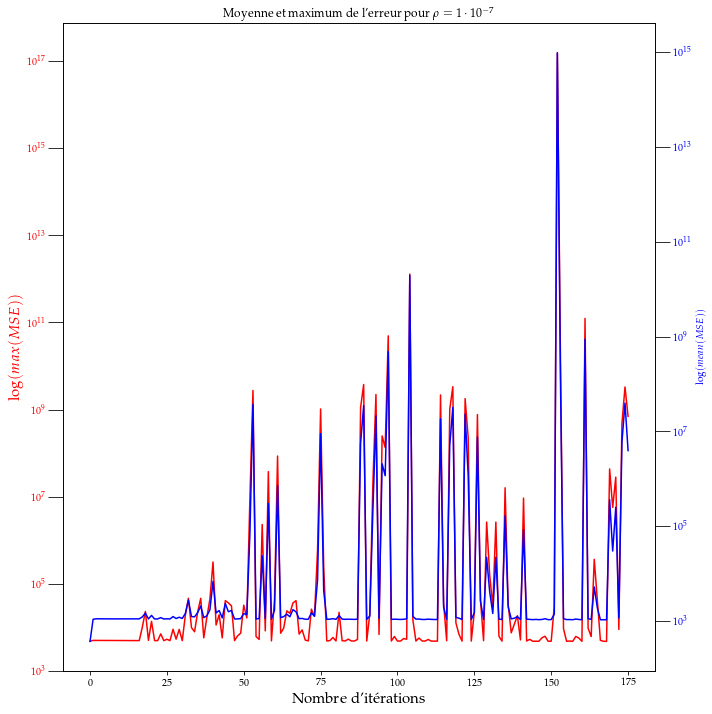

In [15]:



fig, ax1 = plt.subplots(figsize=(10,10))


ax1.set_xlabel("Nombre d'itérations",fontsize=15)
ax1.set_ylabel(r"$\log(max(MSE))$", fontsize=15,color='red')
ax1.plot(Max,color='red',label='max(MSE)')
ax1.tick_params(axis='y', labelcolor='red',size=15)
#ax1.set_ylim(bottom=2000,top=4000)
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax1.set_yscale('log')

ax2.set_ylabel(r'$\log(mean(MSE))$', color='blue')  # we already handled the x-label with ax1
ax2.plot(Means,color='blue',label='mean(MSE)')
ax2.tick_params(axis='y', labelcolor='blue',size=15)
#ax2.set_ylim(bottom=1000,top=5000)
ax2.set_yscale('log')
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title(r"Moyenne et maximum de l'erreur pour $\rho=1\cdot 10^{-7}$")
plt.savefig('graphes/loss_0000001_batch250_ex',dpi=300)
plt.show()

[199, 198, 197, 197, 196, 195, 195, 194, 193, 193, 193, 193, 192, 191, 191, 190, 189, 188, 188, 187, 186, 186, 185, 184, 184, 183, 182, 182, 182, 182, 181, 180, 180, 179, 178, 177, 177, 176, 176, 176, 176, 175, 174, 174, 173, 172, 172, 172, 172, 171, 170, 170, 169, 168, 168, 168, 168, 167, 166, 166, 165, 164, 164, 163, 162, 161, 161, 160, 159, 159, 158, 157, 157, 157, 157, 156, 155, 155, 154, 153, 153, 153, 153, 152, 151, 151, 150, 149, 149, 148, 147, 147, 147, 147, 146, 145, 145, 144, 143, 142, 142, 141, 140, 140, 139, 138, 137, 137, 136, 135, 135, 134, 133, 133, 132, 131, 131, 131, 131, 130, 129, 129, 128, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124,

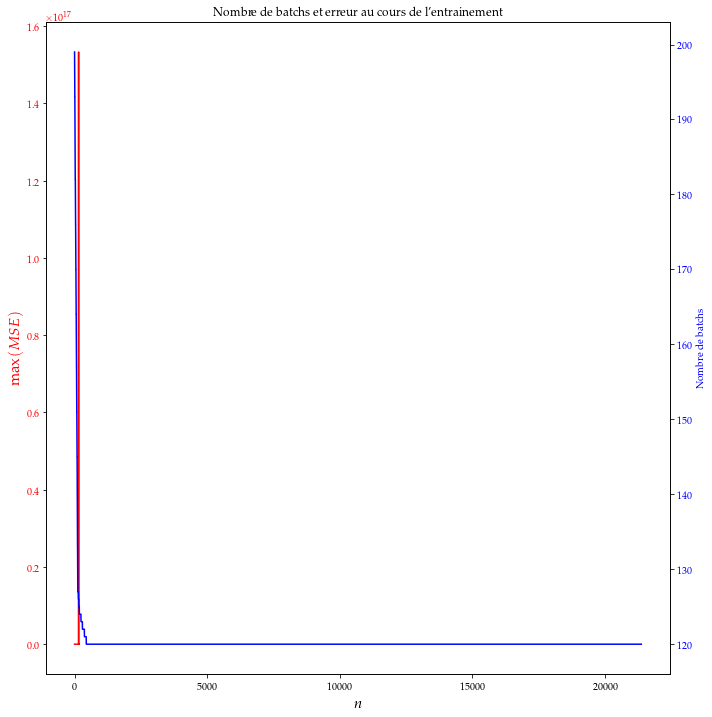

In [19]:
print(SelectedBatchs)
fig, ax1 = plt.subplots(figsize=(10,10))


ax1.set_xlabel(r'$n$',fontsize=15)
ax1.set_ylabel(r"$\max(MSE)$", fontsize=15,color='red')
ax1.plot(Max,color='red',label='MSE')
ax1.tick_params(axis='y', labelcolor='red')
#ax1.set_xlim(left=0,right=2500)
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis


ax2.set_ylabel('Nombre de batchs', color='blue')  # we already handled the x-label with ax1
ax2.plot(SelectedBatchs,color='blue',label='MSE')
ax2.tick_params(axis='y', labelcolor='blue')

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title("Nombre de batchs et erreur au cours de l'entrainement")
plt.savefig('graphes_org/selectedBatchs',dpi=300)
plt.show()

In [88]:
nb_steps_pred = 10000
t_pred = nb_steps_pred * GD.dt_integration
y_pred_init=np.zeros((nb_steps_pred,params['dim_output']))
tmp = np.reshape(xt.values[0,:],(1,params['dim_output']))
tmp = Variable(torch.from_numpy(tmp).float())
y_pred_init[0,:] = xt.values[0,:]
for i in range(1,nb_steps_pred):
    tmp.requires_grad = True
    y_pred_init[i,:] = modelRINN(tmp,params['dt_integration'],params['order'])[0].data.numpy()
    tmp = Variable(torch.from_numpy(np.reshape(y_pred_init[i,:] ,(1,params['dim_output']))).float())

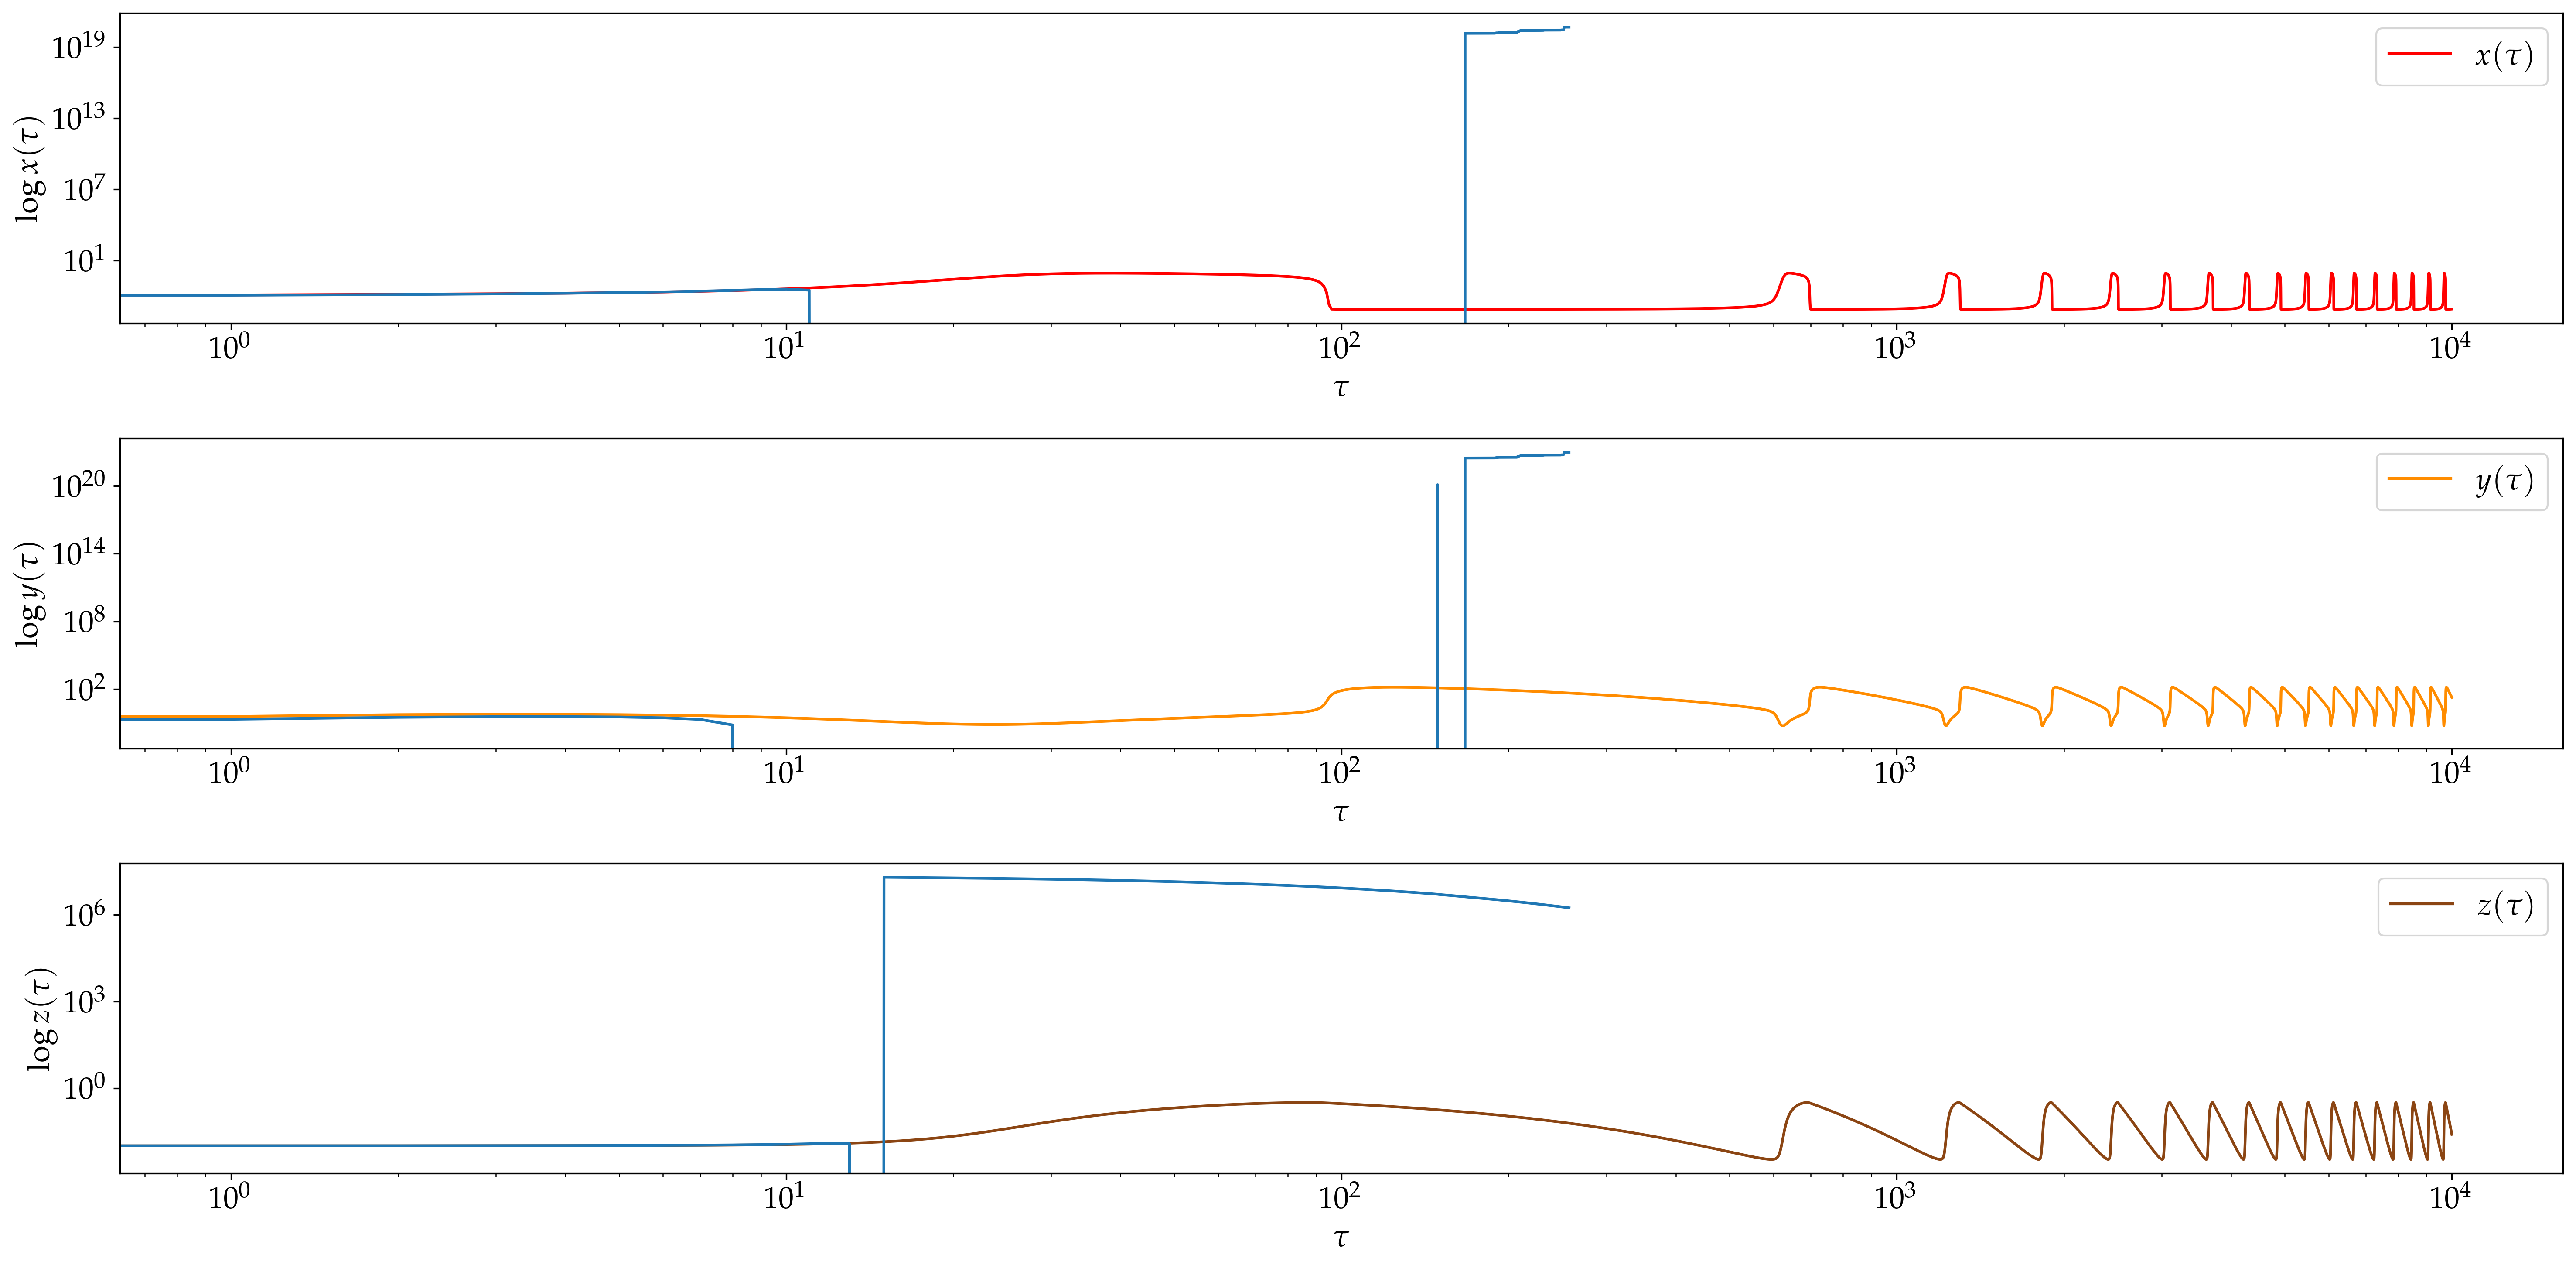

In [71]:
plt.figure(figsize=(20,10))
plt.title("Composantes de l'Oregonator")
plt.subplot(311)
plt.plot(xt.values[:,0],color='red',label=r'$x(\tau)$')
plt.plot(y_pred_init[:,0])
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$\tau$')
plt.ylabel(r'$\log x(\tau)$')
plt.legend(loc='best')
plt.subplot(312)
plt.plot(xt.values[:,1],color='darkorange',label=r'$y(\tau)$')
plt.plot(y_pred_init[:,1])
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$\tau$')
plt.ylabel(r'$\log y(\tau)$')
plt.legend(loc='best')
plt.subplot(313)
plt.plot(xt.values[:,2],color='saddlebrown',label=r'$z(\tau)$')
plt.plot(y_pred_init[:,2])
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$\tau$')
plt.ylabel(r'$\log z(\tau)$')
plt.legend(loc='best')
plt.tight_layout()
plt.savefig('graphes_org/pred0.png',dpi=300)

In [ ]:
(np.isnan(loss.data.numpy()))

In [ ]:
torch.save(modelRINN.state_dict(), 'RINN_L63_dt' + str(GD.dt_integration)+ '_two_steps.pt')

In [ ]:
for param_group in optimizer.param_groups:
        param_group['lr'] = 0.001
def customized_loss(x, y):
        gain_to_zero = ((x-y))**2
        return torch.mean(gain_to_zero)

In [ ]:
gain_op - gain_true

In [ ]:
clipper = applyRK_Constraints()
print ('Learning dynamical model')
for t in range(100*params['ntrain'][0]):
        for b in range(x.shape[0]):
            # Forward pass: Compute predicted gradients by passing x to the model
            gain_op = modelRINN.opti_gain_lin(h_int, x_lin[0,:1,:],order)
            loss_opti = customized_loss((gain_op), gain_true)
            # Compute and print loss
            loss = loss_opti
            if not (np.isnan(loss.data.numpy())):
                # Zero gradients, perform a backward pass, and update the weights.
                optimizer.zero_grad() 
                loss.backward()
                optimizer.step()
                torch.nn.utils.clip_grad_norm_(modelRINN.parameters(),5)
                #modelRINN.apply(clipper)
                if t % clipper.frequency == 0:
                    modelRINN.apply(clipper)    
            print(t,loss)

In [ ]:
# RK4 analytic integration scheme
import sympy as sp
xt, h = sp.symbols('xt h')
grad = modelRINN.Dyn_net_lin(xt)
k1   = modelRINN.Dyn_net_lin(xt)
k2   = modelRINN.Dyn_net_lin(xt+0.5*h*k1)
k3   = modelRINN.Dyn_net_lin(xt+0.5*h*k2)
k4   = modelRINN.Dyn_net_lin(xt+h*k3)            
xt_1RK4 = xt +h*(k1+2*k2+2*k3+k4)/6

gRK4 = xt_1RK4.factor(xt)/xt

In [ ]:
gainRK4 = np.zeros_like(hi)
for i in range(len(hi)):
    gainRK4[i] = np.abs(gRK4.evalf(subs={h: hi[i]}))

In [ ]:
length_h = 1000
plt.plot(hi[:length_h],gain_op.data.numpy()[:length_h],label = 'RINN11')
plt.plot(hi[:length_h],gain_true.data.numpy()[:length_h])
plt.plot(hi[:length_h],gainRK4[:length_h],label = 'RK4')
plt.legend()

In [ ]:
nb_steps_pred = 2000
t_pred = nb_steps_pred * GD.dt_integration
y_pred=np.zeros((nb_steps_pred,params['dim_output']))
tmp = np.reshape(catalog.analogs[0,:],(1,params['dim_output']))
tmp = Variable(torch.from_numpy(tmp).float())

for i in range(nb_steps_pred):
    y_pred[i,:] = modelRINN.flow_True_Model(tmp,0.01,order)[0].data.numpy()
    tmp = Variable(torch.from_numpy(np.reshape(y_pred[i,:] ,(1,params['dim_output']))).float())

In [ ]:
plt.plot(y_pred[:,:], label = 'forecasted time series')
plt.legend()

In [ ]:
plt.plot(catalog.analogs[:int(nb_steps_pred*0.01/0.2),:])

In [ ]:
plt.plot(y_pred[:,:], label = 'forecasted time series')
plt.legend()

In [ ]:
nb_steps_pred = 20000
t_pred = nb_steps_pred * GD.dt_integration
y_pred=np.zeros((nb_steps_pred,params['dim_output']))
tmp = np.reshape(catalog.analogs[0,:],(1,params['dim_output']))
tmp = Variable(torch.from_numpy(tmp).float())

for i in range(nb_steps_pred):
    y_pred[i,:] = modelRINN.flow_RK45_True_Model(tmp,0.001,order)[0].data.numpy()
    tmp = Variable(torch.from_numpy(np.reshape(y_pred[i,:] ,(1,params['dim_output']))).float())

In [ ]:
plt.plot(y_pred[:,:], label = 'forecasted time series')
plt.legend()

In [ ]:
nb_steps_pred = 2000
t_pred = nb_steps_pred * GD.dt_integration
y_pred=np.zeros((nb_steps_pred,params['dim_output']))
tmp = np.reshape(catalog.analogs[0,:],(1,params['dim_output']))
tmp = Variable(torch.from_numpy(tmp).float())

for i in range(nb_steps_pred):
    y_pred[i,:] = modelRINN(tmp,0.1,order)[0].data.numpy()
    tmp = Variable(torch.from_numpy(np.reshape(y_pred[i,:] ,(1,params['dim_output']))).float())

In [ ]:
plt.plot(y_pred[:,:], label = 'forecasted time series')
plt.legend()

In [ ]:
from scipy.interpolate import interp1d
interp_time_step = 0.01
time_step_ratio = GD.dt_integration/interp_time_step
t_new  = np.linspace(0, t_pred, num=int(nb_steps_pred*time_step_ratio), endpoint=True)
t_init = np.linspace(0, t_pred, num=nb_steps_pred, endpoint=True)
RINN_Interp=interp1d(t_init, y_pred,axis=0, kind='cubic')
plt.plot(RINN_Interp(t_new)[:1000,:])
plt.xlabel('prediction timestep'); plt.ylabel('Lorenz 63 states')

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
fig   =plt.figure()
ax    =fig.gca(projection='3d')
line1,=ax.plot(RINN_Interp(t_new)[:,0],RINN_Interp(t_new)[:,1],RINN_Interp(t_new)[:,2],'k')
ax.set_xlabel('$x_1$');ax.set_ylabel('$x_2$');ax.set_zlabel('$x_3$')
plt.legend([line1], ['Predicted attractor'])

In [ ]:
interp_time_step = 0.01
time_step_ratio = GD.dt_integration/interp_time_step
t_new  = np.linspace(0, t_pred, num=int(nb_steps_pred*time_step_ratio), endpoint=True)
t_init = np.linspace(0, t_pred, num=nb_steps_pred, endpoint=True)
true_Interp=interp1d(t_init, catalog.analogs[:y_pred.shape[0],:],axis=0, kind='cubic')
plt.plot(true_Interp(t_new)[:1000,:])
plt.xlabel('prediction timestep'); plt.ylabel('Lorenz 63 states')

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
fig   =plt.figure()
ax    =fig.gca(projection='3d')
line1,=ax.plot(true_Interp(t_new)[:,0],true_Interp(t_new)[:,1],true_Interp(t_new)[:,2],'k')
ax.set_xlabel('$x_1$');ax.set_ylabel('$x_2$');ax.set_zlabel('$x_3$')
plt.legend([line1], ['True interpolated attractor'])

# ISSUE : 

Test with a different integration time step : 

we get a different phase space trajectorie which emphasizes an overfitting of the learnt integration scheme on the training integration time step

In [ ]:
nb_steps_pred = 1000
t_pred = nb_steps_pred * GD.dt_integration
y_pred=np.zeros((nb_steps_pred,params['dim_output']))
tmp = np.reshape(xt.values[0,:],(1,params['dim_output']))
tmp = Variable(torch.from_numpy(tmp).float())

for i in range(nb_steps_pred):
    y_pred[i,:] = dyn_mdl(tmp,0.9*GD.dt_integration,order)[0].data.numpy()
    tmp = Variable(torch.from_numpy(np.reshape(y_pred[i,:] ,(1,params['dim_output']))).float())

plt.plot(y_pred)